# The Laplace mechanism in Apache Beam

This Colab has exercises for implementing the [Laplace mechanism](https://en.wikipedia.org/wiki/Additive_noise_mechanisms#Laplace_Mechanism) with Apache beam.


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/OpenMined/PipelineDP/blob/main/docs/tutorial_1/2_beam_laplace_mechansim.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/OpenMined/PipelineDP/blob/main/docs/tutorial_1/2_beam_laplace_mechansim.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

##Usage:
1. Click "Run in Google Colab" link above
2. Make a copy in Drive (File->Save a copy in Drive)
3. Run all cells in Setup area
4. Enjoy the exercises :)

This Colab assumes knowledge from the first [Colab](https://github.com/OpenMined/PipelineDP/blob/main/docs/tutorial_1/1_beam_introduction.ipynb)

##Prerequisites
1. [First Colab](https://colab.sandbox.google.com/drive/16cDES3D3EWH89pd3HcfrQp6HrHplLwcr#)
2. The knowledge of basic DP concepts (for a quick start about DP you can check excellent [blogposts](https://desfontain.es/privacy/differential-privacy-in-practice.html)).

# Setup

Please run all cells in section. It will install apache_beam, imports all needed libraries, create datafiles and initialize framework for exercises.

In [ ]:
#@title Install apache_beam and download and prepare data Netflix movie view
# !pip install apache_beam
!pip install apache-beam[interactive]
from IPython.display import clear_output
clear_output()

In [ ]:
#@title Import libraries
import apache_beam as beam
import datetime as dt
import os
import time
from dataclasses import dataclass
import numpy as np
from apache_beam.runners.portability import fn_api_runner
import apache_beam.transforms.combiners as combiners
import matplotlib.pyplot as plt

In [ ]:
#@title Set consts
INFILE = "movie_views.txt"
MOVIE_TITLES_FILE = "movie_titles.txt"
OUTPUT_DIR = "outputs"
OUTFILE = 'outputs/%s'

In [ ]:
#@title Create data files
# This is the first 10K lines of Netflix prize dataset. TODO: find a way to download
ten_k_lines= [
'1:\n1488844,3,2005-09-06\n822109,5,2005-05-13\n885013,4,2005-10-19\n30878,4,2005-12-26\n823519,3,2004-05-03\n893988,3,2005-11-17\n124105,4,2004-08-05\n1248029,3,2004-04-22\n1842128,4,2004-05-09\n2238063,3,2005-05-11\n1503895,4,2005-05-19\n2207774,5,2005-06-06\n2590061,3,2004-08-12\n2442,3,2004-04-14\n543865,4,2004-05-28\n1209119,4,2004-03-23\n804919,4,2004-06-10\n1086807,3,2004-12-28\n1711859,4,2005-05-08\n372233,5,2005-11-23\n1080361,3,2005-03-28\n1245640,3,2005-12-19\n558634,4,2004-12-14\n2165002,4,2004-04-06\n1181550,3,2004-02-01\n1227322,4,2004-02-06\n427928,4,2004-02-26\n814701,5,2005-09-29\n808731,4,2005-10-31\n662870,5,2005-08-24\n337541,5,2005-03-23\n786312,3,2004-11-16\n1133214,4,2004-03-07\n1537427,4,2004-03-29\n1209954,5,2005-05-09\n2381599,3,2005-09-12\n525356,2,2004-07-11\n1910569,4,2004-04-12\n2263586,4,2004-08-20\n2421815,2,2004-02-26\n1009622,1,2005-01-19\n1481961,2,2005-05-24\n401047,4,2005-06-03\n2179073,3,2004-08-29\n1434636,3,2004-05-01\n93986,5,2005-10-06\n1308744,5,2005-10-29\n2647871,4,2005-12-30\n1905581,5,2005-08-16\n2508819,3,2004-05-18\n1578279,1,2005-05-19\n1159695,4,2005-02-15\n2588432,3,2005-03-31\n2423091,3,2005-09-12\n470232,4,2004-04-08\n2148699,2,2004-06-05\n1342007,3,2004-07-16\n466135,4,2004-07-13\n2472440,3,2005-08-13\n1283744,3,2004-04-17\n1927580,4,2004-11-08\n716874,5,2005-05-06\n4326,4,2005-10-29\n1546549,5,2004-07-20\n1493697,1,2005-11-01\n880166,5,2005-07-12\n535396,2,2005-02-03\n494609,4,2004-12-08\n1961619,5,2005-06-01\n883478,4,2005-12-16\n793564,4,2004-04-19\n1567202,2,2004-03-01\n573537,4,2005-02-03\n1972040,4,2005-06-02\n1838912,3,2005-11-08\n411705,4,2004-05-11\n2244518,5,2004-09-15\n584542,5,2005-02-01\n667730,5,2005-05-26\n2488120,5,2005-09-20\n1926776,1,2005-10-05\n38052,3,2004-06-03\n1196100,4,2004-10-30\n314933,3,2005-09-12\n1792741,2,2004-02-09\n769643,1,2004-11-18\n2477242,5,2005-01-30\n1421006,3,2005-08-03\n729846,4,2005-08-09\n1719610,2,2005-08-19\n1696031,4,2005-01-25\n1817215,4,2005-09-01\n406057,4,2004-09-27\n636262,1,2005-09-26\n1245406,4,2004-12-30\n1834590,3,2005-02-05\n593225,3,2004-07-11\n1011918,4,2005-05-28\n1665054,4,2005-07-06\n2630337,5,2005-03-10\n1155747,3,2005-07-03\n2439493,1,2004-02-06\n479924,5,2005-08-02\n530789,5,2005-03-29\n765860,4,2005-06-13\n231001,3,2005-01-03\n1493615,5,2005-05-23\n1850615,2,2005-07-12\n68959,3,2005-08-11\n147386,5,2004-09-19\n624035,5,2004-02-19\n782308,5,2004-07-02\n1116080,5,2005-08-08\n421374,5,2004-11-17\n1158759,4,2004-06-13\n1025798,3,2005-09-02\n1215397,5,2005-07-19\n2475251,4,2005-08-25\n321111,2,2005-05-02\n2162676,3,2005-08-01\n2635437,4,2004-12-19\n2389367,1,2004-07-01\n485622,5,2005-08-01\n235553,4,2004-07-15\n831869,4,2005-06-02\n99400,5,2005-09-16\n684876,4,2005-11-01\n1871179,3,2004-12-08\n1107678,5,2005-03-15\n642036,3,2005-09-21\n700890,5,2004-05-06\n2289956,5,2004-04-29\n2040859,1,2004-11-23\n1524964,3,2005-04-19\n121318,4,2005-06-06\n317050,5,2005-11-15\n2287003,5,2004-12-20\n59052,2,2004-07-12\n893742,4,2005-04-27\n1346257,3,2005-08-23\n55016,3,2004-05-12\n30245,5,2004-10-19\n743633,4,2005-08-09\n1596531,5,2004-01-23\n1125499,5,2005-01-31\n706832,4,2005-05-06\n2465337,3,2005-04-04\n2291422,1,2005-08-28\n1777406,3,2005-01-02\n1904905,4,2005-05-13\n2450433,3,2005-01-08\n1348967,2,2004-06-21\n638020,3,2005-08-10\n2217779,4,2005-02-14\n194280,1,2004-12-14\n493009,4,2005-03-27\n1567167,4,2005-09-11\n850327,5,2005-09-18\n520386,3,2005-10-25\n320540,2,2005-07-26\n1188228,2,2004-12-05\n57961,4,2004-11-09\n1113230,3,2005-05-04\n1374216,2,2005-09-23\n595778,3,2004-03-03\n209573,4,2005-10-31\n2354601,5,2005-12-10\n2563596,4,2004-04-04\n835265,4,2005-09-01\n1819474,3,2004-04-03\n1447104,3,2004-08-28\n1100940,1,2005-10-24\n143274,3,2005-08-31\n2329565,4,2005-01-19\n181592,4,2005-03-26\n936396,2,2004-02-09\n1125797,3,2004-07-05\n2283366,3,2004-12-27\n514495,4,2005-04-13\n1772176,3,2005-09-27\n1877347,4,2005-07-13\n1287892,4,2005-05-17\n255443,2,2005-05-23\n890669,4,2005-11-02\n1989766,4,2005-07-08\n2315073,4,2004-03-24\n14756,4,2005-12-27\n907623,3,2004-05-11\n991423,4,2004-10-24\n1604238,4,2005-06-02\n1027056,3,2005-12-03\n2025883,5,2005-03-24\n732936,5,2005-04-24\n563962,5,2005-11-09\n799442,4,2005-11-21\n352635,5,2004-05-11\n2537543,5,2005-10-26\n1564395,4,2005-07-09\n1655178,4,2004-08-26\n573434,4,2004-05-26\n1141189,4,2004-12-15\n383247,5,2005-02-03\n1763921,5,2004-05-10\n1943970,5,2004-09-20\n322009,3,2004-05-20\n2333817,3,2004-10-22\n2095681,2,2005-10-29\n1149588,4,2005-12-13\n2354740,5,2005-05-05\n2421360,5,2005-10-19\n496087,2,2004-04-25\n2191781,1,2005-04-03\n1694083,4,2005-10-03\n818416,3,2005-07-27\n701960,5,2005-04-29\n2090477,4,2005-06-28\n1664010,5,2005-10-12\n2583822,5,2005-08-17\n369646,5,2005-04-30\n2234063,4,2005-05-11\n259799,4,2005-06-23\n1077982,4,2004-03-16\n2631796,4,2005-09-27\n1122383,3,2004-10-22\n1508526,3,2004-07-25\n1600207,5,2004-04-17\n1283117,5,2005-03-18\n1727869,5,2005-07-11\n1522799,4,2004-10-19\n1394012,5,2005-12-19\n1558286,3,2005-03-15\n1155602,3,2005-07-05\n361066,3,2004-09-24\n1743210,5,2005-09-22\n1148389,4,2004-04-03\n2268101,4,2005-10-28\n519684,5,2005-07-25\n767518,5,2005-08-02\n122197,1,2005-03-09\n2112162,4,2005-10-14\n1073367,3,2005-07-25\n400162,5,2004-11-08\n1524343,5,2005-03-24\n741245,4,2005-06-28\n2563768,3,2005-07-04\n1406595,4,2005-08-27\n1137010,4,2004-10-05\n60343,5,2005-05-08\n225765,4,2004-05-10\n2530404,3,2004-05-01\n437881,3,2004-11-17\n1935793,1,2005-04-18\n134001,4,2005-05-06\n2607300,3,2005-07-25\n1008986,4,2004-10-25\n94565,4,2004-12-15\n828410,4,2005-01-03\n1805202,4,2005-10-03\n1922925,4,2004-04-03\n1435717,5,2005-08-11\n2277395,4,2004-03-09\n2305014,5,2004-08-31\n166041,4,2005-09-02\n2413320,4,2004-02-06\n87113,2,2005-09-21\n722591,5,2004-03-08\n2291306,1,2004-03-01\n2010770,4,2004-12-30\n255383,5,2005-04-10\n1873429,4,2005-10-27\n1647618,4,2005-08-27\n608234,5,2005-02-25\n42930,3,2005-05-14\n1462072,5,2005-06-22\n685565,5,2005-09-26\n3321,3,2005-09-27\n2554942,4,2005-10-03\n1874547,4,2004-08-11\n2269844,5,2005-11-02\n34907,3,2005-08-17\n1779903,4,2005-06-04\n2576424,4,2005-08-10\n230112,3,2004-08-26\n508727,3,2004-07-11\n1603525,3,2004-10-13\n172264,4,2005-09-17\n1182185,4,2005-10-06\n2275470,2,2005-10-05\n491531,5,2005-02-17\n1346432,4,2005-11-15\n1554712,5,2004-10-27\n1450941,5,2005-09-13\n1714116,3,2005-08-09\n2016488,4,2004-11-22\n1782762,4,2005-01-19\n1343170,5,2005-02-26\n2565752,4,2004-12-10\n435841,3,2005-09-19\n2242821,5,2005-08-29\n638824,5,2004-05-19\n2256485,1,2004-08-19\n101597,5,2004-10-01\n623036,5,2005-05-16\n1559445,5,2005-06-08\n1723381,5,2005-08-30\n1824586,4,2005-03-03\n2233105,4,2005-09-08\n682963,3,2005-06-21\n2529547,5,2005-11-18\n504620,2,2005-08-12\n1682104,4,2005-08-30\n16272,4,2005-01-20\n2491785,5,2005-05-09\n978412,5,2005-07-02\n2054145,3,2005-07-28\n2444240,3,2005-08-14\n547732,3,2005-06-11\n811790,5,2005-09-02\n31913,4,2004-10-15\n437111,4,2005-06-27\n640588,4,2004-09-06\n2625019,3,2005-09-12\n2605190,5,2005-11-05\n915,5,2005-08-17\n1430587,4,2005-05-18\n2544219,5,2005-11-20\n2603381,5,2005-11-29\n305344,1,2004-02-08\n2569099,1,2005-08-16\n2430356,4,2004-07-15\n885165,4,2005-06-02\n2380806,5,2005-09-06\n1512406,1,2005-10-03\n1774623,4,2005-11-23\n2226525,4,2005-02-08\n2537076,4,2005-10-17\n2060858,4,2005-05-09\n498469,5,2005-03-22\n68033,4,2005-10-04\n1819146,5,2005-08-15\n2088415,4,2005-02-01\n473070,5,2005-04-06\n1823641,5,2004-03-29\n1839976,2,2004-03-31\n14924,5,2005-10-04\n1852606,4,2004-07-23\n453694,5,2004-07-21\n921487,2,2004-07-19\n1022254,5,2004-09-15\n2464081,4,2005-01-22\n1228324,4,2005-11-12\n1563530,4,2004-08-18\n1181170,3,2004-09-08\n1357013,3,2004-10-02\n21722,4,2005-02-07\n288420,5,2005-06-02\n1739170,5,2005-09-19\n2584676,3,2005-08-06\n2013504,4,2005-08-10\n1245176,4,2004-07-27\n269524,3,2005-03-05\n661344,3,2005-03-16\n652324,3,2004-04-15\n2239213,3,2005-08-24\n863302,4,2004-08-19\n758850,4,2004-09-21\n1884755,2,2004-11-15\n544833,3,2005-09-27\n1562707,1,2005-07-25\n810700,5,2004-08-31\n837756,5,2004-10-26\n155164,4,2004-10-29\n493945,5,2005-04-12\n1565175,5,2004-08-10\n2005193,4,2005-11-17\n1605780,4,2004-09-17\n1294335,2,2004-09-22\n608576,4,2005-03-19\n659505,4,2005-05-16\n1604707,4,2005-10-17\n2630797,5,2005-12-09\n402266,5,2004-10-16\n752642,3,2004-02-24\n1906145,4,2005-07-19\n389872,2,2005-08-09\n1462866,2,2004-10-09\n1952116,4,2005-04-28\n54774,4,2005-05-25\n1776980,5,2005-10-13\n1494196,5,2004-02-29\n253794,5,2004-08-10\n1569513,3,2004-02-26\n596728,2,2004-04-26\n1107588,1,2004-02-22\n1133763,3,2005-05-15\n1398076,4,2004-07-02\n1178171,4,2004-07-01\n984369,3,2005-08-25\n2618594,4,2004-07-27',
 '1653834,4,2004-08-22\n2322840,3,2005-07-12\n2207647,4,2004-08-12\n1994111,4,2005-01-11\n1824044,4,2004-04-29\n2255037,3,2004-06-01\n2056022,3,2004-11-22\n1458179,4,2005-01-26\n1508350,4,2005-06-27\n1168571,5,2005-09-14\n766489,3,2005-10-01\n1424199,5,2005-08-08\n2054180,3,2004-07-09\n448902,5,2005-07-20\n1547173,3,2005-11-18\n1751103,4,2004-08-05\n121073,5,2004-12-16\n2609436,4,2004-11-09\n1398626,2,2004-12-03\n1311231,3,2004-03-30\n2279000,3,2005-02-18\n236921,5,2005-03-19\n2566259,5,2005-04-06\n758937,4,2005-10-24\n2260684,4,2004-11-08\n1190829,4,2004-02-10\n136106,3,2005-08-08\n344753,3,2004-07-21\n568930,5,2005-05-02\n206115,4,2005-08-23\n2390644,3,2004-09-06\n2078679,5,2005-01-07\n1682651,4,2005-05-02\n386915,4,2005-05-27\n972136,3,2005-06-20\n1806515,3,2005-09-29\n11589,3,2005-10-19\n2118461,5,2005-10-24\n444411,3,2004-09-05\n691108,4,2005-02-27\n332401,3,2005-04-28\n1278488,4,2005-04-27\n358776,4,2005-11-21\n387418,1,2004-02-08\n872408,4,2005-08-26\n646098,4,2004-07-19\n396595,5,2005-02-13\n1366860,4,2004-01-26\n1046882,3,2004-08-12\n470861,5,2004-06-28\n1455257,4,2004-09-17\n1274780,3,2004-10-11\n379184,4,2005-02-11\n1273630,4,2005-09-08\n492291,3,2005-06-06\n145873,3,2004-02-25\n1388284,5,2004-12-21\n712610,4,2005-04-27\n1116065,1,2005-05-03\n660499,1,2005-07-08\n1918987,4,2005-07-10\n1357894,3,2004-09-09\n190418,3,2004-09-30\n1060658,3,2005-03-23\n1443203,4,2005-05-22\n1772839,5,2005-09-19\n2385774,3,2004-04-07\n1059319,3,2005-10-10\n831775,4,2005-10-15\n881346,5,2005-11-07\n1066317,4,2004-05-07\n13651,3,2004-06-16\n208920,4,2005-01-23\n308753,5,2005-10-31\n2564257,3,2005-11-27\n565041,4,2004-08-23\n1602153,4,2005-06-13\n173930,4,2005-06-30\n202811,3,2005-07-18\n353369,3,2005-08-01\n1201176,4,2005-05-02\n2047577,3,2005-05-27\n685113,4,2005-10-24\n1686060,5,2004-03-21\n151004,5,2004-07-09\n2126192,3,2004-04-16\n1981464,4,2005-08-16\n1862581,4,2004-06-08\n1255780,5,2005-03-28\n1962300,3,2005-06-22\n1515355,3,2004-05-12\n1001779,4,2005-09-09\n2093105,3,2004-06-17\n1123959,3,2005-01-05\n1876297,5,2005-05-19\n1364481,4,2004-05-29\n998236,5,2004-06-23\n328415,3,2004-11-01\n1347129,4,2005-01-24\n1117062,4,2005-07-07\n1033930,3,2005-08-11\n45117,5,2005-08-15\n1005769,5,2004-09-28\n712609,4,2005-03-20\n740495,4,2005-02-05\n2497991,4,2005-07-07\n1017324,4,2005-04-05\n120491,5,2004-09-13\n1645794,4,2005-04-05\n1658790,3,2005-06-23\n2451020,4,2004-09-14\n1878798,4,2005-01-11\n1790903,4,2005-04-23\n1254683,1,2004-02-13\n874943,5,2005-03-22\n121456,4,2005-04-19\n1140108,4,2005-09-20\n515436,1,2005-02-13\n272689,5,2005-03-03\n1247177,3,2005-12-04\n263240,3,2004-07-07\n2539549,3,2005-02-23\n2565654,5,2004-11-15\n334701,3,2005-02-07\n42921,3,2005-10-04\n2011399,5,2005-08-08\n433945,5,2004-11-06\n2151149,4,2005-01-13\n1415954,2,2005-02-14\n1086360,3,2005-03-10\n2419258,4,2005-08-12\n2380848,5,2005-01-11\n1550216,1,2005-02-07\n596533,5,2005-03-20\n287901,5,2005-05-30\n188613,4,2005-09-15\n1654508,3,2005-04-25\n1313126,5,2005-04-27\n51334,4,2005-05-18\n2374451,4,2005-06-05\n2031093,4,2005-06-30\n548064,5,2005-12-02\n946102,5,2005-02-02\n1790158,4,2005-05-17\n1403184,3,2005-11-12\n1535440,4,2005-08-18\n1426604,4,2005-09-01\n1815755,5,2004-07-20\n2:\n2059652,4,2005-09-05\n1666394,3,2005-04-19\n1759415,4,2005-04-22\n1959936,5,2005-11-21\n998862,4,2004-11-13\n2625420,2,2004-12-06\n573975,3,2005-07-21\n392722,4,2004-12-10\n1401650,4,2005-02-24\n988104,3,2005-05-23\n977632,4,2004-11-12\n2557870,4,2005-03-27\n1793899,5,2005-06-04\n1340535,5,2004-12-12\n1888322,5,2005-01-20\n1283598,3,2004-11-30\n1784150,4,2005-06-17\n2271251,5,2005-08-19\n65932,3,2005-07-19\n1828884,5,2004-12-21\n1878728,4,2005-12-01\n1922778,3,2005-02-07\n1176404,4,2005-02-23\n2265116,3,2005-09-06\n1078701,4,2005-10-12\n1832577,4,2005-09-07\n748922,5,2005-07-05\n1013802,1,2005-05-30\n1131325,2,2005-11-14\n2244378,4,2005-02-09\n494639,2,2005-09-26\n636262,1,2005-08-23\n1903158,4,2005-03-04\n220427,4,2005-05-05\n2439493,1,2005-02-10\n2225116,4,2005-08-29\n1445632,5,2005-01-30\n2592823,4,2005-02-06\n1288603,5,2005-06-20\n2556926,3,2005-07-09\n1190070,4,2005-11-05\n1312846,3,2005-08-26\n2226229,3,2005-04-24\n1563935,1,2005-08-12\n69809,5,2005-04-08\n1349753,3,2005-03-23\n785768,3,2005-04-19\n426476,5,2005-05-10\n810636,4,2005-04-25\n468713,5,2005-07-18\n222290,4,2005-03-14\n349407,5,2005-01-02\n311232,2,2005-06-28\n2596999,4,2005-10-07\n1025601,5,2005-11-09\n1743759,4,2005-01-30\n2385553,5,2005-05-24\n1374216,1,2005-09-25\n526466,4,2005-03-05\n2648861,3,2005-05-25\n1210631,3,2005-03-24\n2314531,4,2005-07-15\n618272,1,2005-08-14\n2532807,3,2005-01-28\n412535,4,2005-05-23\n1315005,4,2005-06-28\n1358911,5,2005-12-13\n507603,1,2005-07-23\n1507649,5,2005-02-17\n845529,5,2005-04-26\n1479907,5,2005-02-28\n236271,2,2005-06-21\n2422676,3,2005-04-07\n1636093,5,2005-10-20\n995594,5,2005-01-19\n1664010,4,2005-10-13\n2431481,3,2004-11-18\n1980668,5,2004-12-16\n402321,4,2005-04-18\n1344564,3,2005-01-25\n1632603,3,2005-09-09\n2567280,3,2005-03-17\n1623166,3,2005-02-10\n521932,4,2005-01-11\n105086,5,2005-09-20\n2072554,5,2005-05-05\n2231529,3,2005-08-25\n2103439,2,2005-06-05\n261764,1,2005-11-10\n193476,5,2005-03-23\n1576540,4,2005-04-14\n1783594,5,2005-03-07\n503334,4,2005-11-25\n183903,5,2005-01-30\n2606799,1,2005-05-16\n1236127,4,2005-06-07\n2375962,3,2005-07-04\n2212071,3,2005-09-17\n1252841,3,2005-02-06\n247898,5,2005-07-15\n970975,3,2005-09-02\n305344,1,2004-10-16\n1581186,4,2005-02-27\n1129620,3,2005-09-03\n584750,3,2005-11-27\n11409,5,2005-01-13\n1875495,2,2005-01-12\n1403217,2,2005-08-17\n2147527,1,2005-11-18\n2418486,4,2005-11-08\n1476323,5,2004-11-22\n2345723,4,2004-12-26\n2640085,5,2005-04-26\n1803154,2,2004-12-14\n1251170,2,2005-02-11\n527491,4,2005-07-30\n391517,4,2005-05-16\n1398626,3,2005-11-26\n828919,5,2004-12-18\n196494,5,2005-10-03\n715897,5,2005-10-18\n268917,2,2005-06-03\n41422,4,2005-09-11\n1806515,3,2005-09-23\n2118461,4,2005-12-20\n387418,1,2004-11-19\n2019055,5,2005-05-12\n348960,1,2005-09-07\n1167731,4,2005-06-07\n2468831,5,2005-07-05\n219925,4,2005-04-18\n1025193,5,2005-07-07\n630887,5,2005-01-20\n1461435,1,2005-03-21\n1838586,1,2005-08-17\n1515430,3,2005-01-27\n1807053,5,2005-04-25\n1172326,5,2005-06-18\n1785842,3,2005-06-01\n803752,3,2004-11-17\n1581265,3,2005-04-15\n515436,1,2005-02-13\n1824543,4,2005-04-20\n1283204,3,2004-12-23\n1272122,5,2005-07-25\n3:\n1025579,4,2003-03-29\n712664,5,2004-02-01\n1331154,4,2004-07-03\n2632461,3,2005-07-22\n44937,5,2004-06-22\n656399,4,2003-09-20\n439011,1,2004-01-22\n1436762,3,2003-03-17\n1644750,3,2003-03-19\n2031561,4,2004-03-31\n616720,4,2003-08-10\n2467008,4,2004-03-15\n975874,5,2004-02-09\n701730,2,2005-10-05\n1614320,4,2003-08-11\n115498,3,2003-07-16\n931626,2,2004-07-08\n699878,4,2003-05-02\n1694958,3,2005-08-10\n66414,5,2004-02-21\n2519847,5,2003-03-10\n948069,3,2003-05-09\n67315,4,2003-08-25\n704249,4,2004-08-16\n454417,4,2004-04-18\n1995318,3,2004-07-14\n2158448,5,2005-05-31\n574843,5,2005-06-13\n714960,4,2005-06-21\n620771,2,2005-09-26\n253876,4,2005-11-01\n1632700,4,2005-11-14\n603277,3,2003-06-21\n79160,4,2005-07-11\n1859725,4,2003-05-30\n283774,5,2003-08-23\n1983667,2,2003-08-08\n2267507,4,2004-05-25\n1813349,4,2003-03-18\n2424721,3,2005-09-04\n1275804,4,2003-08-27\n1204327,4,2004-03-16\n2143489,1,2004-08-23\n672980,5,2004-11-18\n166100,4,2004-12-17\n2537764,5,2005-01-06\n1650301,2,2005-06-17\n553931,4,2005-10-04\n214166,3,2005-10-09\n6689,4,2003-02-20\n109089,5,2003-05-27\n1854303,1,2004-05-29\n525003,5,2003-04-30\n2312349,4,2003-05-13\n188416,3,2004-01-27\n2213550,4,2004-07-01\n24344,4,2004-08-20\n2344483,4,2004-09-28\n531155,4,2005-02-28\n1959707,3,2005-03-19\n2120279,5,2005-05-15\n1977959,4,2003-02-12\n21983,4,2003-04-19\n2173816,1,2003-07-17\n78931,5,2003-07-09\n2145227,4,2003-04-07\n2463079,3,2003-08-26\n1286051,3,2004-01-28\n958104,4,2003-09-03\n489962,3,2003-09-03\n2297863,4,2004-01-13\n958382,4,2004-08-22\n248932,4,2005-04-03\n1756658,3,2005-06-16\n2579794,4,2005-10-26\n1628475,4,2005-11-14\n206809,5,2003-03-05\n1333,4,2004-05-18\n445828,2,2003-10-28\n2079559,5,2004-08-28\n1007809,4,2003-12-16\n1562675,1,2003-03-06\n1477923,4,2003-03-25\n44783,3,2003-11-22\n52540,1,2003-03-22\n2436327,2,2004-07-13\n1830211,4,2004-10-06\n1857979,2,2005-03-08\n1198785,2,2005-06-30\n870391,2,2003-05-19\n2164676,4,2003-03-03\n1281996,4,2003-07-23\n1853885,4,2004-06-18\n2646060,3,2003-09-24\n709342,4,2003-09-10\n1195585,5,2003-08-04\n1319527,5,2005-01-05\n1478381,4,2005-05-26\n1658752,3,2003-03-09\n41371,5,2004-01-21\n1479793,3,2004-01-18\n1406148,3,2004-09-17\n2446687,5,2004-12-14\n968796,3,2005-02-06\n2266857,3,2003-06-13',
 '1456369,4,2003-07-08\n1078792,4,2005-09-09\n104768,5,2003-11-25\n372528,3,2004-06-30\n2240742,5,2004-11-05\n1401399,4,2005-04-03\n402377,4,2005-04-10\n51230,4,2005-05-22\n2229289,4,2005-12-30\n2554745,4,2004-04-08\n1710932,3,2004-08-16\n1355097,4,2003-03-26\n1231910,3,2003-12-23\n2599552,4,2003-04-14\n1394444,5,2005-02-17\n1094443,2,2003-09-04\n77266,2,2003-03-06\n153249,4,2003-06-24\n2590630,3,2003-10-10\n2596383,3,2005-11-03\n2601294,4,2004-02-10\n2623268,4,2004-12-14\n1756597,5,2005-04-11\n1673185,3,2005-04-14\n2611525,3,2004-02-05\n2013198,4,2003-03-10\n1704175,4,2004-04-29\n2186436,2,2004-04-21\n2252223,5,2004-06-24\n780282,4,2004-06-06\n203667,5,2003-03-25\n2338873,5,2003-03-18\n479779,4,2004-01-13\n1927897,5,2004-07-27\n719833,4,2003-09-08\n871489,5,2004-09-14\n968765,5,2004-10-11\n1057518,4,2005-01-03\n257517,4,2004-05-17\n2003554,4,2003-04-25\n2203875,4,2003-03-07\n2213289,5,2003-06-06\n2630072,3,2003-12-02\n1142291,4,2005-08-22\n1733188,4,2004-03-24\n1614895,4,2003-09-13\n1947922,2,2004-02-19\n1036823,3,2004-09-20\n786312,3,2004-11-06\n1197233,2,2005-02-17\n1100037,3,2005-04-02\n1130826,3,2005-05-02\n620147,5,2005-05-26\n1479047,4,2005-09-27\n1221390,4,2003-02-17\n2193643,5,2003-06-04\n544496,2,2004-02-02\n357507,3,2003-03-04\n976059,3,2004-06-22\n820624,4,2004-02-09\n924839,5,2004-05-18\n966255,4,2004-07-09\n108052,4,2005-03-22\n375319,4,2005-09-15\n309333,4,2005-10-16\n1599030,5,2003-03-05\n2443370,4,2003-07-07\n871580,3,2003-05-13\n311641,1,2005-08-27\n532382,4,2003-08-21\n2378011,5,2004-01-27\n946970,4,2004-01-23\n175763,4,2004-05-04\n619721,4,2004-10-27\n1248452,3,2005-01-20\n1863843,2,2005-06-29\n1915354,4,2005-10-20\n920625,2,2005-11-14\n1100170,4,2005-12-18\n1733406,4,2003-03-26\n755319,3,2005-08-14\n1743030,3,2004-04-05\n309567,2,2003-05-07\n2096587,5,2003-06-09\n345869,4,2004-08-08\n1544094,5,2005-02-22\n1022903,4,2005-09-14\n290951,4,2003-02-24\n1737484,4,2004-08-16\n183215,4,2005-08-15\n2065639,4,2004-04-02\n250836,3,2005-09-08\n2126122,4,2005-02-22\n1206452,4,2005-03-21\n2068821,3,2005-05-30\n1924939,4,2005-10-25\n1940163,4,2005-07-14\n1033433,2,2004-06-05\n1213801,3,2003-04-09\n1045221,1,2003-05-13\n253037,3,2005-08-05\n341954,2,2003-12-15\n697945,4,2003-05-28\n1115632,3,2003-11-24\n2103655,3,2003-08-01\n2495200,5,2004-10-05\n714550,4,2005-04-02\n979820,1,2005-06-26\n514312,3,2004-05-19\n2025577,3,2003-08-22\n1589677,4,2003-06-12\n425033,3,2003-06-13\n2352327,4,2004-09-08\n156078,5,2004-08-03\n851855,4,2003-05-20\n2441707,3,2003-05-23\n1278394,4,2003-06-07\n962955,2,2003-10-03\n811218,5,2004-05-11\n636475,3,2005-01-29\n1087412,4,2005-02-20\n410537,4,2005-06-06\n1586499,3,2003-07-28\n917063,4,2003-02-15\n1023101,3,2003-08-04\n2393306,4,2004-08-31\n788774,4,2003-04-25\n2586963,4,2003-06-08\n2368791,3,2003-04-30\n244266,3,2003-12-04\n2622138,1,2004-02-23\n793228,4,2004-05-19\n1283965,4,2005-11-08\n2135038,4,2003-10-20\n722006,4,2005-02-20\n1511683,1,2003-05-30\n1939663,4,2003-07-20\n1763372,3,2003-06-18\n1834472,3,2003-04-08\n209549,5,2004-06-15\n515850,5,2003-09-23\n1455472,2,2004-06-22\n2301782,4,2004-11-08\n770921,5,2004-12-13\n297498,5,2005-04-04\n386510,5,2005-09-16\n2494367,2,2005-10-08\n1607574,4,2005-10-20\n1594095,4,2004-09-08\n1124822,4,2005-08-15\n544022,3,2004-08-19\n1817216,2,2003-06-10\n1931698,2,2004-07-08\n569099,3,2003-05-19\n1771085,2,2003-07-21\n604949,4,2004-09-19\n213541,3,2004-10-31\n790920,3,2004-12-02\n2554707,4,2005-03-08\n376148,5,2005-04-25\n1689439,5,2004-06-25\n2485566,5,2004-08-09\n2232958,4,2004-03-01\n2267858,3,2003-04-24\n1956967,4,2005-08-13\n2494005,2,2005-08-27\n323148,3,2003-11-29\n2158065,4,2003-10-28\n2370268,4,2003-09-29\n2152838,5,2004-08-01\n1407746,3,2004-08-19\n1666581,4,2005-05-25\n871548,5,2005-03-10\n2385706,4,2003-04-23\n1969676,5,2004-01-26\n1927329,5,2004-01-06\n1938559,5,2004-06-21\n199769,4,2004-01-22\n2576108,1,2003-06-16\n162854,4,2004-10-25\n215406,5,2005-02-18\n2095263,4,2005-05-22\n556045,5,2005-10-18\n817851,4,2004-01-17\n2491399,2,2005-07-24\n1134816,4,2003-07-23\n660454,4,2003-03-24\n581199,4,2003-10-27\n1545189,4,2003-07-07\n1929487,3,2005-09-04\n528384,5,2003-09-26\n2646115,3,2003-10-08\n727242,1,2005-01-04\n883478,1,2005-10-27\n247940,4,2003-08-29\n369761,3,2003-08-19\n1065126,4,2004-03-09\n1101467,4,2003-07-29\n393413,3,2004-04-06\n478176,4,2004-05-26\n1369550,3,2004-10-11\n2428502,4,2005-12-05\n282525,4,2003-02-21\n2085230,4,2004-03-15\n282522,3,2003-06-18\n2246070,3,2004-01-06\n532649,3,2004-01-19\n1053903,2,2004-05-02\n1521266,3,2004-09-28\n2303969,4,2004-12-27\n2580481,2,2005-03-08\n2551806,5,2003-02-17\n1749903,4,2003-07-30\n2549926,5,2003-06-20\n781779,3,2003-06-17\n22853,4,2004-02-10\n1788346,1,2003-05-19\n1858421,4,2004-02-01\n354704,3,2003-10-15\n841137,5,2004-07-19\n475797,4,2004-05-11\n1876156,3,2005-01-12\n769670,4,2005-01-19\n1272379,1,2005-01-19\n2170930,1,2005-06-27\n788185,3,2004-01-25\n336990,3,2003-08-25\n2625746,2,2003-06-30\n2627825,3,2005-03-01\n109124,4,2005-03-12\n834128,3,2005-05-10\n113694,4,2005-06-12\n32555,2,2003-12-15\n592671,3,2003-05-10\n2618956,4,2003-07-10\n1871063,2,2004-07-12\n2437901,3,2004-05-28\n951568,3,2004-07-28\n1314869,2,2005-06-14\n1370323,4,2005-06-29\n475143,4,2005-09-12\n1618217,5,2005-10-31\n1547807,3,2004-05-25\n968759,3,2003-02-14\n2299121,1,2003-09-04\n477486,3,2003-08-03\n1307784,4,2004-10-18\n1234622,4,2004-10-21\n164845,1,2005-03-04\n1318399,4,2005-04-21\n2178924,4,2003-05-04\n1022046,5,2004-01-28\n962342,4,2003-09-25\n636262,1,2005-08-22\n334051,4,2003-05-20\n665242,2,2003-07-15\n701615,3,2005-10-12\n1304280,4,2003-11-26\n2237185,4,2003-02-13\n2175436,3,2003-08-04\n406221,3,2005-08-02\n1926750,5,2003-03-21\n257250,4,2004-02-25\n1281248,2,2003-06-13\n2128386,4,2003-05-08\n179647,5,2003-07-31\n1029943,3,2005-10-31\n786695,4,2003-08-25\n1532433,4,2003-05-07\n2316025,3,2003-03-14\n2506266,5,2003-07-08\n1130920,5,2003-05-08\n1928584,4,2004-06-23\n35770,5,2004-12-28\n1055670,2,2004-04-15\n1740800,5,2004-01-10\n254887,4,2003-02-21\n187322,4,2003-06-11\n2361606,5,2004-04-07\n118694,3,2004-07-30\n1878820,3,2003-06-16\n2391686,3,2004-09-12\n126899,3,2004-10-18\n2269450,3,2004-10-26\n2130480,5,2005-02-16\n1819462,1,2005-04-12\n1130533,3,2005-05-04\n178511,2,2005-12-10\n1649641,3,2005-07-08\n1630448,2,2003-08-16\n2439493,1,2003-02-12\n2160278,3,2003-10-29\n767139,4,2004-07-30\n1025764,3,2003-10-28\n964865,4,2003-09-07\n500867,3,2004-09-03\n294943,4,2004-03-02\n176054,1,2004-12-17\n1697078,2,2005-01-04\n2031917,3,2005-01-04\n1068821,4,2005-10-29\n120004,3,2004-05-05\n1367949,2,2004-01-11\n1205848,4,2003-08-07\n1386457,3,2003-03-11\n1252571,3,2005-08-08\n283935,3,2004-05-24\n137360,2,2005-08-14\n1204833,5,2003-07-24\n504593,4,2004-01-23\n2141351,4,2005-08-30\n1873737,5,2004-02-22\n388752,4,2004-11-17\n2601604,4,2005-11-07\n2609783,4,2005-12-01\n478484,4,2004-07-12\n148844,4,2005-08-02\n253394,5,2003-04-25\n705026,3,2003-06-04\n1634333,5,2003-07-10\n2040306,4,2004-04-23\n44402,4,2005-11-27\n2040110,3,2005-10-30\n2052691,3,2003-05-04\n187834,3,2003-12-24\n2340535,4,2004-06-23\n489033,1,2003-12-03\n2526250,3,2005-08-30\n561923,3,2004-06-05\n2092379,4,2004-03-10\n1998346,4,2004-04-12\n1144273,4,2005-03-23\n328674,3,2005-04-26\n47512,4,2005-07-01\n2159701,4,2005-11-14\n2069119,4,2005-12-11\n1241521,3,2005-07-14\n1616563,4,2003-03-17\n1095071,4,2004-01-07\n1105606,4,2003-10-02\n1806991,5,2003-12-18\n169126,5,2003-10-23\n1386030,4,2004-02-24\n238740,3,2004-08-29\n2083665,2,2004-10-02\n2491723,4,2005-03-20\n1045551,3,2005-04-08\n1873176,5,2003-05-22\n965528,4,2004-01-09\n593454,4,2004-01-14\n2291427,3,2005-08-14\n1182116,3,2003-04-24\n2245500,2,2003-12-23\n677213,4,2004-10-13\n1927891,4,2005-02-01\n1163795,4,2005-03-28\n2079661,3,2005-06-21\n828724,4,2005-09-08\n2560039,3,2005-11-04\n704538,4,2004-07-21\n1873379,4,2003-02-13\n277990,4,2003-11-26\n1052493,4,2004-04-15\n1945838,4,2003-06-03\n1770331,5,2003-06-07\n2584024,3,2005-06-07\n1654540,4,2005-10-16\n2419782,3,2004-03-16\n2068749,3,2003-07-18\n2331444,3,2003-03-07\n1150223,5,2004-01-30\n755056,2,2003-06-10\n1646880,4,2004-05-19\n1506586,3,2004-02-16\n2267950,4,2004-02-02\n1188701,4,2004-05-29\n2531820,4,2004-12-13\n1848973,5,2005-04-22\n1024854,3,2003-09-19\n50123,3,2003-08-13\n631945,4,2004-06-12\n1122977,3,2004-02-15\n1486636,3,2004-01-07\n1374830,4,2004-04-21\n630174,4,2004-11-02\n1068377,5,2004-03-14\n2070019,4,2005-01-19\n1146281,4,2003-04-17\n1136807,4,2003-02-21\n1931131,5,2003-12-11\n2043472,4,2004-02-22\n1276114,3,2003-06-07\n1950189,3,2003-05-20\n1046918,5,2003-08-31\n1320942,5,2003-12-30\n2091987,2,2004-07-14\n2523426,5,2004-05-27\n808635,3,2004-05-05\n1149883,4,2004-10-28\n908840,5,2005-06-20',
 '61765,4,2005-11-12\n565510,3,2003-03-09\n2592894,4,2003-06-16\n1528420,4,2003-06-23\n563607,4,2003-08-04\n66230,3,2004-04-09\n1598429,2,2004-06-22\n593167,3,2003-06-12\n1765182,4,2004-07-01\n2264426,5,2005-09-02\n2427632,3,2005-09-04\n698713,4,2004-04-15\n510719,4,2005-03-31\n521461,3,2005-04-28\n1399261,3,2004-08-11\n1902658,4,2003-09-15\n2455107,3,2004-03-30\n728801,4,2004-04-19\n2138332,4,2003-03-11\n1963179,3,2004-03-08\n1057394,3,2004-11-07\n1741962,3,2003-03-13\n2415330,4,2003-09-25\n2429036,4,2004-04-20\n212591,4,2003-03-04\n1200589,3,2004-02-23\n2385738,3,2004-09-12\n275639,4,2004-06-04\n1177340,4,2004-12-07\n1412189,5,2005-02-06\n799974,4,2005-04-15\n808966,4,2005-10-01\n640743,3,2003-02-13\n126083,3,2003-03-08\n755976,4,2003-09-22\n1210264,4,2003-07-30\n207781,4,2004-04-19\n1252629,4,2004-06-17\n1551753,3,2004-09-15\n380673,3,2005-01-19\n2552842,4,2003-06-06\n783779,4,2003-08-20\n2201544,4,2005-08-01\n1449353,3,2003-06-03\n528750,4,2003-04-24\n1931520,4,2004-01-28\n2258411,3,2003-07-21\n1797618,4,2004-01-01\n1489854,4,2005-03-10\n204178,4,2005-05-01\n2569181,4,2003-04-03\n1248503,4,2004-05-20\n2630979,4,2003-03-19\n2261427,3,2003-04-30\n2412908,2,2003-05-13\n2306157,5,2004-01-28\n952156,5,2004-03-27\n2282361,5,2004-05-29\n1698103,4,2003-03-30\n1903324,1,2004-08-19\n1387650,3,2004-04-27\n2322625,4,2004-08-08\n1542242,4,2004-03-14\n572124,4,2004-06-08\n2607695,4,2003-05-28\n2331728,3,2004-02-23\n222897,4,2004-03-26\n2159596,5,2005-02-12\n1270144,4,2005-09-19\n1012590,2,2003-08-01\n410618,2,2003-10-17\n2261134,3,2003-06-24\n1590745,3,2004-02-09\n1871017,5,2004-02-18\n818752,4,2004-06-08\n1048289,3,2004-08-29\n28995,4,2005-06-30\n1517590,4,2004-02-04\n1416480,3,2003-07-09\n2600868,3,2003-04-17\n650828,3,2004-07-14\n1606088,1,2003-06-11\n776473,4,2003-06-24\n1531396,4,2004-04-16\n2415196,3,2004-03-16\n573330,4,2005-02-24\n1471616,5,2005-05-18\n2197203,4,2005-09-10\n2369629,4,2005-07-18\n1404157,1,2003-07-02\n1427751,3,2003-11-06\n780687,4,2003-05-27\n115108,3,2003-03-04\n306622,5,2004-04-13\n1246260,3,2004-06-28\n1312336,4,2004-07-21\n664185,4,2005-02-20\n975911,4,2003-11-29\n132691,4,2003-03-12\n2564320,3,2003-05-13\n493009,3,2004-08-25\n766872,5,2004-03-24\n2176039,3,2004-01-30\n767052,3,2004-01-29\n1265961,4,2004-08-25\n2457095,1,2004-09-29\n1791461,4,2004-10-14\n2353520,4,2005-03-26\n1760074,4,2005-05-16\n277837,2,2005-05-30\n2573212,3,2005-11-08\n1460897,4,2005-07-17\n1828803,3,2003-08-27\n133322,4,2004-04-20\n596255,1,2005-08-18\n170874,4,2004-04-02\n2370423,4,2004-04-27\n939186,3,2004-09-27\n1208920,3,2004-12-01\n1766721,5,2005-03-27\n1218004,4,2005-04-14\n2596745,4,2005-05-09\n745661,2,2005-06-09\n2235676,4,2005-11-30\n1446775,4,2003-02-20\n2141037,5,2003-04-14\n660962,4,2003-11-03\n1346995,5,2004-06-23\n1982434,3,2003-08-05\n2421781,3,2004-09-17\n1148318,4,2004-11-29\n769824,4,2004-12-19\n499971,5,2005-01-10\n1105029,3,2005-02-25\n1611056,3,2005-04-13\n789530,5,2005-05-05\n1742530,4,2005-09-27\n1437916,4,2005-12-12\n226609,5,2003-06-18\n2380272,4,2003-09-07\n2261864,4,2003-10-14\n1868998,5,2003-12-10\n2538387,3,2005-08-31\n188104,3,2004-04-08\n1114552,3,2004-04-09\n2323050,3,2004-07-26\n253900,5,2004-10-15\n1816177,5,2005-03-05\n2427438,4,2003-11-26\n528343,3,2003-10-30\n163515,4,2003-10-22\n974525,3,2005-08-07\n2206130,4,2003-12-18\n2309882,4,2003-03-31\n1787324,5,2004-02-14\n1764923,4,2004-10-13\n1215094,4,2005-07-10\n2589029,3,2004-07-30\n344444,3,2004-04-17\n1301832,4,2003-08-20\n87664,3,2003-08-26\n192539,4,2003-09-22\n1426472,4,2004-03-15\n1614939,3,2005-10-24\n2369855,4,2005-07-13\n522534,2,2003-05-04\n1098735,2,2004-07-09\n1262754,4,2005-02-19\n761585,4,2003-09-04\n1560333,4,2004-12-04\n1204995,3,2003-06-12\n1327359,3,2003-08-20\n2013314,4,2004-11-16\n130968,4,2005-01-31\n364140,4,2005-09-18\n2632269,5,2005-10-31\n494633,4,2004-04-14\n1500112,4,2005-07-14\n1599561,4,2003-05-29\n1316434,4,2003-12-02\n2515053,3,2003-09-29\n1171843,5,2003-07-22\n234141,2,2003-03-13\n1668888,5,2003-06-30\n968745,3,2003-07-26\n546933,4,2003-05-28\n1392235,4,2004-02-22\n6384,3,2003-08-26\n745706,3,2004-02-05\n608018,5,2004-09-26\n1674012,3,2004-11-03\n2494445,3,2005-05-11\n1076614,3,2005-05-12\n2189341,3,2005-06-07\n749164,4,2005-06-20\n2616210,2,2005-12-06\n307313,5,2005-07-05\n2496050,4,2003-08-19\n299857,3,2004-04-05\n967839,2,2005-07-26\n919805,4,2004-05-19\n282268,4,2005-08-02\n2053378,3,2003-08-13\n1774181,4,2003-12-23\n1533440,4,2005-10-22\n2541654,3,2003-04-21\n237824,3,2003-05-20\n1080789,3,2004-04-12\n2604320,5,2004-04-29\n6510,3,2004-09-13\n414045,5,2004-06-20\n81036,4,2004-11-29\n1187347,2,2004-12-10\n2163577,3,2005-03-11\n936199,3,2005-03-14\n747695,4,2005-07-12\n787391,4,2003-03-17\n2320915,4,2003-06-10\n2578149,3,2004-01-06\n2343458,5,2004-04-02\n2163341,4,2004-10-25\n2629551,5,2004-11-03\n1888597,4,2005-07-14\n313158,5,2003-05-23\n2641668,4,2003-04-07\n1917839,3,2004-06-15\n504296,3,2003-08-18\n2431172,5,2004-02-18\n1994646,4,2004-05-10\n46360,5,2004-09-17\n173571,5,2004-11-04\n1080008,3,2005-09-18\n1085488,4,2005-11-20\n1731912,4,2005-02-20\n1527679,4,2003-02-24\n1434479,5,2005-07-29\n2311464,3,2003-04-01\n1394194,3,2003-06-02\n2430230,5,2003-03-28\n330329,5,2004-10-07\n525648,4,2004-12-01\n1529214,3,2004-12-09\n952748,4,2004-12-26\n1031887,4,2004-12-28\n2354593,2,2005-01-19\n341649,3,2005-01-22\n2476384,3,2005-01-23\n595870,1,2005-01-29\n618288,5,2005-03-17\n592281,3,2003-05-04\n1174779,4,2003-11-03\n2146656,1,2003-05-29\n1813526,5,2003-07-07\n41947,3,2003-10-04\n532710,3,2003-06-05\n502145,4,2003-11-06\n1578883,5,2004-07-17\n1722588,5,2003-05-31\n2335640,3,2004-06-08\n1214640,3,2005-06-20\n174107,4,2005-11-07\n1580424,4,2005-12-01\n1566551,4,2003-05-28\n718211,4,2003-05-19\n986066,3,2004-08-17\n1139969,3,2003-06-02\n2464102,5,2003-10-30\n1800842,5,2004-04-21\n1321352,4,2004-08-30\n1507034,3,2005-03-16\n1591987,3,2005-05-17\n1830000,5,2005-07-21\n106442,2,2003-07-10\n285765,4,2004-02-06\n235124,4,2003-07-21\n2012052,5,2004-02-18\n1180049,3,2004-10-19\n620063,5,2005-01-31\n2552319,3,2005-04-03\n2235548,2,2003-06-24\n634604,5,2005-07-12\n820357,5,2003-05-23\n657582,4,2003-02-21\n2334738,5,2005-08-09\n1053090,4,2003-11-16\n1606520,3,2003-08-04\n46567,4,2005-08-16\n303270,2,2003-06-23\n1388915,4,2004-01-21\n470596,3,2004-02-09\n1969536,5,2005-03-09\n1541638,4,2005-10-08\n2588486,3,2004-08-19\n214262,3,2004-02-18\n701692,3,2003-04-08\n10996,2,2003-11-28\n2054241,4,2005-09-07\n1343649,4,2004-03-16\n1973244,4,2005-03-03\n659526,4,2005-05-29\n842962,4,2005-06-24\n2243988,4,2003-02-14\n2639813,3,2004-01-04\n1255155,4,2004-06-14\n2359486,4,2003-08-03\n1767741,4,2004-01-09\n975790,4,2004-06-03\n694149,3,2004-09-01\n1650580,4,2005-02-28\n2168594,3,2005-04-26\n2476740,4,2005-06-17\n382660,4,2005-07-04\n1364733,5,2005-09-28\n2118126,2,2004-08-08\n1799047,3,2003-03-24\n895914,3,2005-01-08\n1241999,4,2004-10-20\n1209934,4,2004-12-17\n945888,4,2005-01-13\n1007254,4,2005-02-27\n336842,4,2005-05-29\n1948594,4,2005-10-28\n1982967,2,2003-02-16\n2510089,4,2005-07-29\n957941,3,2004-02-11\n1444657,4,2003-03-25\n213486,4,2003-04-30\n969759,5,2004-09-03\n788698,3,2003-11-29\n2078462,3,2004-05-17\n2381019,5,2004-08-09\n931055,3,2005-04-08\n1684416,4,2005-05-05\n2357357,2,2005-09-13\n1664010,5,2005-10-14\n1573289,4,2005-11-15\n577547,5,2003-02-26\n939840,3,2003-04-28\n601868,4,2003-07-16\n1434651,3,2004-06-22\n1096430,2,2004-04-22\n586741,3,2005-03-28\n1043428,2,2005-04-14\n822575,4,2005-09-17\n2567000,2,2005-11-18\n907023,4,2003-03-31\n1924500,2,2003-04-15\n134288,3,2003-06-14\n1662102,4,2003-06-23\n2249828,3,2005-01-31\n2424335,3,2005-11-15\n1071305,4,2003-03-31\n556534,3,2003-07-22\n2180134,5,2005-08-15\n1361124,5,2003-05-03\n576990,1,2004-12-17\n2446163,3,2005-10-24\n317848,4,2004-07-18\n937412,5,2003-06-30\n1968068,4,2003-12-31\n395098,2,2005-08-09\n1523143,5,2003-08-13\n1872926,3,2004-01-06\n1735700,4,2003-10-24\n1524620,3,2004-02-09\n212652,5,2003-09-12\n1207990,4,2004-04-23\n2007573,4,2003-07-12\n2363785,4,2004-12-06\n1582905,5,2003-08-22\n480206,4,2003-03-03\n1583947,4,2004-05-27\n2121501,5,2004-04-08\n1808876,4,2003-07-07\n2045112,1,2004-04-02\n791029,3,2004-06-15\n122302,5,2004-09-27\n1648933,4,2004-10-15\n517794,4,2004-10-20\n2263838,4,2004-11-27\n105322,2,2004-12-27\n1598669,3,2005-03-01\n599635,4,2005-03-21\n689205,4,2005-09-09\n1114669,3,2004-02-03\n2088375,3,2003-06-09\n1838839,3,2003-03-20\n373441,5,2003-06-23\n918187,5,2004-01-26\n1241131,5,2003-08-05\n2535238,4,2004-05-11\n2490563,3,2004-10-08\n2130988,5,2005-06-12\n1304156,3,2003-03-14\n1249592,4,2004-07-20\n2140261,2,2005-07-24\n773165,4,2003-04-29\n1610234,1,2005-08-17\n594196,5,2004-01-31\n853383,4,2003-10-23',
 '592455,2,2003-10-03\n1730699,4,2004-01-12\n2456574,4,2004-08-16\n2477231,4,2004-07-14\n1679973,3,2004-02-12\n877394,4,2004-12-16\n606570,4,2005-05-27\n2490049,3,2005-06-15\n552356,3,2005-12-22\n127911,2,2004-01-01\n1419705,4,2003-04-22\n963611,4,2003-03-19\n1189199,3,2004-03-10\n1925002,4,2004-05-01\n873713,1,2004-10-25\n2325455,4,2005-10-17\n1645664,1,2003-05-21\n2318004,4,2004-02-05\n1107183,5,2003-07-06\n2296192,4,2004-03-01\n734381,5,2004-06-22\n25049,4,2004-05-17\n2050199,3,2005-06-28\n360757,3,2005-10-21\n580784,3,2003-08-08\n286684,3,2004-01-31\n273641,3,2003-10-13\n2318471,3,2003-07-25\n400785,3,2004-07-26\n1071088,4,2003-09-08\n1887644,4,2005-11-18\n1825647,4,2003-02-14\n2028133,4,2004-02-20\n1982293,5,2003-04-10\n818615,4,2003-06-26\n2142951,4,2004-05-19\n1848868,4,2003-03-08\n2573391,3,2003-04-17\n1309777,4,2003-09-06\n40112,4,2003-03-16\n2385945,3,2003-06-15\n1627242,4,2003-03-22\n500866,4,2003-05-24\n271028,4,2003-09-09\n691212,4,2004-08-18\n675111,3,2003-10-22\n177615,4,2004-10-03\n2387369,4,2005-06-17\n2212303,3,2004-03-02\n1897386,3,2004-07-13\n396140,4,2003-05-22\n1822608,3,2003-06-02\n1190391,5,2003-10-06\n1502301,4,2003-11-05\n966716,5,2004-10-09\n1901682,4,2005-01-26\n2360612,4,2005-06-06\n289419,5,2005-11-22\n1508115,4,2005-07-12\n1300105,3,2005-07-12\n2638972,4,2003-07-12\n565401,5,2003-02-18\n950631,3,2004-09-07\n250597,4,2005-08-13\n2011181,4,2004-03-12\n238130,3,2004-05-03\n318409,2,2004-09-19\n2546859,3,2004-10-13\n799810,2,2005-09-10\n1998128,4,2003-07-31\n1824009,5,2003-02-20\n2625471,4,2003-10-03\n2382844,5,2004-07-10\n2460844,3,2004-02-08\n2532041,4,2004-05-23\n2303590,3,2004-11-23\n771637,3,2004-11-30\n1196471,5,2003-09-22\n252818,4,2004-02-09\n2072907,4,2004-02-06\n191678,5,2004-02-19\n368786,3,2005-02-13\n1935793,1,2005-03-23\n2127528,5,2005-06-13\n14035,5,2005-10-12\n2509302,5,2003-12-15\n2393981,4,2004-03-27\n2506048,4,2004-08-24\n2253090,3,2003-03-04\n2440601,4,2003-04-06\n2182390,4,2003-08-19\n2219240,3,2005-08-20\n759509,2,2004-02-12\n1753949,3,2004-04-16\n2616793,5,2005-03-21\n1279413,5,2005-04-10\n1961586,4,2005-04-15\n1788052,5,2005-10-17\n2623717,4,2003-08-20\n446889,3,2004-01-20\n780253,2,2003-02-24\n2113709,4,2003-04-11\n66852,3,2004-01-18\n707012,5,2003-09-17\n2315555,3,2005-09-02\n483380,4,2003-10-30\n1940324,4,2003-09-12\n916101,2,2004-04-30\n377975,3,2004-12-26\n2620317,4,2005-01-04\n1204665,4,2005-01-11\n53663,3,2005-02-08\n1255507,4,2005-04-14\n332805,4,2005-04-19\n349821,4,2005-09-21\n1739440,4,2003-04-15\n1431663,4,2003-07-14\n1708442,4,2004-04-20\n1011106,4,2004-07-08\n1904916,4,2003-05-20\n859412,5,2004-04-07\n1663717,3,2003-03-03\n168939,5,2003-10-15\n2568375,4,2004-06-15\n1001461,3,2003-12-04\n693162,3,2004-01-24\n2306557,4,2004-10-18\n1425295,3,2005-02-25\n2319412,5,2005-06-02\n2171387,5,2005-09-10\n5225,4,2005-07-07\n2541854,5,2003-04-09\n797889,4,2003-10-07\n1667341,4,2003-04-30\n1168312,4,2004-01-30\n679042,4,2003-03-10\n2349577,4,2003-08-03\n854949,4,2003-07-20\n2291306,2,2004-02-19\n2310747,4,2004-08-11\n282736,4,2004-09-20\n2498387,3,2004-10-04\n244062,3,2004-11-24\n1788839,4,2005-05-06\n2470497,4,2005-06-06\n2001318,4,2003-05-28\n340279,4,2003-08-04\n1672270,3,2003-09-17\n300962,5,2003-02-16\n1114714,4,2003-11-14\n1717162,2,2003-07-07\n2046267,3,2003-07-16\n902495,5,2003-09-20\n824980,2,2003-12-01\n427346,4,2004-02-01\n531125,1,2004-07-20\n2178437,4,2005-01-29\n423402,3,2005-03-02\n939439,4,2005-05-02\n2216837,4,2005-05-25\n195008,4,2005-12-13\n1477176,3,2005-07-18\n2550711,3,2004-07-17\n2394410,3,2003-11-08\n673040,3,2003-03-20\n653682,3,2003-06-16\n458859,4,2004-11-04\n1765372,4,2004-11-09\n850959,4,2005-09-28\n171881,5,2005-10-24\n333257,4,2005-07-08\n513050,3,2003-06-11\n2397497,5,2003-08-18\n718564,3,2003-10-27\n565962,5,2003-08-29\n1746477,4,2004-09-08\n1967585,3,2003-02-13\n1600170,3,2003-05-30\n1432546,4,2004-01-07\n1409864,5,2004-03-02\n542345,4,2004-08-05\n1972244,3,2004-07-25\n1912781,5,2005-02-07\n1699645,4,2005-09-20\n815695,4,2005-09-27\n320972,5,2004-07-01\n1662883,3,2003-08-28\n1269998,3,2003-03-07\n1520403,4,2003-07-10\n2253583,3,2003-06-09\n1113667,4,2004-01-07\n513930,3,2003-04-21\n1055669,5,2003-05-06\n382405,4,2003-04-21\n1424177,5,2003-08-11\n1341822,3,2004-02-23\n186973,5,2004-12-29\n1377693,5,2005-03-06\n2340579,3,2005-09-21\n1514528,4,2005-09-22\n465276,5,2005-07-22\n1233239,5,2004-09-10\n450285,4,2004-08-23\n2567571,1,2004-02-19\n2646591,4,2003-04-21\n323983,4,2003-03-21\n1988071,5,2003-07-30\n2176634,4,2003-05-26\n2002948,3,2003-09-06\n1448818,3,2004-09-22\n273047,2,2004-10-13\n1560653,4,2004-11-03\n1240730,4,2004-12-13\n1528767,4,2005-02-10\n1957291,2,2005-07-19\n2331421,4,2004-02-27\n1317671,3,2004-10-12\n356515,3,2005-04-12\n1907559,3,2003-07-24\n2133574,3,2003-05-14\n1264021,4,2003-09-26\n831364,5,2003-08-03\n1254363,4,2003-04-30\n384821,4,2004-03-01\n2625327,3,2004-01-05\n821727,4,2004-03-08\n1218968,3,2003-11-12\n204104,5,2004-12-16\n1591925,4,2005-10-04\n442911,3,2005-12-04\n2153128,3,2003-05-30\n2131774,2,2004-12-03\n1139925,5,2003-08-28\n91245,4,2004-01-26\n2089599,1,2004-01-19\n752702,1,2004-05-26\n86901,4,2004-10-17\n2059660,5,2005-05-19\n588344,5,2005-06-20\n1641505,4,2005-12-01\n1822357,3,2003-02-13\n1538798,4,2003-07-26\n1520904,4,2003-04-21\n2018983,3,2003-07-09\n2615224,3,2003-06-20\n2203182,3,2005-02-18\n1235651,2,2004-04-08\n2444204,4,2003-10-08\n254222,3,2004-08-29\n406219,3,2004-05-24\n1389295,4,2004-04-16\n2384389,4,2004-09-27\n1167852,5,2004-10-06\n1822349,2,2005-01-04\n2606799,2,2005-05-16\n1993442,5,2005-12-16\n1404431,3,2004-06-16\n407675,3,2004-03-22\n973553,5,2003-08-13\n117878,4,2004-07-27\n1843253,4,2004-05-21\n827502,4,2003-08-02\n723983,3,2004-06-27\n2296114,4,2005-03-26\n1984315,3,2005-04-06\n152441,4,2003-04-03\n2241241,3,2003-08-10\n556249,3,2003-06-09\n1382951,4,2003-10-18\n401178,4,2003-07-11\n2307036,3,2004-06-28\n1147677,3,2004-06-20\n1051159,4,2003-05-19\n957368,4,2004-02-03\n2041322,3,2004-10-21\n1432211,3,2004-11-15\n966771,4,2005-03-01\n664705,5,2003-09-03\n341587,4,2004-06-01\n1526467,1,2003-02-26\n611883,4,2004-01-18\n1324333,5,2004-02-02\n1996328,5,2004-07-24\n1925306,4,2005-02-01\n896636,4,2005-04-17\n296193,4,2005-11-17\n2213342,4,2003-02-18\n78684,3,2003-12-30\n2127544,4,2004-03-04\n759737,1,2005-08-07\n2635895,5,2004-01-22\n1955713,4,2004-01-29\n2532417,5,2003-10-17\n885932,4,2004-08-09\n1230729,4,2004-01-28\n2006847,4,2004-02-18\n1531973,3,2004-09-27\n404170,4,2003-04-16\n375046,1,2003-03-29\n184273,4,2003-11-28\n2232934,5,2004-04-22\n1494376,3,2004-04-15\n901137,5,2004-06-21\n491513,4,2004-07-09\n414236,4,2005-10-11\n504624,4,2004-08-25\n789014,1,2003-02-11\n1685083,5,2004-04-26\n594683,5,2004-05-14\n1788335,1,2003-03-19\n890323,4,2003-08-06\n1353746,4,2003-06-03\n1964351,3,2004-06-28\n798296,4,2004-09-21\n586421,4,2004-12-16\n895969,4,2005-06-02\n682963,3,2005-06-20\n665941,3,2005-09-12\n1086213,4,2005-10-10\n545026,4,2005-10-16\n37939,2,2005-07-11\n1932915,3,2003-04-21\n1373119,4,2005-08-01\n2423552,3,2003-10-13\n16272,4,2003-02-13\n999444,4,2003-04-25\n2194081,4,2004-05-15\n848260,3,2004-02-18\n1880039,3,2004-10-25\n1059076,3,2005-01-04\n38129,5,2005-02-07\n421817,2,2005-03-16\n191450,5,2005-03-29\n114072,5,2005-10-09\n306495,4,2005-07-12\n1235873,2,2003-05-17\n60973,4,2003-08-17\n762240,4,2004-07-14\n641785,3,2003-10-11\n805157,4,2004-04-15\n573995,4,2004-06-19\n1506872,3,2004-12-08\n2561674,1,2005-12-04\n1082332,3,2003-06-11\n738379,4,2005-07-18\n308307,5,2004-01-05\n1999678,5,2003-06-29\n2616272,5,2003-10-14\n1889913,5,2004-06-23\n807048,5,2003-04-17\n2391281,3,2004-01-30\n1687564,4,2003-04-29\n176936,5,2003-07-22\n63593,1,2004-06-05\n2266937,3,2004-01-11\n683123,3,2005-02-24\n1662118,2,2005-04-20\n959486,5,2005-06-04\n766450,3,2005-06-29\n971925,5,2005-09-25\n531396,3,2005-11-23\n2465085,4,2004-02-10\n1871020,3,2003-05-22\n315433,2,2003-09-15\n393945,2,2005-08-15\n2385435,5,2004-02-10\n447468,5,2004-05-24\n983123,5,2005-02-23\n819822,2,2005-06-19\n1627849,2,2003-08-19\n538741,4,2003-10-31\n1835786,4,2003-09-29\n2458504,4,2003-07-20\n1765674,2,2003-05-09\n1698999,4,2005-11-03\n557801,3,2005-11-21\n2390623,3,2005-12-07\n561184,3,2005-12-07\n2603174,3,2003-08-21\n1691501,4,2003-03-10\n1269384,4,2003-03-13\n589596,4,2003-03-14\n358117,4,2003-03-21\n2032635,4,2004-03-05\n259796,3,2004-04-07\n1627955,2,2004-05-12\n545639,4,2004-11-20\n1948576,4,2004-12-16\n2043149,4,2005-04-12\n1462330,4,2005-05-19\n4783,4,2003-04-25\n2258234,4,2003-11-04\n83278,4,2003-07-02\n1326029,3,2005-09-04\n742738,4,2004-11-11\n2164873,4,2005-01-22\n2503577,2,2005-03-13\n216174,3,2005-06-27\n1268000,3,2005-10-04\n1854660,1,2005-10-17',
 '466257,4,2005-10-25\n720145,3,2003-06-11\n319229,3,2003-08-17\n1321550,1,2003-09-10\n305344,2,2003-03-23\n2334574,1,2003-04-08\n964421,3,2003-05-16\n560851,4,2004-08-03\n198000,4,2004-09-28\n2645530,3,2004-10-01\n684741,2,2004-12-22\n983558,4,2005-04-10\n2227769,3,2005-12-18\n1459464,4,2003-07-10\n2552980,3,2005-02-20\n635285,3,2003-12-08\n1099321,3,2004-05-10\n2318706,4,2003-06-10\n610188,2,2003-06-11\n1682749,5,2004-04-13\n1608241,5,2004-02-03\n1689050,4,2004-05-29\n219293,4,2004-10-16\n1561588,3,2004-12-06\n806027,1,2005-02-02\n836357,4,2005-11-17\n21296,4,2003-09-04\n203011,5,2003-02-14\n849369,5,2003-08-18\n2516973,3,2003-05-27\n1240995,4,2003-08-21\n2490971,2,2003-06-23\n401681,3,2004-01-26\n1092852,4,2005-12-24\n10251,4,2004-06-02\n1403217,2,2005-08-03\n1187765,4,2003-05-07\n683751,4,2004-02-18\n2115337,4,2004-02-10\n2276790,5,2004-01-28\n788321,3,2004-07-19\n495268,5,2004-06-05\n1035089,4,2005-11-11\n2251677,2,2005-12-19\n639533,4,2003-02-21\n328293,3,2003-09-11\n524628,4,2003-03-13\n806438,5,2003-07-01\n787827,4,2004-01-31\n2148273,2,2003-04-30\n1561147,3,2003-08-23\n1841288,4,2003-07-10\n1494569,2,2003-08-17\n2290685,3,2004-02-05\n2083947,5,2004-09-19\n53694,4,2004-11-03\n1362324,3,2004-11-23\n373416,4,2005-02-22\n2147527,1,2005-11-11\n2564278,4,2005-11-01\n2117724,4,2003-03-04\n74441,4,2004-02-11\n138034,4,2003-06-10\n1087472,5,2003-04-03\n512629,3,2003-09-22\n2191089,5,2003-10-03\n2004485,4,2004-09-10\n2319295,4,2004-01-08\n1526229,3,2003-09-11\n1393576,3,2004-05-03\n2483219,3,2005-02-21\n289781,5,2005-03-14\n1412436,5,2005-03-20\n1395781,4,2003-03-27\n63971,4,2003-06-12\n2294689,1,2003-07-13\n586652,5,2004-08-04\n1621023,5,2003-10-07\n400661,5,2003-11-28\n2242527,5,2004-02-27\n2253048,4,2005-01-03\n1420370,2,2005-01-19\n1986227,4,2005-04-10\n1884004,4,2005-07-14\n1250364,4,2003-03-17\n2470712,3,2004-03-15\n779616,4,2003-08-13\n600994,5,2004-04-20\n1315290,4,2004-05-31\n333552,5,2004-06-10\n2105602,5,2004-11-16\n111343,4,2004-12-08\n1115476,4,2005-02-03\n1081091,4,2005-02-27\n946691,4,2005-05-02\n306569,3,2003-12-18\n1551571,4,2003-05-06\n1404389,4,2003-06-30\n1842623,4,2005-06-05\n1477365,4,2003-04-16\n1400325,3,2003-02-18\n89234,3,2003-07-28\n2074458,2,2005-08-23\n2076243,3,2003-11-10\n1859908,3,2005-03-08\n2575399,4,2005-11-27\n1444062,4,2003-09-08\n1150258,3,2004-03-22\n745688,2,2003-06-09\n2438229,4,2003-06-03\n2625405,4,2003-06-19\n1328118,4,2003-03-10\n1509354,4,2005-08-26\n312621,4,2004-08-25\n1039242,5,2004-07-06\n2460555,4,2004-05-17\n1945220,4,2005-07-18\n2513539,4,2003-06-27\n1036626,4,2004-06-01\n1612920,5,2004-08-09\n1252595,3,2004-09-07\n1869907,5,2004-10-20\n1242313,4,2004-11-25\n1888794,3,2005-03-08\n1569467,5,2005-06-12\n884199,4,2005-10-05\n1798520,4,2004-02-19\n1040848,4,2003-08-08\n1212152,5,2005-08-08\n1967013,4,2003-11-17\n2304048,3,2005-02-19\n463136,3,2004-01-18\n2386085,3,2005-08-27\n477422,5,2005-03-16\n2373324,5,2003-09-21\n1870129,3,2004-08-16\n2295698,4,2004-10-03\n1546077,3,2004-12-17\n1189371,3,2004-07-27\n2531380,4,2003-07-22\n1891476,3,2003-06-19\n1494603,2,2004-07-27\n1430847,3,2005-01-09\n1214332,4,2003-11-25\n1623720,5,2003-02-18\n1758386,5,2004-04-23\n2446682,4,2004-08-01\n1929531,3,2004-11-03\n455953,5,2005-01-29\n223160,2,2005-06-13\n2486115,4,2005-07-01\n1763451,4,2003-03-09\n1538611,5,2004-07-30\n2122313,3,2003-04-16\n167949,3,2003-03-25\n501174,4,2005-08-24\n2293636,4,2003-12-19\n1746268,5,2004-02-02\n88263,5,2004-05-10\n2191815,4,2005-02-09\n1886074,3,2003-07-14\n652369,4,2004-09-03\n2090790,4,2004-05-04\n1940461,3,2003-09-02\n1469792,4,2004-06-01\n1590456,5,2004-01-28\n1284975,4,2004-10-08\n154368,3,2005-06-01\n1191821,3,2003-05-04\n2597239,3,2004-04-17\n217658,4,2005-07-26\n608554,4,2003-09-29\n868700,4,2004-02-12\n137602,3,2003-02-14\n223543,4,2003-06-11\n987447,4,2003-06-12\n1082193,4,2004-02-20\n1565082,4,2003-09-02\n351819,4,2003-10-21\n2563363,5,2004-03-26\n1218159,4,2004-09-21\n429701,4,2004-12-16\n606144,1,2005-01-19\n969462,5,2005-05-06\n1202962,2,2003-02-24\n1580032,4,2004-07-08\n2224936,5,2003-11-20\n1075444,3,2004-02-11\n746965,3,2004-07-11\n1560817,5,2004-10-05\n1604779,4,2005-04-20\n2033859,3,2005-05-17\n667422,4,2005-09-21\n1687227,5,2005-10-20\n511899,4,2003-08-27\n1807600,4,2003-10-13\n680740,3,2003-03-08\n763240,3,2003-02-21\n6460,5,2003-10-07\n313269,3,2005-05-30\n2297310,5,2005-11-01\n1148976,4,2005-11-27\n2466272,3,2004-04-11\n1010200,4,2004-07-05\n2207065,4,2003-11-19\n2614156,4,2004-01-02\n1289218,3,2005-09-06\n2539966,4,2005-06-12\n1858079,3,2005-06-07\n924775,3,2005-06-16\n2429231,3,2005-08-04\n1379159,5,2003-07-03\n2368790,4,2004-05-13\n713559,5,2005-09-07\n1435594,3,2004-06-02\n1645555,2,2004-11-05\n2255880,4,2005-06-08\n251322,4,2005-06-29\n2616920,3,2004-03-15\n2425709,4,2003-07-21\n2312124,5,2004-01-05\n864542,2,2004-03-02\n2381925,5,2005-04-01\n2631658,3,2003-03-30\n2274497,4,2003-06-06\n1392933,4,2004-09-14\n661662,5,2003-04-03\n2015125,4,2003-06-13\n2134527,4,2005-08-24\n2056022,2,2004-10-04\n603543,4,2004-12-01\n326356,3,2005-01-27\n915647,3,2005-03-13\n125283,4,2005-09-29\n915643,2,2005-11-13\n1140453,4,2005-07-08\n288727,3,2004-02-04\n2177175,5,2003-05-06\n243220,4,2003-11-18\n2397248,5,2003-04-21\n1854652,4,2004-06-12\n834844,3,2004-10-01\n682402,5,2005-04-18\n1523608,5,2003-05-27\n2607433,4,2003-06-01\n1030744,4,2004-03-03\n1938323,4,2003-05-19\n2452028,5,2003-06-16\n1777053,3,2003-10-15\n1539594,3,2004-03-02\n2523066,4,2004-01-24\n307427,2,2004-03-04\n2492984,4,2004-06-13\n822886,4,2005-01-10\n1450405,3,2003-07-30\n868600,5,2004-06-29\n1792548,3,2003-05-07\n1750424,5,2003-08-20\n979424,4,2003-08-18\n1550359,2,2004-08-09\n1765966,5,2004-06-16\n512598,4,2004-01-23\n2023003,3,2004-07-28\n2117432,4,2005-02-10\n1716556,2,2004-07-02\n2431167,4,2004-11-01\n607980,3,2004-11-09\n354344,3,2004-11-18\n2063641,4,2005-01-20\n140284,4,2005-09-27\n1390438,5,2005-10-03\n16229,4,2005-11-09\n823979,3,2005-12-06\n15420,2,2004-03-29\n599584,3,2003-04-14\n2096537,4,2004-03-12\n1559400,3,2004-05-03\n1546923,4,2003-04-08\n1153447,4,2004-03-23\n1157750,5,2005-08-22\n994829,3,2003-05-14\n1817346,3,2004-05-14\n1376738,2,2004-10-11\n570522,5,2005-06-27\n1830265,3,2004-06-02\n1199203,3,2005-08-04\n2114859,4,2003-09-15\n2450534,5,2004-02-10\n582996,4,2004-11-15\n2143622,3,2004-12-27\n1875549,4,2005-03-14\n411886,4,2005-04-06\n2190625,1,2004-07-09\n1716507,3,2003-08-14\n1166536,2,2003-08-28\n1622637,4,2003-11-24\n250002,2,2003-04-08\n762808,3,2004-04-19\n231745,3,2004-03-05\n2023568,4,2004-07-28\n230265,5,2005-02-22\n152713,4,2005-04-22\n587685,4,2005-04-28\n1037705,4,2005-11-17\n1964540,5,2004-05-28\n772538,3,2003-06-12\n879644,4,2003-09-11\n323134,4,2004-08-04\n2220732,1,2003-12-29\n1486507,4,2005-02-24\n322064,1,2005-11-08\n157701,4,2003-08-28\n798281,4,2003-07-10\n864786,3,2003-08-18\n2588949,5,2003-07-08\n926515,4,2004-04-17\n1562179,4,2005-01-03\n2554525,3,2005-05-09\n1501100,5,2005-05-13\n1161500,4,2005-07-07\n1087409,4,2003-05-26\n1056156,4,2004-11-26\n395655,3,2003-03-08\n46086,4,2003-03-31\n1193026,3,2003-07-07\n782566,3,2004-03-14\n1275080,4,2004-04-14\n1468428,4,2003-11-10\n575867,4,2003-09-30\n2118461,4,2005-10-22\n1209560,4,2003-04-28\n2644536,5,2005-07-26\n913558,3,2003-06-30\n1275089,4,2003-04-12\n802623,4,2003-09-22\n2241897,3,2004-09-17\n618726,5,2005-05-16\n1337699,4,2003-02-21\n424947,5,2004-02-03\n1253222,3,2004-01-23\n115267,4,2003-10-22\n2520261,4,2004-04-16\n1937413,5,2005-05-04\n1891613,4,2005-05-29\n872408,4,2005-07-12\n2145605,5,2004-06-02\n2254751,4,2004-09-07\n165831,4,2003-09-28\n387418,2,2003-08-25\n1579698,2,2003-05-27\n818804,3,2004-06-23\n1344394,3,2003-07-07\n1215825,5,2003-06-10\n541826,5,2003-07-07\n2017438,4,2004-04-21\n1342591,3,2004-09-27\n1543897,4,2004-12-28\n372910,4,2005-02-21\n375177,5,2005-05-16\n321519,3,2005-05-31\n2222089,2,2003-02-18\n835881,4,2003-10-12\n1543836,2,2004-09-15\n744011,1,2004-07-29\n2272652,4,2003-09-02\n381346,3,2004-06-08\n2213523,3,2003-08-26\n2370204,5,2003-04-07\n223334,4,2003-05-21\n1991906,3,2003-10-21\n2200505,3,2004-03-09\n689229,4,2004-05-04\n1943182,3,2004-04-21\n360287,4,2004-08-26\n2205307,3,2004-10-06\n2426367,5,2004-12-20\n2318282,3,2005-02-01\n2588755,4,2005-06-08\n2510122,5,2005-07-06\n803605,4,2003-06-23\n2377537,5,2004-03-23\n1056859,3,2003-04-23\n411471,5,2003-05-27\n1560852,1,2003-06-02\n2384185,5,2003-11-27\n1309057,4,2004-05-03\n352571,4,2005-03-05\n2192258,4,2005-09-12\n340618,5,2005-09-12\n2375867,3,2005-11-04\n499369,4,2005-11-23\n794052,3,2003-08-26\n2613200,3,2003-08-18\n333358,4,2003-04-22\n1738839,4,2004-02-22\n72148,5,2004-03-17\n1391510,1,2004-04-29\n1939561,5,2004-06-16\n700747,3,2004-08-10\n2540964,3,2005-05-19',
 '1926723,3,2004-06-14\n1876574,5,2004-04-13\n331430,4,2003-08-04\n399727,4,2003-02-26\n775436,4,2003-08-05\n1772511,4,2004-08-30\n1163598,4,2004-04-12\n1926710,3,2004-04-14\n164942,5,2004-09-25\n966899,4,2004-11-09\n693542,5,2004-12-27\n1760487,4,2005-03-13\n421509,3,2005-04-20\n1372231,3,2004-04-09\n981733,4,2003-04-16\n1444903,4,2004-04-05\n1932594,1,2004-08-22\n689166,5,2004-03-01\n794999,5,2004-05-28\n155159,1,2003-03-21\n1949919,3,2003-04-10\n756162,4,2003-03-25\n2190996,3,2003-05-11\n875013,4,2004-04-07\n1347925,4,2005-09-05\n2534154,3,2005-10-28\n32902,4,2004-01-16\n1971428,2,2004-08-15\n886790,5,2004-11-12\n2186537,2,2005-02-28\n1769465,4,2005-05-20\n776316,3,2003-07-10\n1228452,3,2005-07-16\n1687201,4,2004-08-11\n1797112,5,2004-04-09\n1534107,3,2003-12-03\n2126686,5,2004-04-06\n540807,5,2004-03-11\n1387015,5,2003-07-10\n992857,1,2004-06-14\n2595219,4,2003-11-06\n1098655,3,2005-03-04\n162303,5,2005-08-05\n1331628,4,2003-03-18\n1663888,5,2003-11-03\n2009400,4,2005-08-16\n387819,4,2004-08-17\n870421,1,2005-08-27\n1966687,3,2004-08-02\n1257336,1,2004-11-30\n2418503,4,2004-12-29\n2214337,4,2005-03-21\n2635940,4,2005-09-07\n988997,3,2005-10-31\n858666,4,2005-07-12\n1461435,1,2003-04-01\n1654269,3,2004-07-08\n2253616,5,2003-08-25\n1404191,5,2004-09-27\n27061,5,2004-10-14\n1984358,2,2005-06-24\n575714,3,2003-02-12\n21777,3,2003-08-28\n952120,2,2003-03-17\n1161142,1,2003-07-08\n841014,3,2004-07-20\n1796812,2,2004-09-21\n370052,4,2004-12-30\n2128674,4,2005-05-02\n1077120,3,2005-10-20\n1475422,2,2005-10-24\n1984465,4,2005-10-31\n2090063,3,2003-04-23\n2032162,2,2003-06-03\n1668623,5,2003-07-31\n2180053,3,2005-08-23\n2152292,3,2003-08-04\n2139350,4,2004-08-25\n820868,3,2004-10-21\n2629961,4,2004-11-17\n356269,4,2005-03-18\n807418,3,2005-09-15\n1215832,4,2005-11-13\n1037245,3,2005-12-27\n1419805,4,2005-07-12\n947483,3,2004-02-19\n453043,2,2003-11-07\n781347,4,2004-01-27\n2326945,4,2003-05-27\n133129,4,2003-07-14\n1252450,4,2003-12-03\n795638,5,2003-04-18\n86987,2,2003-07-27\n2613654,4,2003-06-20\n1176145,3,2004-08-19\n699412,3,2005-11-04\n29948,3,2003-12-21\n256633,3,2003-07-10\n1129884,3,2003-11-28\n1608536,5,2003-07-29\n2232711,5,2003-07-17\n1021435,4,2003-03-26\n416805,5,2004-08-10\n333843,1,2004-03-19\n102859,5,2004-04-05\n2007431,5,2004-09-19\n51413,4,2004-11-10\n355875,2,2004-11-23\n496645,4,2005-03-21\n177678,4,2005-03-28\n2329745,4,2005-06-29\n1294001,4,2004-03-01\n1639792,1,2003-02-12\n101554,2,2003-05-16\n1427265,4,2003-11-22\n100029,5,2003-09-18\n23174,5,2003-03-07\n2572475,5,2003-09-23\n810305,4,2004-01-16\n1470425,4,2004-04-02\n931256,4,2004-11-30\n222128,5,2005-02-27\n2336129,4,2005-04-17\n2111055,4,2005-06-16\n1657693,4,2005-11-11\n2426624,3,2003-03-05\n57633,4,2003-04-23\n1985660,4,2004-03-14\n1868129,5,2003-09-15\n168829,5,2003-11-11\n2095896,4,2004-02-17\n1763703,5,2004-01-12\n2583029,3,2004-08-19\n461099,4,2005-01-19\n371701,2,2005-03-31\n1035139,3,2005-10-24\n2124138,4,2005-11-21\n513933,3,2004-08-07\n1507727,2,2003-03-26\n2468303,4,2003-08-04\n2505514,3,2003-07-31\n136160,3,2003-11-20\n832117,4,2005-09-06\n206865,4,2004-02-22\n1370511,4,2004-01-05\n2373033,4,2004-01-09\n2143500,3,2004-12-31\n2316252,4,2005-06-28\n78404,5,2003-11-12\n792758,3,2003-02-21\n2441882,4,2003-05-09\n1759957,4,2003-12-01\n2295960,2,2003-07-22\n1176132,4,2003-07-02\n918295,4,2004-01-21\n1736609,2,2004-12-07\n1925305,4,2003-03-13\n1964334,4,2003-05-24\n1726918,4,2005-02-18\n1985710,3,2005-03-08\n1327792,5,2005-06-28\n1460343,3,2005-10-10\n432751,3,2004-07-26\n2000582,3,2003-06-05\n707854,5,2003-06-24\n533381,4,2003-05-21\n1334851,4,2005-08-22\n1361614,5,2004-01-04\n2384355,4,2005-08-29\n749353,4,2004-08-14\n2598895,4,2004-09-28\n263213,3,2005-01-24\n702686,5,2005-01-30\n2621962,4,2005-03-08\n1938237,4,2005-03-25\n1496560,5,2005-05-03\n1081461,3,2005-05-10\n1586341,5,2004-04-02\n2396324,3,2004-09-14\n2219092,4,2004-06-24\n1809137,4,2003-03-05\n371525,1,2004-04-12\n1589202,3,2005-08-28\n2521375,3,2005-08-31\n1520257,4,2004-10-02\n2023200,3,2004-11-21\n254465,4,2004-12-16\n2331547,3,2005-04-15\n1660803,4,2005-09-17\n1822229,5,2005-12-12\n33849,4,2005-07-11\n1187524,5,2004-09-14\n1970041,4,2003-10-22\n1782983,3,2003-07-10\n55296,4,2003-05-08\n2280102,4,2005-08-17\n161615,3,2004-04-05\n2295256,4,2003-08-20\n1766102,3,2004-01-30\n1707198,4,2004-12-20\n1852040,2,2004-08-21\n2015275,3,2004-05-26\n383284,3,2004-11-07\n1112365,1,2004-11-11\n1639566,3,2004-12-17\n1208313,4,2005-09-23\n188514,5,2003-12-28\n747986,4,2004-04-05\n527684,4,2005-08-16\n2423287,3,2004-01-02\n2495357,3,2004-08-12\n3417,5,2005-09-27\n2561197,4,2003-06-09\n2583888,5,2004-07-04\n316155,4,2003-07-19\n1888927,4,2004-01-20\n1193917,3,2003-11-17\n964676,3,2004-01-31\n1541347,3,2003-10-22\n1991729,4,2004-05-21\n1634219,4,2004-03-05\n2615035,4,2004-12-12\n2005487,1,2003-08-05\n478688,4,2004-05-17\n201338,3,2004-06-22\n553632,2,2004-03-08\n1648638,4,2003-05-28\n16818,3,2004-02-23\n231338,3,2005-02-14\n100006,3,2005-04-27\n2000256,3,2005-06-15\n407204,2,2005-11-23\n517335,4,2003-06-27\n461344,4,2004-05-02\n1954880,3,2003-08-01\n200177,4,2004-04-17\n1162805,4,2003-09-17\n2506286,5,2003-08-14\n435285,5,2003-06-23\n875448,4,2005-08-27\n3718,4,2004-02-09\n906675,5,2004-01-05\n540794,3,2004-04-27\n2125045,5,2004-10-15\n701514,4,2004-12-31\n2601857,4,2005-05-10\n2010898,4,2005-05-26\n1857639,4,2005-09-15\n2023241,5,2005-11-02\n2274199,4,2004-04-27\n1882882,4,2003-08-04\n1868233,4,2004-04-20\n1360936,4,2003-08-07\n1109823,5,2003-11-11\n668703,5,2004-04-13\n1881770,5,2004-06-29\n1217660,4,2004-11-05\n1533807,2,2005-04-21\n2433609,4,2004-06-04\n810473,3,2004-06-07\n2000928,4,2004-09-21\n2242356,5,2004-10-21\n539743,2,2005-07-13\n867624,4,2003-11-08\n220024,5,2004-03-22\n1418638,4,2004-06-24\n1067151,2,2003-05-30\n704856,4,2003-08-22\n1114063,4,2003-11-14\n312506,3,2004-03-24\n542027,4,2004-08-03\n773532,5,2004-09-17\n1686810,4,2004-12-31\n1240085,5,2005-10-14\n255120,3,2005-07-26\n46222,4,2004-07-28\n47541,3,2003-05-01\n1319051,4,2004-05-05\n2550775,2,2004-03-23\n2425210,4,2004-04-23\n2374451,4,2004-06-19\n1998163,3,2005-01-05\n1213178,4,2005-11-09\n371061,4,2004-05-16\n2448838,5,2003-07-01\n2537473,3,2003-05-21\n900899,3,2003-03-04\n963009,3,2003-08-04\n1640549,3,2004-11-04\n690746,5,2005-01-03\n1300759,4,2005-04-18\n2572942,4,2005-04-29\n1269875,4,2005-06-15\n2081473,4,2005-10-03\n1166107,5,2005-11-01\n1921572,4,2004-07-06\n2373946,3,2003-07-02\n1511584,3,2003-09-16\n2374464,4,2004-01-29\n2154579,3,2004-06-16\n2118159,4,2004-10-20\n1607300,5,2004-10-26\n2456457,4,2004-12-07\n1961675,4,2005-02-01\n262367,2,2005-03-21\n1829072,4,2005-06-30\n520675,4,2005-11-19\n4:\n1065039,3,2005-09-06\n1544320,1,2004-06-28\n410199,5,2004-10-16\n732556,3,2005-10-29\n1201419,1,2005-02-21\n668811,1,2004-05-17\n303948,2,2004-09-13\n2418760,4,2004-09-22\n848193,4,2004-03-15\n950078,5,2004-08-26\n1519860,3,2005-07-26\n1695221,5,2005-03-21\n757837,3,2004-09-10\n863898,1,2005-05-15\n1893150,5,2004-04-04\n1465754,3,2005-01-12\n1130594,5,2004-12-07\n2359084,3,2005-04-02\n592684,5,2004-08-09\n2439493,1,2003-12-06\n156319,2,2005-02-05\n1664020,2,2004-01-08\n327721,4,2004-06-09\n1962074,2,2005-02-05\n1278643,1,2004-10-16\n240779,4,2005-04-19\n578237,2,2004-07-02\n1584876,2,2004-06-16\n1773727,3,2004-08-09\n2468305,1,2005-08-20\n2111656,5,2004-06-18\n721992,4,2004-08-17\n1396036,3,2004-05-20\n2144266,3,2005-02-03\n929092,3,2004-07-30\n1840165,1,2004-05-10\n2415196,1,2004-01-09\n1419978,5,2004-07-01\n1839246,1,2003-12-20\n1807693,2,2005-02-20\n2404644,3,2004-04-28\n2434289,2,2005-09-26\n679555,5,2004-02-11\n1768736,3,2004-07-20\n1207913,2,2005-07-02\n2050053,3,2005-04-17\n2010977,2,2005-02-15\n2104457,3,2004-06-09\n1119024,3,2005-05-02\n1664010,3,2005-10-14\n500325,1,2003-12-29\n1949730,3,2004-04-28\n1127519,4,2004-01-31\n1064952,5,2004-12-21\n305416,4,2005-05-08\n1209465,5,2004-11-14\n42773,3,2005-01-19\n661894,4,2004-07-04\n2562578,5,2005-03-19\n1775273,4,2004-03-26\n1103874,2,2005-03-01\n364517,3,2005-04-04\n2216334,3,2004-04-25\n2614895,1,2004-08-16\n1708170,3,2004-09-24\n1985748,2,2004-02-24\n2616793,2,2004-11-02\n381418,4,2005-01-02\n722591,4,2004-01-03\n2291306,1,2004-10-04\n2371497,3,2004-07-12\n98649,2,2004-11-02\n2503620,1,2004-10-06\n768442,3,2004-04-16\n1425731,2,2004-06-15\n983261,3,2005-09-11\n2558357,3,2005-09-07\n1656198,3,2004-11-09\n1231504,3,2005-05-11\n957368,2,2005-03-22\n924647,3,2004-07-29\n967,1,2005-01-25\n165720,2,2004-06-18\n2285289,2,2005-02-08\n16272,2,2003-12-12\n2267322,1,2003-12-20\n1278390,4,2004-12-08\n604568,4,2004-12-16\n1773723,1,2005-02-07\n305344,1,2003-12-13\n884500,2,2005-06-08\n822501,1,2004-07-26',
 '2473473,4,2004-02-06\n1606487,2,2004-11-07\n21722,3,2004-12-19\n1898553,3,2004-01-19\n2522577,1,2004-05-27\n1864553,3,2005-07-25\n2498512,4,2005-01-11\n2636781,2,2004-10-28\n2067541,2,2005-07-22\n2487182,2,2005-01-30\n1433682,3,2004-07-03\n2299673,1,2005-04-24\n2357450,5,2004-08-02\n433955,2,2004-06-15\n1026790,1,2005-03-07\n48286,5,2005-02-01\n1800093,2,2005-11-30\n1057551,2,2004-11-29\n2118461,3,2005-12-20\n1125538,4,2004-10-15\n387418,2,2003-12-09\n2092145,2,2004-04-14\n2485803,4,2004-02-15\n1592861,3,2005-04-02\n1629989,2,2004-08-06\n685253,2,2004-07-20\n224739,1,2005-02-05\n2573419,3,2005-12-27\n1461435,1,2005-08-17\n2292189,2,2005-03-22\n1867448,3,2004-04-14\n1785307,1,2005-05-06\n1176296,5,2004-03-04\n1512991,1,2004-12-09\n582829,1,2004-01-04\n1114033,5,2005-04-23\n1758289,3,2005-02-28\n2503502,3,2004-01-07\n923650,2,2005-06-19\n7798,4,2004-07-27\n965629,2,2004-02-11\n966983,3,2005-03-20\n1231198,1,2004-01-27\n173428,5,2004-04-12\n1097846,1,2005-03-27\n165821,5,2004-01-29\n2610012,3,2004-07-21\n2275124,5,2005-04-28\n1918397,1,2004-06-29\n1310542,4,2004-03-30\n5:\n1745265,5,2005-02-08\n885013,5,2005-05-15\n1997470,5,2005-05-30\n30878,1,2005-04-27\n840543,4,2005-07-10\n2477414,5,2005-03-14\n1409354,3,2005-04-27\n589967,4,2005-06-10\n264160,5,2005-07-12\n2084362,4,2005-08-11\n1881496,3,2005-04-06\n240705,5,2005-04-24\n1650301,2,2005-10-03\n1815614,1,2005-11-09\n1454357,4,2005-08-10\n624145,3,2004-12-30\n1310327,4,2005-02-06\n2012897,5,2005-02-28\n17063,5,2005-03-01\n47411,5,2005-04-03\n966474,5,2005-10-06\n1985633,4,2004-11-27\n47195,5,2004-11-19\n2365827,5,2004-12-22\n2451669,4,2005-01-10\n378377,3,2005-01-19\n2029786,4,2005-01-20\n2183726,4,2005-01-26\n36818,5,2005-02-01\n1247469,5,2005-03-22\n729471,4,2005-06-08\n2371776,3,2005-10-06\n1903571,5,2005-11-10\n1422810,4,2004-12-27\n2101722,4,2005-06-30\n2187025,2,2005-09-16\n122846,5,2005-04-08\n167540,1,2005-04-18\n1518964,3,2005-04-19\n154819,3,2005-07-18\n161395,4,2005-08-18\n2083234,5,2004-12-15\n1083500,4,2005-01-11\n119496,5,2005-02-02\n440789,4,2005-03-23\n710202,2,2005-06-12\n659037,5,2005-07-01\n152619,3,2005-09-19\n2064033,1,2005-10-20\n2469155,5,2005-07-20\n1148739,5,2004-11-24\n39526,4,2005-01-20\n2211487,4,2005-03-07\n81608,3,2005-03-08\n1702824,3,2005-05-17\n526348,5,2005-06-04\n809943,4,2005-06-07\n1357151,1,2005-10-17\n2519335,5,2005-02-09\n1293611,5,2005-09-14\n229971,1,2005-08-05\n1920472,5,2005-02-15\n2092288,4,2005-03-04\n1208745,4,2005-03-21\n600362,1,2005-09-09\n482328,5,2005-01-19\n483018,5,2005-06-09\n350559,5,2005-06-18\n1547617,5,2005-08-23\n1232953,4,2005-01-20\n856985,3,2005-04-06\n2119007,5,2005-08-20\n142054,5,2004-12-29\n650326,5,2005-01-11\n1183833,5,2005-03-16\n794717,3,2005-04-18\n467152,5,2005-07-03\n2425992,4,2005-09-25\n1564058,4,2005-10-07\n952944,3,2005-12-19\n1202823,4,2005-12-13\n1040453,5,2005-01-20\n2415579,3,2005-01-26\n1085863,3,2005-02-18\n783838,4,2005-04-25\n401047,1,2005-06-03\n2151076,3,2005-06-03\n314110,5,2005-08-05\n2560258,5,2004-12-20\n2413982,4,2004-12-29\n1049975,4,2004-12-29\n2537655,3,2005-02-17\n921104,3,2005-02-28\n2346936,3,2005-03-17\n2563665,5,2005-04-08\n2647871,5,2005-05-09\n2528088,4,2005-05-31\n1784150,2,2005-06-07\n1749746,5,2005-08-29\n1318167,4,2005-01-22\n162804,5,2004-12-25\n743694,5,2005-01-07\n1207247,5,2005-04-04\n350055,4,2005-05-27\n2523436,5,2005-12-04\n1919770,4,2005-12-27\n903241,5,2005-08-07\n498014,4,2005-03-02\n11186,4,2005-03-13\n254349,4,2005-05-17\n480419,3,2005-09-14\n100750,5,2005-10-12\n2401585,5,2005-07-22\n356771,4,2004-12-07\n2544532,4,2005-01-25\n1171928,5,2005-02-22\n264429,4,2005-03-01\n57332,5,2005-04-09\n1613839,4,2005-04-19\n1652711,3,2005-06-18\n1972677,5,2005-11-17\n2446265,4,2005-08-16\n826604,5,2005-10-19\n756709,1,2004-12-28\n892663,5,2005-01-06\n2536534,3,2005-05-25\n198936,4,2005-07-06\n2406644,5,2004-11-23\n2247402,4,2005-10-09\n1928179,4,2005-02-08\n1145629,4,2005-04-11\n1462959,5,2004-12-14\n956229,1,2005-01-19\n2648650,3,2005-04-25\n1608763,5,2005-05-24\n1722968,1,2005-06-18\n1419751,1,2005-09-06\n398551,1,2005-09-09\n1400875,3,2005-09-23\n87983,5,2005-02-25\n1217714,4,2005-03-20\n1231889,4,2005-06-03\n1136646,4,2005-09-08\n927276,5,2005-08-30\n1440344,4,2004-12-01\n852374,5,2004-12-27\n727242,1,2005-01-24\n938804,1,2005-09-15\n2091844,4,2005-12-06\n415982,5,2004-12-27\n1030857,1,2005-02-21\n1135243,3,2005-04-06\n211280,3,2005-05-12\n1256866,5,2005-06-05\n1810565,4,2005-06-23\n430459,5,2005-07-14\n1282311,5,2005-08-16\n1815688,5,2005-04-21\n1672790,5,2005-05-02\n1576996,4,2005-06-29\n1216467,4,2005-10-12\n1103576,5,2005-10-15\n1024285,3,2005-07-27\n88959,2,2005-08-30\n1119579,5,2004-11-15\n94714,3,2005-02-09\n1013802,1,2005-02-27\n1302057,5,2005-05-26\n592914,4,2005-06-17\n2570003,5,2005-10-10\n1722346,5,2005-07-23\n1578746,5,2004-12-19\n1982026,5,2005-01-22\n1748471,5,2005-12-27\n1734371,4,2005-07-14\n929320,5,2005-07-26\n1658732,5,2004-12-14\n1078032,5,2004-12-21\n1314869,1,2005-02-10\n851410,4,2005-02-11\n1759886,4,2005-09-09\n1718751,4,2005-10-30\n909386,5,2005-11-04\n1439866,5,2005-07-13\n2262982,3,2005-02-06\n2466950,5,2005-02-18\n2449033,4,2005-03-22\n2543811,5,2005-04-13\n2051379,1,2005-04-14\n1243537,5,2005-10-25\n2080842,2,2005-08-15\n636262,1,2005-08-23\n611870,4,2004-11-23\n1599245,5,2004-12-28\n473435,5,2005-02-11\n360394,2,2005-04-01\n2255167,5,2005-04-12\n2062763,4,2005-04-17\n113585,4,2005-05-02\n1705330,4,2005-05-12\n523720,4,2005-09-22\n2048858,1,2005-09-25\n1670942,3,2005-12-15\n430715,4,2005-12-21\n415946,5,2005-08-03\n2596667,4,2005-08-25\n1407684,5,2005-09-30\n401117,3,2005-12-20\n1707145,1,2005-08-08\n1727327,3,2005-08-26\n1215759,5,2005-02-04\n180639,1,2005-02-09\n2075156,2,2005-02-22\n2585607,4,2005-07-18\n340002,5,2005-08-21\n1819462,1,2005-03-17\n685717,2,2005-04-04\n2391686,4,2005-05-14\n1740282,4,2005-05-20\n428831,1,2005-06-25\n1741947,1,2005-09-02\n1844046,3,2004-12-18\n836997,5,2005-01-11\n2439493,1,2005-01-19\n860246,5,2005-01-19\n306105,5,2005-03-17\n663309,5,2005-05-16\n479924,5,2005-10-31\n980693,4,2005-11-30\n429061,4,2004-12-03\n231625,5,2005-01-26\n2345694,3,2005-02-26\n2610959,5,2005-03-03\n2005484,3,2005-03-14\n449269,5,2005-03-17\n2591081,5,2005-05-02\n333514,5,2005-09-16\n1478210,4,2005-11-20\n2218194,5,2005-07-26\n762066,5,2005-08-30\n924609,5,2005-03-05\n630196,5,2005-04-01\n2573143,4,2005-10-19\n266900,5,2004-12-01\n592003,5,2005-01-03\n569386,5,2005-01-08\n163602,3,2005-02-03\n824811,5,2005-04-15\n1882319,5,2005-05-11\n2031838,5,2005-05-27\n2124994,5,2005-07-01\n1452127,5,2005-07-03\n1910320,2,2005-09-18\n268092,3,2005-07-19\n1439019,3,2005-02-21\n2038778,4,2005-09-10\n2609896,5,2005-10-29\n1563935,1,2005-08-05\n1206290,4,2005-02-24\n2465597,5,2005-01-19\n491694,4,2005-01-20\n1946021,4,2005-02-27\n1558516,4,2005-03-07\n1161556,4,2005-05-18\n1906043,4,2005-05-24\n2191176,4,2005-07-29\n92849,5,2005-02-10\n2594005,4,2005-02-14\n1297687,3,2005-03-22\n2435695,5,2005-05-02\n1767421,4,2005-05-30\n755939,5,2005-06-07\n1452454,5,2005-06-15\n2068728,1,2005-09-10\n2235949,4,2005-07-21\n659639,4,2004-12-19\n598610,4,2005-01-04\n2282679,5,2005-03-05\n512037,5,2005-05-26\n75120,4,2005-06-18\n1238047,4,2005-10-18\n1772324,3,2005-11-09\n382445,4,2005-08-29\n145599,4,2005-02-03\n2591418,5,2005-02-10\n534046,5,2005-04-03\n1637788,5,2005-05-25\n99400,5,2005-09-15\n328212,3,2005-03-05\n592122,5,2005-06-12\n1473980,2,2005-09-17\n1128620,5,2005-10-03\n2403154,4,2005-08-27\n1303711,5,2005-01-20\n455025,5,2005-02-06\n2373537,5,2005-02-23\n530475,5,2005-04-07\n946156,5,2005-06-13\n2577383,4,2005-12-01\n200805,5,2005-12-09\n1531029,1,2005-01-20\n1150494,5,2005-02-20\n422864,4,2005-03-08\n2038701,3,2005-05-27\n2158444,5,2005-09-14\n1290356,5,2005-07-21\n129404,5,2005-08-22\n2259085,5,2005-08-25\n1219097,3,2005-01-06\n854411,5,2005-01-11\n2536523,4,2005-02-09\n679849,4,2005-02-25\n2233682,5,2005-03-17\n1363879,5,2005-11-05\n833176,5,2005-11-10\n1976232,5,2005-01-24\n2159285,4,2005-03-03\n1568186,1,2005-03-19\n124742,5,2005-03-27\n2153610,5,2005-01-08\n433426,5,2005-01-28\n1899913,5,2005-06-20\n508584,3,2005-09-14\n962019,4,2005-08-31\n2534006,4,2005-08-31\n314635,4,2004-12-13\n2042196,4,2004-12-24\n2269379,5,2004-12-30\n2548334,5,2005-01-10\n1433542,5,2005-06-10\n1140387,5,2005-07-06\n1119113,1,2005-08-05\n77747,2,2004-12-15\n1648423,5,2005-01-30\n2467177,5,2005-05-11\n74925,3,2005-06-30\n902680,4,2004-12-10\n1115198,4,2004-12-23\n2424683,5,2005-01-24\n1666920,3,2005-06-28\n2164954,5,2005-08-06\n769702,1,2005-02-26\n1999176,2,2005-06-20\n501823,5,2005-07-10\n1793530,4,2004-12-15\n1716193,5,2005-01-10\n1743759,1,2005-01-30\n141806,5,2005-02-01\n944245,4,2005-02-28',
 '1975202,4,2005-03-12\n807225,5,2005-04-10\n1905989,5,2005-04-19\n571700,4,2005-07-14\n1755279,3,2005-02-23\n485369,4,2005-02-23\n1907524,5,2005-06-06\n1112982,4,2005-09-21\n2289095,1,2005-10-14\n991462,2,2005-08-26\n649963,4,2005-02-21\n1262327,4,2005-03-25\n1776884,4,2005-05-24\n1665183,5,2005-10-14\n1806602,4,2005-02-11\n770097,5,2005-03-19\n329506,3,2005-03-23\n886679,5,2005-06-08\n376730,3,2005-02-21\n1392168,5,2005-03-04\n337531,4,2005-03-23\n1961753,3,2005-07-03\n618272,1,2005-08-14\n132540,5,2004-12-23\n764896,3,2005-01-26\n162926,5,2005-02-07\n2550506,1,2005-03-22\n371814,5,2005-04-15\n994993,5,2005-07-18\n941026,2,2005-01-04\n1284365,5,2005-01-04\n1876928,5,2005-01-23\n19289,5,2005-02-17\n2254940,4,2005-02-26\n760605,3,2005-03-14\n806310,5,2005-05-09\n190213,1,2005-05-23\n2349538,5,2005-06-21\n975600,3,2005-10-11\n1691350,1,2005-11-23\n2323080,4,2004-12-21\n1577560,5,2005-01-05\n514495,3,2005-04-13\n721369,4,2004-12-27\n1771090,5,2005-01-19\n2089305,5,2005-01-22\n608537,2,2005-05-19\n70199,4,2005-11-09\n621279,1,2005-07-18\n334242,1,2005-08-23\n869766,2,2005-01-19\n2576076,4,2005-03-06\n91701,5,2005-04-15\n813424,5,2005-09-11\n1458517,1,2005-12-01\n2549990,5,2005-07-05\n859146,4,2004-11-22\n973761,5,2004-11-29\n2441843,1,2005-06-11\n413612,4,2005-06-14\n2411773,3,2005-09-08\n2189335,4,2005-10-02\n1441164,4,2005-12-05\n1455275,5,2005-03-18\n1146632,4,2005-03-20\n507603,1,2005-04-23\n490940,5,2004-11-26\n1678660,5,2005-02-18\n799442,4,2005-06-26\n2262463,3,2005-09-27\n1496376,1,2005-10-03\n2637755,4,2005-08-09\n1207257,5,2005-11-28\n1054182,4,2005-08-26\n797951,5,2004-11-19\n2416466,3,2004-12-06\n2190131,5,2005-01-19\n1916394,4,2005-02-16\n2064713,2,2005-03-04\n627040,5,2005-03-11\n1640334,4,2005-12-10\n910295,3,2005-07-24\n1695809,4,2005-08-10\n2473227,5,2005-02-19\n33256,4,2004-11-29\n1107660,5,2005-01-19\n2386606,3,2005-01-24\n358664,5,2005-02-02\n1155580,4,2005-04-25\n477101,4,2005-05-23\n2578830,4,2005-05-30\n407560,5,2005-06-09\n2620775,4,2005-12-06\n690212,2,2005-08-25\n2260832,2,2005-02-03\n1120985,4,2005-02-21\n2549746,4,2005-08-26\n117779,5,2004-12-06\n264900,5,2005-01-24\n713004,4,2005-01-24\n1656133,4,2005-01-29\n1199901,4,2005-10-09\n1470123,4,2005-07-09\n762640,5,2005-02-08\n284978,5,2005-03-07\n936891,3,2005-04-29\n2380030,5,2005-06-28\n1160178,5,2005-09-12\n1595756,4,2005-11-29\n1374068,5,2004-11-23\n1206822,5,2005-02-26\n2218039,5,2005-03-24\n1583370,3,2005-03-28\n1225396,4,2005-11-01\n1141610,5,2005-11-24\n107880,5,2005-08-03\n2437761,4,2004-12-02\n537150,4,2005-02-20\n1679359,4,2005-03-15\n931793,5,2005-05-10\n1502317,3,2005-05-26\n2327480,3,2005-08-19\n1131860,5,2005-01-13\n95713,5,2005-02-20\n1934110,1,2005-09-26\n1664010,5,2005-10-13\n151699,5,2005-10-31\n486822,5,2004-12-31\n1805980,4,2005-06-20\n2097763,4,2005-07-24\n885940,5,2004-12-21\n518550,5,2004-11-21\n1542063,5,2005-02-14\n1339769,4,2005-04-26\n1955874,4,2005-01-24\n1863558,4,2005-05-03\n1354427,2,2005-09-14\n753107,3,2005-09-07\n744706,3,2005-02-06\n2290290,5,2005-06-17\n1876443,4,2005-07-28\n1802241,5,2005-09-10\n1491740,5,2005-02-28\n1255433,4,2005-03-26\n1760752,5,2005-10-25\n1605728,4,2005-08-15\n1133048,4,2005-03-03\n900726,4,2005-03-15\n804243,5,2005-06-23\n873713,1,2005-08-30\n1471238,5,2005-01-20\n1442154,1,2005-02-09\n1916302,5,2005-06-24\n753127,4,2005-09-13\n1405941,1,2005-07-06\n1690808,4,2005-07-31\n643813,4,2005-09-30\n1580631,5,2005-01-28\n1349661,1,2005-08-24\n1952917,5,2005-01-04\n300683,4,2005-01-04\n1236246,3,2005-01-20\n1441651,3,2005-01-25\n634883,5,2005-02-06\n2645214,4,2005-02-28\n792580,1,2005-11-27\n2375677,4,2005-07-11\n1283426,5,2005-07-11\n1173846,4,2005-07-12\n1690112,5,2005-01-31\n2204951,2,2005-02-25\n479118,1,2005-03-22\n1115828,5,2005-05-06\n2491682,4,2005-03-08\n1962176,4,2005-06-24\n1678071,5,2005-09-18\n519130,5,2005-10-04\n2468972,4,2005-10-10\n2550299,4,2005-10-28\n382817,5,2005-10-28\n1788942,5,2005-08-01\n683124,5,2004-11-23\n1116538,5,2004-12-14\n988097,5,2005-05-20\n977191,4,2005-06-15\n888448,5,2005-07-02\n1190391,3,2005-07-02\n221558,5,2005-09-09\n2204490,3,2005-10-20\n848655,5,2004-11-18\n1439651,5,2005-02-02\n2604090,5,2005-02-28\n1407578,1,2005-03-22\n2156560,4,2005-09-27\n1634594,1,2005-11-18\n893031,4,2005-08-14\n1864839,4,2005-01-11\n1001775,4,2005-02-26\n23948,4,2005-11-15\n1948186,5,2005-12-01\n1934271,4,2005-03-17\n1935793,3,2005-04-18\n2145693,5,2005-10-07\n2170665,5,2005-11-25\n1390884,1,2005-12-05\n409927,5,2005-07-22\n1622277,1,2005-08-24\n1095459,4,2004-12-17\n2296144,3,2004-12-21\n660822,5,2005-03-09\n812458,5,2005-04-16\n81979,5,2005-04-28\n2098404,1,2005-10-23\n1866900,5,2005-12-17\n2134826,4,2005-07-05\n601778,5,2004-11-18\n778256,5,2005-03-03\n2396982,5,2005-12-20\n330381,4,2005-09-08\n64423,5,2005-01-24\n2378494,4,2005-02-06\n2601476,5,2005-02-22\n613805,5,2005-04-21\n963361,4,2005-05-07\n1794541,5,2005-09-27\n1922614,5,2005-10-11\n1059847,5,2004-12-24\n1698260,4,2005-04-22\n2473451,5,2005-06-18\n3321,4,2005-09-09\n2461719,4,2004-12-25\n1778955,3,2005-03-04\n608234,4,2005-03-20\n896146,5,2005-06-09\n2126421,5,2005-09-11\n728413,1,2005-10-09\n261764,1,2005-11-10\n2262004,5,2005-12-22\n1020189,2,2005-09-24\n1146126,5,2005-08-14\n1800569,5,2004-12-20\n684850,4,2005-01-04\n1100357,4,2005-03-04\n2056368,5,2005-11-11\n178803,5,2004-11-22\n1848170,5,2005-01-01\n844642,5,2005-04-21\n2438925,5,2005-05-26\n647037,5,2005-05-31\n779140,5,2005-06-08\n805103,5,2005-06-20\n1420596,5,2005-11-08\n900307,4,2005-08-25\n1749017,4,2004-12-24\n2514909,4,2005-02-15\n2020353,3,2005-05-24\n448251,5,2005-09-16\n1451564,5,2005-10-21\n1532001,1,2005-09-04\n724270,5,2005-01-07\n609556,4,2005-01-19\n849580,5,2005-01-30\n2560342,3,2005-03-26\n930909,5,2005-03-28\n1093821,4,2005-09-14\n491531,1,2005-07-24\n1792137,1,2005-08-21\n1597116,5,2005-08-31\n1088785,2,2004-12-30\n2252604,4,2005-01-25\n1317671,2,2005-11-25\n1767952,5,2005-07-05\n68457,5,2004-11-29\n1112588,5,2004-12-19\n1962909,4,2004-12-28\n440520,5,2005-01-06\n2645030,5,2005-03-01\n539354,5,2005-03-18\n950730,5,2005-06-16\n666860,4,2005-06-23\n8117,5,2005-11-13\n695915,4,2005-12-18\n333272,3,2005-07-07\n2627828,4,2005-07-17\n91944,4,2004-11-29\n1876011,5,2004-12-22\n1777614,3,2005-09-12\n152405,4,2004-12-20\n2606799,1,2005-02-03\n1780330,4,2005-02-03\n240713,3,2005-02-13\n2203182,1,2005-06-17\n107494,1,2005-09-19\n1739098,5,2005-10-17\n777147,5,2005-08-20\n45512,5,2004-12-27\n688357,4,2005-01-03\n228261,5,2005-03-07\n553668,5,2005-03-10\n1390458,5,2005-03-11\n2333152,5,2005-02-01\n1505707,5,2005-02-10\n1171916,5,2005-02-14\n1466233,5,2005-03-08\n2086129,4,2005-03-28\n2194429,1,2005-11-25\n261262,2,2005-01-12\n928792,4,2005-01-13\n838702,5,2005-04-04\n1616556,5,2005-04-29\n851368,5,2005-05-16\n1446048,5,2005-06-26\n949403,5,2005-06-28\n2452799,4,2005-07-19\n2524059,5,2005-08-15\n2434422,3,2005-08-20\n201811,4,2005-06-03\n759737,3,2005-09-18\n1169171,5,2004-12-02\n1823592,5,2005-02-10\n1655508,3,2005-04-06\n1605584,4,2005-09-25\n492058,4,2005-11-15\n1480841,5,2004-11-20\n2500677,4,2005-02-01\n860196,5,2005-02-21\n2039673,5,2005-03-07\n397847,5,2005-04-18\n586421,4,2005-05-11\n2470213,5,2005-05-29\n807111,4,2005-06-20\n1223473,4,2005-07-11\n504620,1,2005-07-15\n1071476,3,2005-03-24\n1431901,3,2005-03-04\n876633,3,2005-03-16\n264679,3,2005-06-09\n959168,3,2005-08-23\n2561674,2,2005-09-07\n1104245,3,2004-12-19\n1597057,5,2004-12-30\n1512849,2,2005-01-07\n1706044,5,2005-01-19\n215391,4,2005-03-10\n194861,5,2005-04-06\n2648122,4,2005-05-30\n208850,5,2004-12-23\n1686442,5,2005-01-09\n1813846,5,2005-02-10\n591866,3,2005-03-07\n2283472,4,2005-03-14\n2547639,5,2005-03-15\n446433,2,2005-04-12\n2048079,1,2005-04-26\n97208,2,2005-06-26\n383108,1,2005-06-29\n1667288,4,2005-09-12\n1070779,5,2005-08-28\n319058,2,2005-01-26\n31361,4,2005-08-24\n1587025,5,2004-12-30\n1866280,5,2005-01-06\n1488781,5,2005-01-19\n705787,3,2005-01-24\n173784,5,2005-09-23\n576763,5,2005-07-25\n221630,1,2005-07-28\n2570949,4,2005-08-03\n966156,5,2005-12-01\n1778568,4,2005-01-27\n56113,5,2005-01-27\n811782,4,2005-01-07\n99310,3,2005-01-13\n1793075,4,2005-09-13\n984703,5,2005-10-08\n305344,1,2004-12-15\n1719118,1,2005-01-25\n740671,5,2005-03-04\n203576,5,2005-05-13\n1027454,5,2005-06-16\n2079810,1,2005-06-17\n101246,5,2005-06-24\n2078294,4,2005-10-11\n635184,5,2005-08-04\n481649,5,2005-08-04\n997543,4,2004-12-27\n1148674,5,2005-02-02\n29350,1,2005-02-24\n2022147,4,2005-03-01\n1276269,5,2005-03-16\n1945567,3,2005-04-04\n2300421,3,2005-11-13\n2136350,3,2005-07-07\n2445424,5,2005-07-24\n2223630,4,2004-12-16\n544832,1,2005-01-07\n897360,3,2005-05-31\n2033036,4,2005-10-06\n1096005,5,2005-11-24\n1403217,2,2005-08-11',
 '1573610,5,2004-12-14\n473490,4,2005-03-16\n498469,5,2005-03-21\n2276790,1,2005-05-19\n2628777,4,2005-09-07\n623943,5,2005-01-30\n1722514,5,2005-03-09\n2428576,5,2005-03-18\n2147527,1,2005-11-18\n651230,1,2005-04-19\n755078,5,2005-10-14\n401315,5,2005-02-22\n332025,4,2005-03-21\n1322657,1,2005-09-29\n2604633,2,2005-07-11\n1476342,3,2005-07-18\n525402,5,2005-04-08\n2039705,5,2005-05-17\n1046222,5,2005-06-22\n590466,5,2005-10-06\n209999,5,2005-11-27\n868608,4,2005-08-19\n2365445,5,2005-02-01\n1663675,4,2005-05-28\n2150746,4,2005-07-05\n114884,1,2005-09-08\n2412385,4,2005-10-26\n2294287,3,2005-03-06\n160474,5,2005-06-21\n2374568,3,2005-08-08\n1715795,5,2005-08-17\n1165712,5,2005-01-10\n2021286,5,2005-02-21\n2084207,4,2005-05-24\n2576340,3,2005-06-10\n1263557,5,2005-03-04\n2201317,4,2005-05-24\n2430267,5,2005-07-04\n451353,4,2005-10-06\n1773018,5,2005-10-24\n258801,5,2005-12-29\n940590,5,2005-01-28\n1601247,5,2005-01-29\n1190977,3,2005-02-21\n1073396,4,2005-03-11\n1518510,5,2005-06-14\n632175,5,2005-10-10\n181620,4,2005-07-10\n225527,4,2005-01-20\n159325,5,2005-05-13\n884736,5,2005-06-15\n1452669,2,2005-10-02\n989768,4,2005-10-25\n1745577,5,2005-07-21\n2202058,5,2005-02-28\n282064,5,2005-01-02\n931475,1,2005-01-23\n2388628,3,2005-03-28\n1296172,4,2005-05-13\n1030674,5,2005-10-25\n1692302,2,2005-07-28\n1458838,5,2005-04-02\n149144,5,2005-05-05\n2049454,4,2005-06-16\n364983,5,2005-09-17\n402389,5,2005-10-22\n589682,1,2005-09-05\n1939074,5,2005-01-19\n779476,2,2005-01-29\n2092479,2,2005-02-05\n386985,5,2005-04-06\n760104,5,2005-10-27\n1934002,1,2005-12-23\n802013,4,2005-08-17\n1488235,5,2004-12-28\n882958,5,2005-01-03\n1461667,5,2005-01-04\n2342999,5,2005-01-19\n980850,5,2005-09-24\n597410,5,2005-01-09\n1085570,4,2005-01-28\n752642,1,2005-01-31\n237861,3,2005-06-15\n1908820,5,2005-02-23\n1760386,3,2005-05-19\n412910,5,2005-05-26\n1003773,5,2005-07-02\n2266900,5,2005-07-05\n327256,5,2005-07-14\n954804,5,2004-12-29\n2138572,5,2005-04-19\n403058,5,2005-07-02\n2118727,4,2005-12-28\n1133763,5,2005-01-20\n62802,4,2005-04-05\n1618738,4,2005-05-02\n414246,4,2005-05-18\n663355,5,2005-05-23\n1360238,5,2004-12-28\n1284347,5,2005-01-19\n2387891,5,2005-02-26\n576584,3,2005-03-01\n742766,3,2005-10-12\n731988,2,2005-11-22\n169949,5,2004-12-24\n2284281,5,2005-01-20\n2500031,5,2005-01-22\n934163,1,2005-09-10\n685,3,2005-11-30\n113535,1,2005-08-23\n2594130,4,2005-09-26\n878148,1,2005-09-02\n2463066,1,2004-12-20\n2581182,5,2005-01-19\n1312396,3,2005-01-22\n400372,3,2005-05-02\n196497,5,2005-05-23\n88528,4,2005-05-30\n2499884,4,2005-09-23\n835091,4,2005-08-29\n96096,4,2005-09-05\n2619176,5,2005-01-19\n1490243,5,2005-01-19\n454724,5,2005-02-02\n539791,4,2005-03-01\n574778,4,2005-03-04\n159822,2,2005-03-09\n253760,5,2005-10-27\n2474137,5,2005-11-27\n1262900,4,2005-07-18\n64413,5,2004-12-23\n1653821,3,2005-03-22\n1445262,5,2005-09-16\n1917577,5,2005-01-11\n1677138,5,2005-01-13\n1506456,5,2005-01-19\n2176465,1,2005-02-22\n2164084,2,2005-07-02\n2426088,1,2005-03-09\n1846827,4,2005-05-02\n230298,4,2005-05-13\n2441503,4,2005-01-12\n19006,5,2005-03-22\n997632,4,2005-04-02\n13432,3,2005-05-08\n857132,5,2005-10-08\n676062,4,2005-10-10\n1522302,4,2005-07-17\n1617293,4,2005-04-07\n525887,5,2005-05-12\n2031314,2,2005-06-07\n908626,5,2004-11-02\n620938,5,2004-12-15\n1937187,4,2004-12-19\n524113,5,2005-02-03\n1435417,3,2005-03-19\n2192840,1,2005-06-22\n1094851,4,2005-01-07\n2629637,5,2005-02-13\n2150831,4,2005-03-16\n163647,3,2005-04-07\n657699,3,2005-04-29\n1376712,3,2005-10-15\n1182669,4,2005-10-18\n2352287,5,2005-10-19\n1262145,5,2005-07-10\n2163486,5,2005-02-17\n1134590,5,2005-03-07\n273956,5,2005-03-24\n2305495,5,2005-05-05\n2217808,4,2005-05-22\n876553,4,2005-06-13\n2118461,5,2005-10-22\n2412801,5,2004-12-07\n78771,3,2005-01-20\n544571,5,2005-01-23\n2531020,5,2005-06-08\n1426402,4,2005-06-22\n1406452,5,2005-10-29\n457097,5,2004-12-23\n815065,5,2004-12-29\n1584985,4,2005-01-21\n1125538,5,2005-03-05\n2442868,5,2005-03-05\n1210905,5,2005-11-22\n396595,5,2005-01-06\n387418,1,2005-01-30\n1738052,5,2005-03-07\n1020125,5,2005-03-20\n746154,5,2005-07-17\n1151698,5,2005-07-26\n135340,3,2004-12-06\n2139182,4,2004-12-27\n968636,4,2005-01-13\n2424096,5,2005-01-21\n1309683,5,2005-01-31\n480612,1,2005-09-06\n1556617,1,2005-09-16\n595674,4,2005-07-08\n251824,1,2005-07-16\n348960,4,2005-09-07\n434071,2,2004-11-20\n2446512,5,2004-12-26\n2290010,4,2005-01-09\n2334126,5,2005-01-25\n371224,4,2005-01-26\n2520933,1,2005-01-30\n1114324,4,2005-06-17\n350541,5,2005-02-14\n1579484,5,2005-03-25\n2463569,4,2005-04-06\n1008749,4,2005-05-14\n1098977,5,2005-08-26\n1083425,5,2005-02-14\n835353,4,2005-02-24\n715062,4,2005-05-20\n2160590,5,2005-05-23\n1960295,1,2005-09-10\n1067062,5,2005-08-23\n1668233,4,2004-12-20\n1243124,4,2005-01-09\n340479,1,2005-01-27\n43422,5,2005-02-13\n2002130,5,2005-07-02\n996349,4,2005-10-31\n1297031,3,2005-11-02\n1056078,4,2005-09-06\n1932594,2,2005-01-22\n2283349,5,2005-06-18\n1881627,4,2005-07-03\n775861,5,2005-10-09\n691460,3,2005-07-08\n1985123,5,2004-11-14\n2570844,4,2004-11-22\n1792311,4,2005-01-19\n1116065,1,2005-05-02\n1783814,1,2005-11-09\n909164,4,2005-08-02\n1496861,4,2005-08-06\n534152,5,2005-01-11\n1924795,5,2005-01-25\n699522,1,2005-02-16\n1522983,3,2005-03-24\n1276712,5,2005-04-15\n799207,4,2005-06-14\n651807,3,2005-07-04\n277762,4,2005-07-11\n1990473,5,2005-09-01\n1609187,2,2005-01-03\n2252902,5,2005-01-11\n1485442,5,2005-01-11\n1107471,5,2005-01-20\n2575787,3,2005-02-14\n1100348,5,2005-03-20\n1448701,5,2005-04-01\n1461435,1,2005-03-21\n2171359,4,2005-04-24\n1922954,5,2005-05-19\n1874618,1,2005-12-16\n2620409,5,2005-07-26\n1316887,2,2005-08-30\n329475,5,2005-01-29\n1450925,5,2005-02-14\n2369115,5,2005-05-28\n2550311,3,2005-10-31\n1155329,4,2005-11-04\n1617608,2,2005-08-14\n2503713,3,2004-11-20\n630039,4,2005-02-26\n2490858,5,2005-05-24\n1693092,1,2005-06-10\n2642001,4,2005-07-01\n1808686,5,2005-10-28\n1980702,4,2005-11-23\n1334401,2,2005-07-30\n1127529,3,2005-08-09\n2406705,1,2005-09-06\n1719756,4,2004-12-02\n1130641,5,2004-12-16\n1893668,1,2005-01-19\n622995,5,2005-03-03\n1152376,5,2005-03-08\n1352300,1,2005-04-14\n1838586,1,2005-08-17\n789965,4,2005-06-08\n2442597,4,2005-07-28\n2492103,4,2004-12-20\n1076087,1,2005-02-09\n1787280,5,2005-02-27\n1515355,5,2005-03-05\n1311587,4,2005-04-05\n2436412,4,2005-05-22\n60582,5,2005-09-08\n2498681,5,2005-07-07\n1549225,1,2005-07-16\n1662625,5,2005-08-01\n807361,4,2005-01-07\n514618,2,2005-02-14\n2102192,1,2005-02-16\n371701,2,2005-04-27\n2613105,5,2005-08-07\n1294030,1,2005-06-17\n21153,5,2005-10-03\n1170034,4,2005-08-18\n2385007,5,2005-01-06\n1132285,3,2005-03-20\n334959,5,2005-01-26\n1176502,3,2005-03-06\n448879,5,2005-10-16\n1845480,5,2005-11-08\n368977,5,2005-12-03\n648643,5,2004-12-06\n2274712,5,2005-02-15\n2457767,4,2005-03-11\n2355654,3,2005-10-17\n358167,3,2005-11-11\n374418,4,2005-11-28\n2487092,4,2005-01-05\n536526,3,2005-02-13\n1181605,4,2005-03-04\n2540684,5,2005-03-13\n313891,5,2005-03-18\n481241,4,2005-03-23\n877404,4,2005-03-27\n204101,5,2005-06-14\n2122377,4,2005-12-14\n1210948,3,2005-12-21\n1203279,5,2005-08-20\n1606864,3,2005-09-02\n505967,5,2005-11-11\n2190079,5,2005-01-28\n977551,1,2005-02-08\n681208,5,2005-05-03\n2003656,5,2005-07-19\n1835306,5,2005-08-01\n1143203,4,2004-11-14\n1031692,4,2005-06-12\n1128196,3,2005-11-18\n941279,3,2005-07-07\n1083507,4,2005-09-01\n1716976,5,2005-01-04\n515436,1,2005-02-13\n239678,5,2005-06-02\n1712385,5,2005-06-07\n2390348,3,2005-10-10\n2491400,4,2004-12-22\n1419621,5,2004-12-31\n2612306,5,2005-01-27\n2504092,5,2005-03-07\n128293,4,2005-10-10\n1117357,3,2005-12-17\n1420080,5,2004-11-26\n1288630,4,2005-02-28\n144938,1,2005-03-22\n645838,4,2005-11-29\n2124888,5,2005-12-03\n1538319,4,2005-07-21\n953667,3,2005-08-12\n1626770,4,2005-08-30\n92411,5,2005-04-19\n2192930,4,2005-05-04\n1983863,5,2004-11-29\n46154,5,2004-11-29\n2343550,4,2004-12-24\n1845488,4,2005-02-17\n1385199,3,2005-05-26\n2076631,2,2005-10-12\n2322862,4,2005-08-15\n1806884,5,2004-12-20\n905974,4,2005-01-30\n563237,5,2005-02-02\n2461371,1,2005-09-15\n933124,4,2005-08-09\n1374023,3,2005-08-29\n1125075,4,2005-03-07\n1502812,3,2005-04-29\n2311028,1,2005-09-13\n237550,5,2005-10-24\n788980,3,2005-10-26\n2234041,5,2005-08-15\n521295,3,2005-01-19\n2115919,3,2005-03-06\n999312,4,2005-04-14\n1527578,4,2005-04-20\n1302027,5,2005-05-14\n1795694,2,2005-11-09\n1424777,4,2005-01-09\n2317644,5,2005-03-05\n1687086,5,2005-04-21\n1188337,4,2005-09-29\n2100070,1,2005-11-27\n6:\n2031561,1,2004-07-26\n1176140,1,2004-02-16\n2336133,2,2004-09-05\n1521836,1,2004-08-11\n117277,3,2004-10-12\n326587,3,2004-09-06\n1961542,3,2004-04-20\n1041552,3,2004-10-19',
 '1678346,3,2005-04-11\n643182,2,2004-07-18\n2182301,5,2004-08-04\n2502669,2,2004-02-10\n2211030,4,2004-05-26\n603277,3,2004-12-13\n214166,2,2005-10-09\n1723799,3,2004-04-08\n161893,4,2004-03-11\n2149668,5,2005-03-09\n575830,2,2005-01-05\n2173816,3,2003-11-07\n1571675,2,2004-02-25\n516082,4,2004-05-05\n551817,1,2004-04-16\n352622,3,2005-04-17\n369215,3,2004-08-16\n922922,4,2004-08-24\n1342387,2,2004-10-16\n2445916,5,2005-06-15\n1857979,4,2005-11-07\n468582,4,2005-08-08\n2541025,5,2004-05-28\n266808,2,2005-05-15\n1478381,3,2005-05-26\n754135,5,2005-08-05\n635607,5,2004-01-08\n1083500,2,2004-06-14\n507921,2,2004-09-30\n1844503,4,2004-10-09\n1827995,4,2005-04-10\n1890622,3,2004-03-07\n2181957,1,2005-01-02\n2554745,3,2003-10-12\n1794933,2,2004-08-16\n1016977,4,2003-10-09\n1659731,5,2003-12-30\n1774516,4,2004-07-09\n1839937,3,2004-09-20\n379253,4,2005-09-17\n2476665,1,2005-12-16\n1921659,2,2005-07-29\n174683,1,2004-07-26\n786312,2,2004-11-06\n501428,4,2005-03-15\n1113160,5,2005-07-12\n1466320,3,2004-02-12\n631857,1,2005-08-18\n590113,2,2004-08-22\n2631668,3,2005-05-15\n1602952,3,2005-06-14\n525356,1,2004-01-05\n1504575,2,2005-07-22\n1261143,4,2004-03-11\n1638070,5,2004-02-11\n2181445,5,2004-01-30\n276460,4,2005-04-28\n696969,4,2005-05-20\n342956,3,2005-05-27\n1744913,4,2005-11-09\n110641,5,2003-12-15\n1741759,4,2004-06-05\n765573,3,2004-05-10\n2146486,4,2004-08-11\n782949,5,2004-10-22\n1068044,4,2004-11-21\n1663295,2,2005-05-28\n146078,3,2005-10-26\n1406998,3,2004-10-18\n2525861,3,2005-03-15\n947397,4,2005-08-16\n2442755,4,2004-02-20\n2598295,3,2004-03-27\n2632117,5,2004-11-23\n991429,3,2005-03-22\n1256349,5,2005-10-28\n1777211,4,2005-07-22\n1220290,4,2004-05-27\n1939450,4,2004-04-20\n172412,2,2004-08-29\n1218364,4,2004-09-19\n2280656,3,2004-11-01\n2246845,1,2004-07-27\n630920,1,2004-02-25\n168889,4,2004-10-03\n16121,1,2004-08-26\n2542726,3,2004-09-02\n1640060,4,2004-04-09\n1260775,3,2004-05-09\n1822240,4,2004-09-22\n52076,4,2004-10-05\n1511683,1,2005-01-19\n1944630,4,2005-10-18\n147653,5,2004-06-21\n404378,5,2005-12-01\n339362,4,2004-01-01\n2262272,4,2004-04-16\n503235,3,2005-09-02\n1532779,4,2004-02-02\n2340193,1,2004-09-06\n1868355,5,2005-02-20\n2385614,5,2005-04-18\n113867,1,2005-12-10\n1242367,3,2004-04-15\n293284,3,2005-02-21\n664105,2,2003-10-03\n894712,1,2004-03-21\n2556305,3,2004-10-30\n1430431,1,2005-01-20\n2330299,4,2005-02-14\n732363,3,2005-03-24\n1802239,4,2003-11-11\n118031,5,2004-03-23\n1189807,4,2004-06-28\n914338,1,2005-04-04\n2435667,5,2004-06-17\n1807040,1,2003-11-09\n2646115,3,2003-10-07\n2408262,4,2004-04-29\n727242,1,2005-01-28\n2233113,1,2005-06-01\n331562,4,2005-09-27\n719342,1,2004-05-17\n2354925,3,2004-05-28\n1662714,1,2004-04-18\n1567202,1,2005-05-03\n1110571,3,2005-05-05\n1231308,5,2005-06-23\n1657133,1,2005-12-07\n2209618,3,2003-12-25\n1663779,3,2004-09-20\n2048442,3,2004-12-28\n2633970,3,2005-02-01\n1223817,2,2005-06-02\n571702,3,2004-07-21\n2636960,3,2005-07-26\n226108,3,2004-01-13\n1856275,3,2004-09-30\n1272379,1,2005-01-19\n2191732,3,2005-04-16\n1178418,3,2005-10-04\n1264958,3,2004-02-09\n645800,3,2004-09-21\n1184323,1,2004-09-28\n358452,2,2005-01-10\n1132940,3,2004-03-19\n1792741,1,2005-01-07\n237926,3,2005-03-24\n1314869,2,2005-09-19\n2220239,1,2004-05-28\n1261084,4,2003-11-24\n1844915,1,2004-06-07\n622282,2,2004-09-14\n164845,1,2005-03-04\n296982,5,2005-05-01\n342103,4,2005-10-20\n555509,3,2005-11-14\n2558951,1,2004-08-18\n521082,3,2004-07-18\n762249,4,2004-01-13\n1433307,5,2004-08-30\n607531,3,2003-12-26\n556633,3,2004-02-23\n1420643,4,2004-02-19\n2437405,3,2004-10-19\n2048858,5,2005-09-25\n688463,5,2005-12-18\n2029758,3,2004-04-11\n2237185,3,2003-09-17\n1108687,1,2004-03-12\n1800072,2,2004-09-10\n1981880,5,2004-09-17\n1829475,2,2004-12-10\n109725,3,2005-01-23\n1118398,3,2005-12-19\n320468,4,2005-12-20\n245488,3,2004-08-20\n2320264,3,2004-03-10\n1833412,3,2004-06-21\n437793,3,2005-02-20\n1243410,3,2004-04-30\n1466772,4,2005-08-10\n1955565,4,2004-04-23\n1411663,3,2004-11-01\n1804816,1,2005-01-03\n1679204,2,2005-01-19\n2080766,5,2005-03-28\n806318,5,2005-06-25\n1821956,2,2005-09-11\n1844669,5,2005-10-13\n2574320,3,2005-12-07\n453366,5,2004-07-29\n555955,5,2004-06-02\n736671,4,2004-04-21\n1554836,3,2005-10-31\n499098,3,2005-07-12\n2086856,4,2004-06-08\n2439493,1,2003-11-22\n875184,1,2004-02-25\n2103259,2,2004-05-06\n1341902,5,2004-11-01\n2038947,2,2004-12-14\n1171677,3,2005-06-28\n959020,2,2005-11-22\n1836216,3,2005-07-23\n2494075,1,2004-08-17\n2357365,1,2004-02-25\n735094,3,2004-04-15\n44887,5,2003-12-09\n457692,4,2004-06-28\n147428,3,2004-12-08\n313975,5,2005-06-15\n511913,4,2005-10-19\n2381752,3,2005-08-02\n1882748,4,2005-08-30\n2078752,4,2005-06-22\n497052,5,2005-11-17\n2227565,4,2005-02-19\n1684305,4,2005-08-17\n225338,3,2004-11-29\n766180,2,2005-10-14\n762111,4,2005-11-04\n1948924,3,2005-12-27\n2533891,3,2004-08-16\n276182,1,2003-09-25\n1241521,2,2004-08-15\n29478,3,2005-02-09\n514172,4,2005-02-16\n1563935,1,2005-07-28\n1330405,1,2004-06-22\n2254863,1,2005-06-10\n1656839,2,2005-10-14\n1138055,2,2005-11-02\n632346,5,2004-02-14\n2387537,1,2004-01-14\n608271,2,2004-08-02\n976642,5,2004-08-17\n2586052,1,2004-10-04\n2287503,1,2004-10-07\n1770331,1,2005-03-31\n589626,4,2005-04-05\n58489,1,2005-04-12\n2445775,5,2005-04-27\n1654621,4,2005-05-17\n1503174,2,2005-10-27\n1509270,4,2005-11-12\n2162676,1,2005-08-01\n2149408,3,2003-12-12\n656811,4,2004-03-16\n1914507,4,2005-05-17\n471023,4,2005-12-10\n1024854,3,2003-12-07\n1079431,3,2004-03-16\n2094098,1,2005-09-07\n2565182,2,2004-11-23\n1130061,3,2005-04-26\n1344118,5,2004-01-14\n1771252,2,2004-03-04\n2264426,4,2003-10-22\n1611298,2,2004-06-08\n2173247,4,2004-10-26\n1718989,5,2005-01-31\n946156,4,2005-03-10\n2144094,4,2005-03-21\n2272653,4,2005-07-08\n1706535,2,2004-05-26\n1422693,2,2004-04-05\n1574207,4,2004-11-08\n394817,4,2004-12-23\n2294928,5,2005-04-21\n1028463,1,2004-06-30\n1874875,5,2004-04-15\n959039,1,2005-08-30\n2042560,3,2004-09-10\n22575,5,2004-04-14\n321059,4,2004-03-20\n155622,3,2004-07-13\n461075,1,2004-09-22\n2497159,3,2004-10-10\n111074,3,2004-12-31\n181567,4,2005-01-03\n2236981,2,2005-03-22\n2236554,1,2005-06-16\n1796943,5,2004-03-31\n599164,3,2005-08-18\n1792247,1,2003-10-26\n348367,4,2004-11-23\n1236142,3,2005-03-06\n1351631,3,2005-10-05\n221619,1,2005-10-18\n2360874,1,2003-11-28\n1402149,4,2004-06-07\n986993,4,2004-06-15\n2027274,5,2004-09-23\n1903324,1,2004-05-13\n477846,5,2004-09-13\n1778192,4,2005-06-26\n1270144,3,2005-09-19\n511112,4,2005-09-25\n2633545,3,2005-07-17\n184751,5,2005-06-05\n729321,2,2004-12-09\n1829220,3,2004-06-27\n67658,3,2005-01-19\n1377751,3,2003-12-16\n804482,1,2004-01-10\n2425741,1,2004-06-07\n686629,2,2004-06-03\n2317411,4,2004-06-27\n59374,4,2004-10-31\n108756,2,2005-01-24\n2382315,2,2005-05-25\n2640999,1,2005-10-24\n495324,5,2003-11-30\n1788855,3,2004-05-29\n975188,4,2004-09-07\n247305,1,2004-06-10\n1893197,3,2005-11-11\n180318,3,2005-11-28\n1498712,2,2004-05-25\n2342718,3,2005-08-05\n2423082,1,2004-04-12\n2027969,1,2004-09-02\n597776,4,2004-11-21\n751824,2,2005-05-15\n711644,3,2005-11-29\n2627800,3,2003-11-15\n2098455,4,2004-02-19\n1828803,2,2004-11-22\n504989,3,2005-03-15\n1425403,4,2005-06-06\n1891060,3,2004-08-13\n942444,4,2005-09-06\n489973,2,2004-06-07\n1280119,4,2005-03-08\n1862311,4,2005-04-04\n2409822,4,2004-09-07\n1936796,3,2005-05-22\n1677869,4,2005-11-20\n1763736,5,2004-05-24\n2092541,5,2004-01-06\n678815,5,2004-08-28\n2127497,4,2004-10-18\n152035,5,2004-12-29\n2099714,5,2005-03-09\n1005654,5,2005-10-03\n767232,5,2004-06-14\n2265567,3,2004-05-12\n1226789,4,2004-02-18\n355742,4,2005-12-07\n1064641,1,2005-12-21\n1254977,3,2004-04-06\n240414,3,2004-03-25\n2417914,3,2004-03-21\n792155,4,2003-12-01\n2290594,3,2004-05-22\n469822,1,2004-06-15\n1500112,4,2003-12-16\n1810512,2,2004-09-30\n2116941,4,2005-11-12\n672989,2,2004-05-09\n2309924,1,2004-11-21\n974529,4,2004-11-23\n1819695,1,2005-06-26\n780320,3,2004-01-26\n136232,1,2004-02-24\n1278029,3,2004-07-13\n285703,3,2004-09-14\n2321388,1,2004-05-10\n469525,3,2004-06-05\n1230971,3,2003-12-30\n815212,1,2004-11-29\n1317982,2,2005-02-02\n1369857,2,2005-02-11\n2252770,5,2005-06-06\n1356107,3,2005-07-28\n719467,1,2004-08-21\n2165992,3,2004-12-09\n1580125,5,2005-03-23\n2604818,4,2005-10-14\n1767072,4,2005-07-25\n1915249,3,2004-01-25\n39953,4,2004-10-04\n953658,3,2004-11-04\n595870,1,2005-01-29\n2415495,5,2005-05-14\n1641063,4,2005-10-23\n650986,3,2004-02-20\n1742476,3,2004-01-31\n824277,4,2004-02-26\n2564111,5,2004-11-23\n2186090,3,2005-03-31\n381588,3,2005-07-19\n1763857,2,2004-05-08\n414536,5,2004-03-13\n1953510,5,2004-09-13\n1509600,2,2004-10-08\n840147,1,2004-10-18\n1428028,1,2004-11-16\n1001701,3,2005-01-10',
 '1889229,1,2005-02-02\n1450660,3,2005-10-07\n1008517,3,2005-11-03\n2253129,4,2005-02-04\n783154,4,2004-07-01\n994370,4,2004-11-04\n674255,4,2004-12-26\n1897721,3,2005-03-23\n2552319,2,2005-04-03\n1106863,3,2004-04-26\n1470123,3,2004-07-07\n1391057,5,2004-07-06\n862644,5,2004-05-29\n97736,4,2005-05-10\n1871595,5,2005-06-28\n1347835,3,2004-06-29\n1630571,4,2004-10-06\n2303793,1,2005-05-01\n1497596,3,2003-12-20\n2317770,3,2004-05-25\n1287180,3,2004-05-27\n165377,2,2005-03-08\n550777,3,2005-03-26\n1725081,3,2004-08-03\n2518826,1,2004-05-24\n1017975,1,2004-07-29\n1664010,4,2005-10-13\n1138626,3,2005-12-06\n1148103,1,2004-07-16\n2604150,2,2004-07-29\n1027674,3,2003-12-21\n2542463,1,2005-02-16\n984085,4,2005-10-02\n2173328,3,2005-07-26\n2164523,3,2004-08-10\n1621350,3,2005-07-10\n2041239,3,2004-08-03\n910244,4,2005-08-25\n329958,1,2004-02-15\n1300733,2,2004-08-10\n872126,3,2004-05-21\n1848148,5,2004-08-13\n2453949,3,2005-03-02\n2107976,3,2005-03-11\n896532,4,2005-03-13\n152955,4,2005-04-21\n1642196,3,2004-05-24\n1474405,1,2004-03-29\n4456,1,2005-01-20\n2290290,3,2005-02-07\n919028,4,2005-03-15\n209297,3,2004-02-13\n1465414,4,2004-06-02\n1604903,4,2004-04-09\n552997,3,2005-02-07\n2237597,3,2005-06-28\n2256611,3,2005-11-28\n578699,2,2004-06-21\n1186572,1,2003-12-19\n2289721,2,2004-05-02\n1649046,5,2004-04-28\n218719,3,2004-03-30\n873713,1,2004-10-25\n2332315,3,2005-09-06\n1781536,5,2005-08-02\n538373,1,2005-06-23\n1963576,5,2004-07-09\n75010,3,2005-08-30\n1861592,2,2004-09-07\n1474385,3,2004-07-18\n649804,3,2004-11-03\n1772573,3,2005-09-23\n507140,3,2004-04-23\n1653016,2,2003-10-31\n402321,5,2005-02-28\n942709,4,2005-07-25\n52856,1,2005-08-09\n2357769,1,2004-05-08\n767518,1,2004-04-25\n1301819,3,2005-03-11\n1514635,4,2005-06-07\n1517519,5,2004-05-31\n1858316,2,2005-07-27\n515351,3,2003-11-10\n2331622,4,2004-01-19\n195378,3,2004-06-02\n853289,5,2005-02-23\n2212303,4,2005-03-25\n851078,3,2005-08-17\n1980190,4,2004-06-14\n584893,5,2005-11-03\n622482,1,2004-02-01\n2522005,5,2004-05-10\n738784,1,2004-08-31\n626050,2,2005-01-01\n1295665,1,2005-02-08\n1998180,4,2004-06-24\n2044807,2,2004-09-25\n2159887,1,2004-10-23\n1935793,1,2005-03-23\n1373923,4,2005-09-24\n15288,5,2005-07-18\n2054870,5,2003-11-03\n532439,5,2004-02-22\n1761853,5,2004-04-17\n923268,4,2005-07-30\n1634710,3,2005-08-03\n2078245,5,2004-09-03\n1373441,3,2004-10-24\n442075,4,2005-09-22\n1679748,2,2004-05-02\n1203959,2,2004-03-24\n855878,2,2004-07-19\n738804,4,2004-03-20\n334429,4,2005-02-09\n1063873,4,2005-09-21\n1323128,1,2005-10-18\n1245472,3,2004-07-30\n837693,4,2004-01-24\n854949,3,2004-08-02\n2291306,5,2004-02-19\n2001318,4,2004-04-14\n2363106,5,2004-08-17\n1445347,2,2004-12-14\n1051058,4,2005-02-07\n1574111,1,2005-05-18\n1097851,4,2005-01-24\n1968102,4,2005-05-04\n2019794,5,2005-10-07\n1875222,4,2005-07-07\n2356911,4,2004-06-14\n2305082,5,2004-01-27\n1269848,3,2004-11-15\n1072966,2,2004-11-24\n2630849,3,2004-12-14\n1156852,3,2005-09-29\n407877,1,2004-11-01\n2075693,4,2005-04-07\n2184426,3,2005-05-12\n2503620,4,2005-09-22\n2452707,3,2005-11-28\n1890945,4,2004-01-14\n159266,2,2004-02-08\n1364146,5,2003-12-07\n1678397,1,2004-06-23\n711144,4,2004-04-13\n830348,2,2004-01-16\n1556831,1,2005-02-03\n1170893,4,2005-05-21\n1084037,4,2004-04-06\n2538325,4,2004-04-19\n744546,5,2005-01-31\n811388,4,2005-03-06\n597463,4,2005-04-14\n1193910,2,2005-06-23\n793852,2,2005-09-23\n1312075,3,2004-07-08\n1197388,2,2003-12-29\n332466,2,2004-04-17\n2222062,1,2003-10-31\n1013156,1,2004-07-28\n268872,3,2004-09-21\n1093720,3,2005-03-21\n212870,4,2005-10-27\n539019,5,2005-12-25\n2395582,3,2005-08-05\n1243047,4,2004-09-28\n320856,3,2005-01-19\n887361,3,2005-04-06\n91245,3,2005-05-13\n1039760,3,2003-10-26\n306658,5,2004-03-30\n1737152,2,2004-09-09\n2050201,2,2004-12-30\n894055,5,2005-09-12\n433652,3,2003-12-27\n1084964,3,2005-03-20\n1777731,3,2004-05-17\n1566234,4,2005-04-29\n1591646,5,2005-09-16\n280323,4,2004-08-17\n2426371,1,2004-09-20\n1996795,4,2005-04-18\n1778317,4,2005-10-01\n1160401,1,2005-08-14\n924710,1,2004-10-06\n431326,2,2004-12-22\n2574484,4,2005-05-18\n668126,5,2003-10-09\n1854601,4,2004-05-03\n2249636,1,2004-08-13\n1216131,3,2005-02-10\n2039559,5,2005-05-24\n1182617,5,2005-07-04\n1648342,2,2004-03-26\n1158756,5,2004-03-02\n416435,2,2004-07-20\n966773,2,2005-06-28\n344902,3,2005-11-11\n649855,4,2004-08-28\n1417763,1,2004-09-07\n866611,4,2004-07-19\n2368266,4,2005-05-22\n2565354,2,2004-09-16\n719598,5,2004-09-14\n1634480,3,2004-07-09\n1466361,4,2004-04-02\n2312192,1,2004-05-10\n1222027,1,2004-12-01\n894205,2,2005-02-22\n1721758,4,2005-03-18\n914457,4,2005-06-23\n591072,4,2005-12-24\n1116290,3,2003-12-28\n1462512,4,2003-11-29\n2374829,1,2004-08-29\n2553915,1,2004-10-14\n782640,1,2005-09-29\n199369,2,2004-09-11\n1262458,3,2004-09-13\n621342,3,2004-07-06\n1778599,2,2004-12-14\n1112127,3,2005-04-10\n1960119,4,2005-04-19\n1067082,3,2005-07-14\n1059372,3,2005-07-22\n224092,2,2004-09-11\n8212,4,2004-03-19\n697867,4,2004-07-22\n1434786,3,2005-01-19\n318972,3,2005-04-23\n1291710,4,2004-11-03\n1390778,1,2004-11-10\n410174,2,2005-05-11\n305344,1,2003-09-23\n2209655,3,2004-02-07\n1073365,2,2004-10-11\n1804758,3,2005-01-19\n2360906,3,2003-10-23\n2032437,3,2005-09-10\n1600311,1,2004-12-09\n418561,2,2004-12-17\n1484863,1,2005-04-15\n513119,3,2005-06-17\n1084284,3,2005-07-07\n844028,1,2003-12-13\n635056,1,2004-03-19\n1436857,1,2005-09-01\n1159683,4,2004-07-23\n1041983,1,2005-04-24\n1927930,4,2004-04-15\n92407,4,2004-05-04\n973870,4,2004-08-24\n520371,3,2005-01-04\n1784106,3,2005-02-09\n57278,3,2004-07-27\n1444406,4,2004-11-22\n26762,3,2005-07-26\n433593,4,2004-01-16\n1694315,3,2005-06-02\n244931,5,2005-11-25\n740905,5,2004-07-04\n189162,4,2005-09-15\n2230226,5,2005-10-24\n2101837,4,2005-07-07\n336431,1,2004-02-12\n2491110,3,2005-08-05\n386963,3,2005-01-27\n420297,4,2005-03-08\n234838,4,2005-11-12\n1431130,3,2004-08-02\n1637846,4,2004-03-26\n149576,2,2004-08-31\n992028,2,2004-12-28\n1125572,3,2005-07-06\n2356503,4,2005-07-29\n26101,5,2003-11-08\n1859908,5,2005-08-19\n1845249,4,2003-10-02\n402698,3,2004-03-08\n141046,4,2004-08-06\n847774,4,2003-10-16\n2204746,3,2005-08-02\n2106808,3,2004-02-28\n440905,4,2004-07-01\n1282847,3,2005-01-10\n1697451,4,2004-01-11\n2430267,4,2005-08-04\n2615152,3,2004-01-14\n1191442,2,2004-03-27\n1612920,2,2004-09-17\n2057375,4,2004-11-07\n1869907,2,2005-10-31\n2085051,5,2004-02-06\n463136,4,2004-03-12\n1185473,4,2004-05-20\n2352700,4,2004-05-03\n1517355,2,2004-12-14\n233642,5,2005-02-28\n154582,2,2004-05-08\n2393335,1,2004-03-29\n1063699,5,2005-06-25\n2397078,4,2004-04-09\n1209157,4,2004-02-25\n2577424,1,2004-06-11\n2555106,4,2004-01-06\n284410,1,2004-01-08\n651685,3,2004-06-08\n1667753,4,2004-12-10\n22015,4,2005-03-29\n550170,3,2005-04-15\n422658,1,2004-04-16\n1564200,4,2005-02-02\n1925283,3,2005-03-14\n1840456,5,2005-05-31\n1875510,4,2003-10-23\n205950,4,2004-07-16\n2045923,4,2004-02-27\n3798,4,2004-06-06\n781860,4,2004-07-08\n2557152,3,2005-02-08\n2299868,2,2005-04-12\n534018,4,2005-05-17\n1336925,5,2004-04-20\n1287003,4,2004-06-16\n94660,5,2004-11-27\n2050755,3,2005-02-08\n1950207,2,2005-05-15\n766629,2,2005-10-31\n1389855,2,2005-11-30\n763240,3,2004-01-07\n564660,4,2004-05-27\n1916558,4,2004-07-12\n335931,3,2005-01-03\n1908103,1,2004-01-14\n1537868,5,2004-02-04\n1929215,1,2003-12-22\n2193315,5,2004-01-18\n2469278,4,2005-04-04\n2498382,3,2005-05-17\n187007,3,2005-12-21\n187648,4,2004-11-26\n2340601,3,2004-07-04\n1279181,2,2004-09-08\n1892690,5,2005-03-20\n1551139,3,2005-03-29\n1588607,3,2005-05-31\n779332,4,2005-11-03\n2201591,5,2005-11-28\n1767361,4,2005-12-07\n1731133,2,2005-07-28\n648760,5,2005-02-19\n551208,4,2003-10-22\n1242697,3,2004-05-07\n1029137,4,2004-12-20\n1561960,1,2005-01-20\n2548434,3,2005-01-27\n1160371,2,2004-06-21\n2595820,2,2004-10-26\n2482394,2,2004-12-21\n1972929,4,2003-11-04\n845356,3,2003-09-18\n613979,5,2004-11-09\n423522,4,2004-11-15\n2625702,5,2005-04-05\n2280423,3,2005-07-06\n400880,3,2004-05-28\n688747,1,2004-06-02\n1354129,1,2004-01-26\n2192935,4,2004-02-02\n532381,1,2005-02-02\n1871118,3,2005-09-12\n863081,3,2005-11-27\n207757,1,2004-05-23\n1982334,1,2004-08-06\n2493630,5,2004-02-25\n346760,5,2004-07-05\n328654,3,2004-10-01\n1722590,3,2005-11-20\n2117739,3,2004-02-18\n953329,4,2004-09-12\n2473439,3,2004-03-04\n461894,1,2004-04-22\n1718685,1,2003-12-12\n646981,4,2003-10-27\n1736630,3,2003-11-03\n1523172,2,2004-01-09\n1985558,2,2004-02-09\n2628201,1,2004-07-27\n1617225,5,2004-10-10\n320382,4,2005-04-16\n1234567,3,2005-07-19\n1516350,4,2005-08-08\n472927,2,2004-07-27\n624388,5,2004-10-04\n1444573,3,2005-03-23\n1261789,3,2004-06-26\n139902,4,2004-08-03\n2061394,3,2004-05-10\n1628747,2,2004-02-07',
 '1857159,4,2004-02-03\n1495747,3,2004-03-02\n838343,3,2004-03-08\n1852774,1,2004-04-13\n1004395,3,2005-06-08\n2146579,3,2004-09-14\n863184,3,2004-08-07\n46086,3,2004-04-08\n2608958,4,2004-07-07\n411618,5,2004-11-01\n2118461,4,2005-12-19\n1688337,1,2004-02-03\n200321,3,2004-09-06\n1773648,3,2004-08-13\n618726,3,2004-08-29\n2634414,3,2004-07-29\n690939,3,2004-10-15\n2563731,3,2004-12-13\n1813851,5,2005-10-05\n1469098,1,2005-05-23\n168523,3,2005-06-15\n387418,2,2003-10-10\n881109,4,2004-05-27\n1342591,4,2004-09-20\n1923886,4,2004-11-19\n2293722,3,2004-07-31\n1456447,2,2004-04-13\n406375,3,2004-01-19\n408180,4,2004-11-23\n2448261,2,2004-06-04\n2296189,5,2004-08-03\n1176643,3,2004-03-04\n2238311,3,2004-08-12\n834222,5,2004-02-03\n397212,3,2004-03-29\n704063,3,2004-07-28\n1648657,4,2005-05-02\n935459,2,2004-07-30\n2375550,1,2003-12-03\n333358,3,2003-11-21\n2594516,2,2003-11-03\n468219,1,2004-03-13\n1773785,5,2005-08-08\n1089664,1,2004-05-18\n855820,4,2004-08-30\n361835,2,2004-11-19\n379184,5,2005-02-11\n2216532,1,2005-10-12\n1130233,4,2004-09-03\n1932594,2,2004-08-23\n2517667,1,2004-04-09\n1689328,1,2004-06-30\n1975414,1,2004-12-09\n794999,5,2005-03-14\n1268968,2,2005-04-08\n2613445,3,2005-06-27\n1333911,4,2005-07-19\n823372,4,2003-12-30\n2065759,5,2004-04-22\n1999417,4,2005-02-05\n309038,5,2005-04-27\n587259,4,2004-04-06\n2234943,4,2005-01-11\n1252289,4,2005-11-15\n2326926,1,2005-07-31\n168828,5,2004-05-05\n1663694,5,2004-06-07\n394698,3,2004-08-03\n1663888,3,2004-09-28\n322293,4,2004-10-18\n1323150,4,2005-01-25\n2374978,3,2004-03-24\n1353315,3,2005-07-25\n1790163,1,2004-08-19\n987337,4,2004-05-10\n2295734,4,2004-02-15\n534777,1,2004-02-06\n1036692,4,2004-04-07\n1461435,1,2005-06-13\n878789,4,2005-09-22\n1797692,5,2005-11-29\n575714,3,2003-09-22\n2352259,4,2005-07-28\n253434,3,2004-04-06\n621908,3,2005-01-09\n1286243,1,2004-06-03\n1701805,3,2004-11-15\n1084635,5,2005-02-06\n680162,4,2004-01-21\n2318242,1,2003-10-15\n1349922,1,2005-09-09\n2489039,3,2004-04-24\n123354,2,2005-01-19\n29948,3,2004-09-16\n1946215,3,2004-09-03\n2548453,5,2004-06-23\n976454,3,2004-11-07\n1163386,5,2004-11-08\n2342507,4,2005-06-06\n900274,5,2005-10-17\n59663,3,2004-07-27\n137362,5,2005-08-11\n1582762,2,2004-09-09\n2583339,4,2004-05-10\n230671,1,2004-12-03\n524792,5,2005-03-13\n1420020,3,2005-03-14\n2098301,5,2005-10-26\n2482336,4,2005-11-06\n2520741,4,2005-11-26\n2124138,2,2004-03-23\n1631730,3,2004-05-25\n1500175,4,2005-08-09\n516686,4,2004-07-02\n922971,3,2004-09-14\n2185057,1,2004-03-11\n2415989,4,2005-03-03\n1137602,5,2005-04-26\n712209,1,2005-05-17\n17890,3,2004-07-22\n559021,4,2005-03-17\n1930717,4,2005-05-19\n2331222,2,2005-06-17\n2444873,1,2004-07-15\n1821068,3,2004-02-21\n2012881,4,2004-10-20\n2261467,3,2004-12-30\n306468,2,2005-03-06\n1948750,1,2005-05-21\n1692639,5,2005-09-07\n1488392,4,2005-07-05\n1494674,5,2005-07-08\n1217133,4,2004-01-24\n1348653,1,2004-12-20\n2501228,2,2005-04-18\n40136,3,2005-06-16\n465903,5,2004-12-05\n7798,3,2004-04-13\n2539837,4,2004-01-01\n1482363,5,2004-10-26\n1852040,1,2004-03-17\n785573,3,2004-06-02\n578632,4,2004-08-02\n2513045,5,2005-01-05\n114332,5,2005-01-10\n2327192,3,2005-05-27\n2358238,5,2005-10-25\n920896,5,2004-07-12\n440398,3,2004-04-14\n775895,3,2003-09-29\n78768,2,2004-02-24\n1151161,3,2004-07-05\n1140524,1,2004-04-19\n926783,5,2005-05-26\n778849,3,2004-04-07\n2575417,2,2004-04-21\n1617280,5,2004-02-10\n1600674,4,2004-02-29\n2408780,5,2004-03-26\n272371,4,2004-09-29\n355532,4,2004-10-11\n436590,1,2004-11-07\n952147,4,2005-01-30\n1467529,1,2005-04-17\n1829564,4,2004-07-19\n2016093,3,2005-08-06\n772989,2,2004-03-17\n1261787,1,2004-11-07\n906675,4,2005-11-07\n1648411,1,2003-11-01\n1360936,3,2004-07-18\n1434336,1,2004-10-04\n1396332,5,2005-01-26\n349743,4,2005-10-19\n185372,2,2004-04-22\n1848593,1,2004-06-13\n1548339,5,2004-07-02\n1979465,3,2004-08-11\n1524653,2,2004-10-13\n518236,1,2005-02-23\n1069489,3,2005-04-02\n2220847,2,2005-04-13\n1941973,4,2005-10-07\n2010226,1,2004-11-26\n593168,4,2004-05-03\n1806884,5,2003-12-30\n2562830,2,2004-06-19\n2484474,2,2005-02-25\n1827694,5,2005-02-26\n1739532,5,2005-12-29\n2169449,5,2004-01-29\n348521,4,2004-07-28\n611620,2,2005-02-05\n1494367,3,2005-02-25\n2498356,4,2005-12-21\n1193595,1,2004-06-11\n627875,1,2004-03-24\n1882941,3,2004-07-08\n2634967,2,2004-12-17\n141045,3,2005-01-19\n1400108,3,2005-02-03\n1567745,4,2005-03-15\n2630759,4,2005-06-21\n682051,3,2005-09-26\n1550207,2,2004-05-18\n1029867,5,2004-04-09\n1189445,1,2004-03-14\n2398437,3,2005-01-03\n1635449,1,2005-01-10\n1644788,1,2005-06-25\n1441086,3,2005-10-12\n7:\n951709,2,2001-11-04\n585247,1,2003-12-19\n2625420,2,2004-06-03\n2322468,3,2003-11-12\n2056324,2,2002-11-10\n1969230,4,2003-06-01\n90021,2,2001-05-02\n2082629,4,2004-09-29\n1876156,1,2001-05-17\n1359575,2,2003-11-25\n1146420,1,2000-09-09\n2439493,1,2003-06-04\n1387662,1,2001-12-13\n2419914,3,2001-12-28\n2496985,3,2005-09-16\n1691161,1,2001-05-22\n1596531,3,2005-01-04\n1876520,1,2002-06-15\n697116,3,2005-12-17\n1550847,4,2005-11-27\n767958,3,2000-12-06\n1854399,1,2004-06-05\n420528,1,2005-04-04\n1596032,1,2002-02-14\n1664010,3,2005-10-12\n2327480,1,2005-10-24\n1476270,2,2000-12-09\n1698085,1,2001-07-09\n687348,2,2004-03-29\n507140,2,2002-06-06\n1901461,1,2002-11-09\n1283426,5,2004-07-03\n519295,2,2002-12-14\n1254945,4,2004-12-02\n420332,2,2005-10-29\n491531,5,2004-12-10\n2119505,2,2003-01-15\n1587132,3,2004-10-13\n2503230,2,2001-10-24\n1737549,2,2002-09-10\n1738189,2,2004-12-06\n870526,3,2003-09-16\n798296,1,2003-01-07\n1029108,1,2005-11-25\n2610950,3,2003-07-06\n2089379,2,2003-05-16\n305344,2,2003-05-18\n2628462,1,2002-03-05\n124042,2,2003-05-02\n1710658,3,2005-12-06\n447759,5,2005-11-08\n2105602,1,2002-02-27\n824459,3,2000-12-12\n2147585,3,2001-10-09\n1467316,1,2005-05-17\n1623047,2,2005-06-27\n1346326,3,2003-01-09\n919153,1,2002-07-31\n2464491,3,2005-09-24\n1155825,1,2000-11-24\n1769444,2,2003-08-04\n752642,1,2001-10-18\n529849,3,2001-03-05\n1234579,4,2003-11-21\n2223396,1,2002-10-06\n2512779,2,2002-11-08\n120879,4,2002-02-14\n2049766,3,2005-09-13\n1806515,1,2005-09-20\n2118461,3,2005-12-22\n1296497,1,2002-08-04\n2050772,2,2003-10-14\n1782958,1,2003-03-08\n387418,1,2003-10-10\n1114324,3,2005-03-27\n1602955,2,2000-12-08\n1932594,1,2005-01-20\n1061195,3,2003-12-14\n1461435,1,2002-02-11\n1342551,2,2003-07-06\n115682,2,2001-12-18\n1639792,1,2002-04-05\n314018,1,2004-05-05\n1892469,3,2001-02-15\n1525560,2,2004-03-15\n1044649,2,2003-11-24\n1217133,1,2004-05-25\n2162637,2,2005-07-20\n1712385,2,2005-09-14\n1666693,1,2001-09-08\n1494385,4,2002-02-03\n2297901,2,2003-10-28\n632057,2,2002-09-16\n8:\n824097,2,2005-07-08\n2630686,5,2005-07-10\n644003,3,2005-07-13\n785314,1,2005-07-13\n243963,3,2005-07-15\n229220,4,2005-07-18\n1447783,4,2005-07-19\n2580478,4,2005-07-21\n2599087,3,2005-07-31\n2352464,5,2005-08-08\n1912665,1,2005-08-21\n588844,5,2005-08-23\n816064,5,2005-08-25\n1744889,1,2005-08-25\n1216014,1,2005-08-29\n1729814,5,2005-09-03\n2289614,3,2005-03-20\n1777904,4,2005-03-20\n1479492,1,2005-03-21\n2460625,3,2005-03-21\n2043316,5,2005-03-21\n2330282,4,2005-03-29\n2098867,4,2005-03-22\n1395430,2,2005-03-22\n1754013,3,2005-03-22\n56069,5,2005-03-23\n1913324,2,2005-03-25\n1419837,5,2005-03-26\n1571931,3,2005-03-29\n1505897,5,2005-03-29\n147748,5,2005-04-01\n1214457,1,2005-04-10\n110112,3,2005-04-13\n2153146,4,2005-04-13\n1395557,5,2005-04-14\n1833399,3,2005-04-17\n1492345,5,2005-04-18\n581894,3,2005-04-18\n66358,3,2005-04-20\n512852,3,2005-04-25\n1191521,4,2005-04-25\n439011,4,2005-04-26\n963134,5,2005-04-27\n1295693,5,2005-05-02\n1456155,3,2005-05-02\n2452344,3,2005-05-03\n2119856,1,2005-05-03\n946408,4,2005-05-03\n1205593,4,2005-05-09\n176006,1,2005-05-09\n1858847,3,2005-05-10\n1488844,4,2005-05-12\n1947516,1,2005-05-13\n413350,1,2005-05-15\n1320901,4,2005-05-20\n1618902,4,2005-05-20\n1510648,5,2005-05-23\n2028934,5,2005-05-27\n1164467,4,2005-05-31\n1886885,3,2005-06-01\n2243604,2,2005-06-02\n2276586,3,2005-06-03\n802657,5,2005-06-03\n2312677,3,2005-06-03\n57661,5,2005-06-06\n1040705,1,2005-06-08\n1829027,5,2005-06-09\n44317,4,2005-06-21\n1447354,1,2005-06-26\n306466,4,2005-07-01\n2318846,3,2005-07-01\n140292,4,2005-07-03\n1331154,4,2005-07-03\n1818178,3,2005-09-08\n1451361,1,2005-09-15\n845159,4,2005-09-18\n1499761,4,2005-09-27\n991725,4,2005-10-03\n1987434,4,2005-10-04\n760917,3,2005-10-11\n2638940,4,2005-10-13\n1457155,1,2005-10-14\n1765381,4,2005-11-07\n573364,1,2005-11-22\n868399,3,2005-12-02\n2297996,1,2005-12-05\n1935656,3,2005-12-15\n2175886,3,2005-07-06\n851740,4,2005-06-05\n1694958,2,2005-07-09\n2064195,4,2005-07-11\n321693,3,2005-07-11\n2381563,5,2005-07-12\n1826243,4,2005-07-13',
 '602860,1,2005-08-22\n1037506,2,2005-07-18\n433803,3,2005-07-18\n2002619,1,2005-07-20\n1611746,4,2005-07-21\n2195936,3,2005-07-21\n1148143,2,2005-07-21\n2067779,1,2005-08-02\n235838,4,2005-08-05\n1513375,2,2005-08-09\n817251,4,2005-08-14\n643582,4,2005-08-17\n1581016,2,2005-08-19\n1381402,4,2005-08-21\n2464686,4,2005-08-22\n681286,1,2005-08-31\n1174811,5,2004-11-15\n2041953,1,2005-03-21\n724373,5,2005-03-22\n578019,4,2005-03-22\n2091010,1,2005-03-25\n2053796,3,2005-03-28\n807586,5,2005-03-28\n1918101,4,2005-04-06\n1496380,3,2005-04-06\n2551418,5,2005-04-01\n1684516,3,2005-04-03\n1789551,2,2005-04-12\n2630970,4,2005-04-14\n587939,4,2005-04-16\n754781,4,2005-04-17\n567025,4,2005-04-18\n1048550,2,2005-05-22\n1623132,4,2005-04-19\n610615,2,2005-04-22\n1567095,3,2005-04-22\n1329724,4,2005-04-23\n1666394,5,2005-05-01\n275988,2,2005-05-03\n695557,2,2005-05-04\n1790332,4,2005-05-04\n1540303,4,2005-05-05\n2568270,4,2005-05-07\n830963,1,2005-05-09\n106834,5,2005-05-12\n622194,4,2005-05-12\n2359216,2,2005-05-14\n1087678,4,2005-05-16\n755443,4,2005-05-17\n1981793,4,2005-05-18\n660551,3,2005-05-23\n966375,4,2005-05-24\n1047043,4,2005-05-26\n1594718,4,2005-06-01\n1634563,1,2005-06-01\n1260699,5,2005-06-04\n1650931,5,2005-06-06\n116582,1,2005-06-06\n2015101,4,2005-06-09\n1075596,3,2005-06-13\n1646405,5,2005-06-13\n458209,3,2005-06-15\n2060891,3,2005-06-16\n174868,2,2005-06-17\n2157566,4,2005-06-19\n1995318,2,2005-06-19\n757755,1,2005-06-20\n327122,4,2005-06-20\n115485,4,2005-06-20\n2465429,5,2005-06-26\n135348,2,2005-09-09\n944189,4,2005-09-13\n1678346,5,2005-09-14\n29762,2,2005-10-04\n823519,1,2005-10-05\n1788036,4,2005-10-12\n1041552,3,2005-10-25\n204419,4,2005-11-05\n2459251,4,2005-11-20\n1148713,3,2005-12-08\n618759,2,2005-07-05\n2422360,4,2005-07-09\n2327803,4,2005-07-09\n1837521,3,2005-07-11\n892157,5,2005-07-13\n11169,2,2005-07-27\n917330,2,2005-07-29\n655195,3,2005-08-05\n482391,3,2005-08-07\n1337905,3,2005-08-09\n2229742,3,2005-08-10\n1850750,5,2005-08-11\n440723,2,2005-08-19\n1337982,1,2005-08-22\n1548340,3,2005-08-22\n278596,5,2005-08-24\n1244213,5,2005-08-25\n473351,2,2005-08-29\n1826612,2,2005-09-06\n1574266,1,2005-03-22\n2105990,4,2005-03-26\n2182301,4,2005-03-29\n467816,1,2005-04-03\n2311816,1,2005-04-03\n1714263,4,2005-04-07\n2198187,4,2005-04-08\n1515871,1,2005-04-08\n1998117,1,2005-04-08\n279376,3,2005-04-08\n193052,4,2005-04-08\n562650,4,2005-04-10\n1946590,3,2005-04-10\n887469,5,2005-04-11\n1892380,4,2005-04-12\n2095755,3,2005-04-14\n1953178,3,2005-04-18\n1289965,3,2005-04-18\n1695795,3,2005-04-19\n1197267,1,2005-04-19\n764750,3,2005-04-25\n1395432,2,2005-04-26\n1649154,5,2005-04-26\n44772,2,2005-04-29\n96262,2,2005-04-30\n2044720,1,2005-05-03\n2636538,2,2005-05-04\n1339724,3,2005-05-08\n2025380,5,2005-05-13\n488672,4,2005-05-14\n1482997,2,2005-05-16\n2161899,3,2005-05-22\n343920,5,2005-05-23\n46036,2,2005-05-23\n838601,2,2005-05-27\n432951,1,2005-05-27\n885929,2,2005-06-03\n1628545,1,2005-06-06\n864638,5,2005-06-11\n2606529,1,2005-06-13\n1668766,1,2005-06-14\n591273,5,2005-06-16\n605619,2,2005-06-17\n180200,4,2005-06-22\n1730968,2,2005-06-24\n603277,1,2005-09-18\n1551236,4,2005-09-19\n1610822,4,2005-09-23\n1206712,4,2005-09-30\n2551764,3,2005-09-30\n1742575,5,2005-09-30\n22178,5,2005-10-27\n1730185,3,2005-11-06\n369822,1,2005-11-13\n1368356,5,2005-11-22\n2530578,3,2005-12-04\n229572,5,2005-12-18\n1991127,3,2005-12-30\n1278950,5,2005-07-05\n2116703,5,2005-07-06\n853591,4,2005-07-07\n1372148,5,2005-07-08\n2456589,1,2005-07-28\n2312045,3,2005-08-02\n538776,1,2005-08-05\n1951144,2,2005-08-07\n1977925,4,2005-08-09\n237509,3,2005-08-21\n1955896,2,2005-08-25\n104913,5,2005-08-28\n2149668,3,2005-08-30\n1331469,4,2005-03-17\n301577,3,2005-03-23\n625428,4,2005-03-23\n622584,5,2005-03-25\n2182853,3,2005-04-09\n1656734,1,2005-04-12\n304116,4,2005-04-14\n2301336,5,2005-04-18\n424286,4,2005-04-18\n2162424,4,2005-04-18\n2637831,4,2005-04-19\n21368,5,2005-04-22\n2294369,4,2005-04-24\n2452166,3,2005-04-25\n1620735,2,2005-04-28\n1863499,5,2005-04-29\n2573778,4,2005-05-02\n2434172,4,2005-05-02\n1959320,2,2005-05-03\n2113360,4,2005-05-07\n191832,4,2005-05-09\n2450423,3,2005-05-10\n660995,3,2005-05-11\n196171,1,2005-05-11\n575830,5,2005-05-14\n1896596,3,2005-05-14\n1363841,4,2005-05-14\n1911030,5,2005-05-15\n2520694,4,2005-05-16\n1492164,3,2005-05-17\n2239227,4,2005-05-19\n2350339,2,2005-05-22\n1904206,4,2005-05-23\n427828,5,2005-05-25\n1794123,3,2005-06-01\n1872326,5,2005-06-01\n2590457,2,2005-06-02\n1682908,5,2005-06-16\n1602580,5,2005-06-17\n2622152,5,2005-06-20\n1551947,5,2005-06-20\n976527,1,2005-06-26\n361407,3,2005-06-28\n1844586,3,2005-07-01\n1073858,3,2005-09-30\n1631724,2,2005-10-02\n227469,1,2005-10-06\n1854947,2,2005-10-13\n2030564,2,2005-10-23\n1903518,2,2005-11-10\n411537,2,2005-11-13\n2152580,5,2005-11-18\n853020,2,2005-11-22\n591223,1,2005-12-01\n2430016,4,2005-12-04\n2081354,3,2005-07-09\n2307366,4,2005-07-15\n1090855,5,2005-07-19\n2061871,2,2005-07-20\n415327,3,2005-07-24\n1883966,4,2005-07-26\n1498941,4,2005-07-26\n1738234,3,2005-07-27\n2474387,2,2005-07-27\n1229063,2,2005-07-28\n2434769,2,2005-07-29\n1364279,1,2005-08-03\n2592869,1,2005-08-04\n1582497,2,2005-08-05\n2373029,3,2005-08-17\n581766,3,2005-08-18\n2582160,4,2005-08-22\n2004175,3,2005-08-24\n680543,3,2005-08-26\n217850,2,2005-08-26\n452192,2,2005-09-05\n296660,2,2005-09-05\n1486972,5,2005-09-06\n2002276,1,2004-12-23\n1376349,4,2005-03-20\n1441135,3,2005-03-23\n2459804,5,2005-03-23\n2439795,2,2005-03-23\n306781,5,2005-03-25\n756049,3,2005-03-29\n228190,4,2005-04-06\n2568401,2,2005-03-31\n1585301,3,2005-04-04\n1850973,5,2005-04-08\n2200375,4,2005-04-13\n326151,5,2005-04-14\n1186492,4,2005-04-14\n928711,3,2005-04-19\n1578460,4,2005-04-20\n989228,2,2005-04-20\n2604070,4,2005-04-21\n382019,3,2005-04-22\n1265877,4,2005-04-25\n2023755,2,2005-04-25\n61863,4,2005-04-26\n223028,5,2005-04-27\n2273993,2,2005-04-27\n2628763,3,2005-04-28\n21983,2,2005-05-01\n2166933,4,2005-05-02\n1512971,4,2005-05-02\n2422907,5,2005-05-03\n1245504,2,2005-05-03\n958382,3,2005-05-04\n489370,1,2005-05-07\n941660,4,2005-05-10\n2428959,4,2005-05-10\n1815063,5,2005-05-16\n2135666,2,2005-05-16\n269853,5,2005-05-16\n1767188,4,2005-05-16\n2446445,4,2005-05-21\n2556175,2,2005-05-23\n2104680,4,2005-05-23\n2570542,5,2005-05-31\n2413942,4,2005-05-31\n248932,1,2005-05-31\n2605003,2,2005-06-03\n1331614,2,2005-06-14\n2052670,4,2005-06-15\n1832200,3,2005-06-20\n302275,1,2005-06-21\n1420155,5,2005-06-21\n2133891,3,2005-06-23\n459486,4,2005-06-23\n1842484,3,2005-06-27\n611934,3,2005-06-27\n2618968,2,2005-06-29\n46778,3,2005-06-30\n332712,5,2005-09-11\n2299825,4,2005-09-12\n1117379,2,2005-09-13\n1405996,5,2005-09-27\n1668900,1,2005-10-02\n39253,4,2005-10-07\n2220238,1,2005-10-09\n637731,3,2005-10-24\n1378970,4,2005-11-02\n489962,1,2005-11-06\n360830,2,2005-11-06\n1084149,3,2005-11-14\n897928,5,2005-12-15\n19106,2,2005-07-07\n2298964,4,2005-07-14\n205094,3,2005-07-21\n2169157,5,2005-07-21\n2459089,3,2005-07-23\n1835515,3,2005-07-25\n1760897,2,2005-08-02\n1721970,2,2005-08-02\n269469,4,2005-08-07\n2402538,1,2005-08-08\n220525,3,2005-08-12\n1644477,1,2005-08-22\n2613757,1,2005-08-26\n65847,1,2005-08-29\n191558,1,2005-08-30\n922922,3,2004-10-22\n322178,1,2005-03-17\n1640558,3,2005-03-21\n2447966,3,2005-03-22\n2059716,4,2005-03-23\n287177,2,2005-03-25\n419330,5,2005-03-23\n1007809,4,2005-03-26\n988706,5,2005-03-27\n65031,2,2005-03-27\n319119,3,2005-03-28\n2105786,5,2005-03-29\n484324,2,2005-04-06\n1056194,1,2005-04-01\n2166599,2,2005-04-02\n1238520,5,2005-04-04\n2527477,3,2005-04-05\n1333,3,2005-04-05\n1753195,3,2005-04-07\n160563,2,2005-04-18\n481094,4,2005-04-19\n1873470,3,2005-04-21\n1716005,1,2005-04-28\n1567435,4,2005-05-04\n559461,3,2005-05-11\n1184218,4,2005-05-13\n1113647,5,2005-05-13\n281688,4,2005-05-15\n1721710,4,2005-05-16\n2259587,3,2005-05-24\n2479997,2,2005-05-25\n2069403,2,2005-05-30\n455629,1,2005-05-31\n2530840,5,2005-06-09\n623400,3,2005-06-13\n1780403,2,2005-06-13\n979913,5,2005-06-24\n793754,1,2005-06-28\n887308,2,2005-07-01\n116044,4,2005-09-02\n1126703,5,2005-09-05\n996053,3,2005-09-09\n1530459,1,2005-09-13\n840815,1,2005-09-21\n121017,4,2005-09-28\n1460930,3,2005-09-29\n675390,1,2005-10-18\n2646947,2,2005-11-06\n556103,3,2005-11-27\n675134,2,2005-12-13\n1101769,1,2005-12-18\n2472811,2,2005-12-20\n1236294,2,2005-07-07\n1275927,5,2005-07-11\n1751197,3,2005-07-14\n1874659,3,2005-07-19\n2400083,1,2005-07-19\n972319,4,2005-07-20\n2612389,3,2005-07-23\n686857,1,2005-07-25\n1097350,1,2005-07-26\n2284211,2,2005-08-02\n1222830,1,2005-08-05\n1714541,4,2005-08-18\n216780,4,2005-09-05\n2416619,1,2005-05-13\n2125035,3,2005-03-21\n1926221,3,2005-03-21',
 '986098,3,2005-03-23\n2127805,1,2005-03-24\n2646714,3,2005-03-25\n487807,3,2005-03-26\n167540,3,2005-03-28\n600104,1,2005-04-03\n1123608,3,2005-04-13\n1188660,3,2005-04-04\n1605564,3,2005-04-07\n2536602,5,2005-04-09\n2577867,1,2005-04-11\n2588153,5,2005-04-12\n227967,5,2005-04-18\n2643219,3,2005-04-21\n695144,3,2005-04-24\n2541025,1,2005-04-25\n1264730,2,2005-04-26\n1367766,2,2005-04-27\n1842502,1,2005-04-30\n1120485,4,2005-05-03\n1478381,3,2005-05-04\n2543231,3,2005-05-07\n1422152,2,2005-05-09\n221091,1,2005-05-09\n431823,5,2005-05-11\n682831,5,2005-05-12\n1732550,2,2005-05-16\n704829,2,2005-05-17\n1874317,4,2005-05-17\n2283737,4,2005-05-24\n212729,4,2005-05-25\n1707537,4,2005-05-26\n1280698,3,2005-05-27\n880866,2,2005-05-30\n1534665,2,2005-06-01\n898879,3,2005-06-03\n90284,4,2005-06-05\n2023397,1,2005-06-05\n748573,1,2005-06-08\n359128,4,2005-06-10\n570535,4,2005-06-13\n847545,3,2005-06-21\n2452192,5,2005-06-24\n1053596,2,2005-06-28\n2502155,4,2005-06-30\n83143,5,2005-07-01\n642863,3,2005-09-16\n1411143,4,2005-09-26\n1640631,2,2005-09-27\n955734,5,2005-10-01\n1874475,1,2005-10-05\n2125428,2,2005-10-13\n2188965,3,2005-10-17\n2580900,4,2005-10-21\n2607358,1,2005-10-26\n1557258,4,2005-10-30\n43039,3,2005-11-02\n1505888,3,2005-11-04\n324026,3,2005-11-07\n1249686,2,2005-11-15\n1730183,3,2005-11-18\n1183392,3,2005-12-08\n1883334,3,2005-07-18\n670658,4,2005-07-30\n1818233,2,2005-08-07\n717042,4,2005-08-08\n2498229,3,2005-08-09\n610033,5,2005-08-17\n2183737,4,2005-08-19\n1541892,5,2005-08-22\n513773,3,2005-08-25\n1180552,4,2005-08-30\n1684328,5,2005-09-01\n2397231,4,2005-03-13\n2268573,1,2005-03-19\n591671,2,2005-03-20\n865616,4,2005-03-20\n2475820,3,2005-03-21\n2274587,3,2005-03-21\n1658752,1,2005-03-23\n2217024,5,2005-04-06\n1307662,5,2005-04-03\n2151453,3,2005-04-04\n1858077,2,2005-04-05\n2048259,1,2005-04-07\n1601229,3,2005-04-08\n1649133,3,2005-04-11\n1789426,4,2005-04-12\n1861800,4,2005-04-13\n2200645,4,2005-04-16\n1680924,3,2005-04-16\n2286538,3,2005-04-18\n69779,1,2005-04-18\n932186,3,2005-04-20\n2289208,4,2005-04-24\n2479336,4,2005-04-26\n2380174,3,2005-04-26\n424384,4,2005-04-27\n2646131,2,2005-04-27\n1906546,3,2005-04-27\n1967751,2,2005-04-28\n2536495,4,2005-04-29\n931789,2,2005-04-30\n513501,3,2005-05-01\n2101518,4,2005-05-02\n1784146,4,2005-05-09\n1037313,1,2005-05-09\n2533437,3,2005-05-10\n492118,5,2005-05-11\n2301940,5,2005-05-13\n2431912,3,2005-05-16\n854454,3,2005-05-16\n635624,1,2005-05-17\n1435983,3,2005-05-18\n1010289,5,2005-05-23\n2103270,3,2005-05-24\n1616406,4,2005-05-25\n539919,1,2005-05-25\n1562259,5,2005-05-26\n323263,1,2005-05-27\n1688718,2,2005-05-30\n1888772,5,2005-06-01\n2631960,3,2005-06-07\n1011460,4,2005-06-08\n2643596,5,2005-06-11\n2153864,2,2005-06-19\n2174483,1,2005-06-21\n1539241,2,2005-06-26\n2447273,4,2005-06-28\n621634,2,2005-06-28\n58842,2,2005-06-28\n436059,1,2005-06-29\n1563937,5,2005-09-13\n1725501,2,2005-09-17\n383344,1,2005-09-18\n1699980,5,2005-09-19\n1931966,2,2005-09-20\n2622904,2,2005-09-30\n2062031,1,2005-10-04\n1500364,5,2005-10-18\n1261446,3,2005-11-03\n576408,4,2005-11-07\n2191278,5,2005-11-07\n132387,4,2005-11-08\n792488,4,2005-11-09\n1630930,3,2005-11-11\n2340658,1,2005-11-25\n1952746,4,2005-11-29\n623351,5,2005-12-08\n690455,3,2005-07-09\n566086,5,2005-07-11\n1919258,5,2005-07-11\n1937480,3,2005-07-13\n1645535,3,2005-07-13\n1857854,1,2005-07-17\n107840,2,2005-07-18\n1042749,5,2005-07-18\n864719,4,2005-07-19\n1957004,2,2005-07-21\n2592183,5,2005-07-22\n1593443,2,2005-07-27\n431759,4,2005-08-03\n2057520,5,2005-08-18\n1205821,3,2005-08-19\n888949,1,2005-08-21\n1184563,3,2005-08-23\n1782553,4,2005-08-23\n1481149,2,2005-08-26\n1147900,5,2005-08-30\n1188167,4,2004-10-04\n1086184,1,2005-03-16\n1817815,2,2005-03-18\n1617529,4,2005-03-20\n1763105,4,2005-03-22\n138042,1,2005-03-23\n1061147,4,2005-03-27\n2005830,4,2005-03-29\n1819877,3,2005-03-29\n2426647,1,2005-04-02\n327691,4,2005-04-04\n258393,3,2005-04-05\n96882,3,2005-04-05\n349399,5,2005-04-08\n450336,3,2005-04-08\n1599243,3,2005-04-12\n1025223,4,2005-04-12\n543162,4,2005-04-15\n2573899,3,2005-04-20\n2099670,5,2005-04-24\n168696,5,2005-04-26\n236949,2,2005-04-27\n912950,5,2005-04-28\n1292617,2,2005-04-29\n1240513,3,2005-04-30\n933168,2,2005-05-05\n1258031,2,2005-05-09\n1842795,4,2005-05-11\n806815,3,2005-05-11\n1077467,5,2005-05-14\n612895,3,2005-05-17\n2388839,2,2005-05-19\n1672077,2,2005-05-21\n557562,1,2005-05-23\n344554,3,2005-05-26\n353493,3,2005-05-27\n1845039,5,2005-05-27\n575094,3,2005-05-30\n2043672,3,2005-06-10\n1890622,2,2005-06-13\n1513271,4,2005-06-13\n1911545,3,2005-06-18\n1773423,3,2005-06-19\n1280524,3,2005-06-21\n229195,4,2005-06-27\n2274653,2,2005-09-11\n2162245,4,2005-09-15\n315484,5,2005-09-16\n1393896,1,2005-09-22\n2279712,1,2005-09-22\n1950323,1,2005-09-28\n2514164,3,2005-10-06\n238016,5,2005-10-17\n1856867,4,2005-10-23\n1693596,1,2005-11-02\n427561,3,2005-11-02\n1078792,3,2005-11-10\n1743758,3,2005-11-13\n1943280,3,2005-12-07\n2339293,4,2005-12-07\n2492480,4,2005-12-09\n211817,2,2005-08-03\n1134937,3,2005-07-09\n1775545,4,2005-07-09\n1990523,3,2005-07-12\n697010,2,2005-07-12\n2507206,4,2005-07-13\n1979921,1,2005-07-16\n1756068,4,2005-07-17\n166974,4,2005-07-17\n1449496,4,2005-07-18\n270953,5,2005-07-25\n261990,1,2005-07-27\n253707,3,2005-07-29\n607321,1,2005-07-29\n1582938,1,2005-08-04\n168933,2,2005-08-07\n1310126,1,2005-08-08\n2006546,4,2005-08-12\n2128623,5,2005-08-14\n447667,2,2005-08-16\n1089184,3,2005-08-20\n1572469,1,2005-08-21\n2514464,3,2005-08-23\n2596383,3,2005-08-26\n735813,2,2005-09-07\n1489623,4,2005-03-18\n264856,5,2005-03-18\n304879,2,2005-03-21\n310799,4,2005-03-22\n137982,1,2005-04-03\n1586699,5,2005-04-05\n1581300,5,2005-04-08\n1965432,4,2005-04-11\n2555325,4,2005-04-12\n820416,3,2005-04-14\n2412685,2,2005-04-17\n1538468,2,2005-04-18\n2487958,5,2005-04-19\n825356,5,2005-04-22\n2407271,4,2005-04-25\n1536302,1,2005-04-26\n96083,5,2005-04-26\n1743487,5,2005-04-28\n713703,3,2005-04-30\n723325,5,2005-05-02\n1734796,2,2005-05-02\n2585605,3,2005-05-03\n1673185,2,2005-05-07\n350495,2,2005-05-07\n2387904,3,2005-05-08\n313881,5,2005-05-09\n1902434,5,2005-05-11\n2202206,4,2005-05-14\n2355791,2,2005-05-16\n1746739,2,2005-05-16\n1505884,4,2005-05-23\n2465894,3,2005-05-23\n2417494,1,2005-05-24\n757483,3,2005-05-26\n848348,5,2005-05-29\n1040716,3,2005-05-30\n1227322,5,2005-05-31\n1130717,3,2005-06-01\n751998,4,2005-06-01\n1319320,3,2005-06-03\n544737,2,2005-06-05\n2043785,3,2005-06-05\n2173758,1,2005-06-09\n1150573,3,2005-06-16\n1888322,1,2005-06-18\n1533635,3,2005-06-20\n1858626,5,2005-06-20\n2184214,5,2005-06-26\n2599552,1,2005-06-30\n2130991,1,2005-09-11\n1903175,3,2005-09-12\n1794933,2,2005-09-13\n93127,3,2005-09-19\n518378,2,2005-09-21\n2185698,5,2005-09-24\n2537989,1,2005-09-26\n2491695,2,2005-09-27\n762621,3,2005-09-29\n1159974,4,2005-10-11\n1049640,3,2005-10-19\n1479748,5,2005-10-20\n916412,1,2005-10-31\n202305,5,2005-11-07\n2094020,5,2005-11-27\n2361585,2,2005-11-30\n930709,4,2005-12-11\n968447,2,2005-12-14\n1961028,4,2005-12-22\n810762,4,2005-07-06\n85638,4,2005-07-06\n291433,5,2005-07-08\n1678799,5,2005-07-15\n1992741,4,2005-07-22\n1725035,5,2005-07-24\n1400056,4,2005-07-25\n1228194,2,2005-08-02\n2216429,3,2005-08-02\n2577513,2,2005-08-03\n1594764,2,2005-08-06\n2606996,2,2005-08-07\n2056695,3,2005-08-10\n1737886,3,2005-08-27\n1267277,2,2005-08-27\n292911,4,2005-08-30\n1712025,5,2004-10-26\n2252223,1,2004-12-06\n644054,1,2005-03-17\n1614749,5,2005-03-23\n1499212,2,2005-03-24\n152783,5,2005-03-25\n1947602,1,2005-03-26\n1863874,5,2005-03-28\n1973183,5,2005-03-28\n1429123,1,2005-04-03\n1187565,2,2005-04-04\n987066,5,2005-04-05\n2572140,4,2005-04-06\n182864,4,2005-04-09\n488900,5,2005-04-11\n425020,3,2005-04-12\n513396,5,2005-04-12\n666416,3,2005-04-12\n2092345,2,2005-04-13\n641094,5,2005-04-14\n395847,4,2005-04-15\n37588,2,2005-04-16\n1434988,4,2005-04-19\n1702525,5,2005-04-20\n2091445,3,2005-04-25\n834094,4,2005-04-27\n2627300,2,2005-04-28\n2255122,4,2005-04-30\n1367562,3,2005-05-02\n2267445,5,2005-05-03\n2161842,3,2005-05-04\n2082776,1,2005-05-04\n2158080,3,2005-05-07\n838916,3,2005-05-07\n1284501,5,2005-05-13\n1441576,1,2005-05-15\n560944,4,2005-05-15\n871489,3,2005-05-17\n2205399,4,2005-05-18\n2570077,2,2005-05-19\n1876063,3,2005-05-23\n684754,5,2005-05-27\n1413393,2,2005-06-01\n1972563,5,2005-06-06\n565666,3,2005-06-08\n1591876,1,2005-06-09\n753914,5,2005-06-10\n240612,2,2005-06-15\n1398240,3,2005-06-22\n2000176,4,2005-06-28\n2430045,1,2005-06-28\n272053,4,2005-06-29\n10972,3,2005-06-29\n95851,3,2005-09-06\n386650,5,2005-09-21\n564748,3,2005-09-23\n371300,1,2005-10-01\n2186844,4,2005-10-06\n2254413,5,2005-10-06\n1494687,3,2005-10-13\n730572,1,2005-10-15',
 '996157,4,2005-10-19\n446309,3,2005-11-07\n1887457,4,2005-11-08\n1036492,5,2005-11-23\n914421,2,2005-11-29\n2297948,3,2005-12-13\n125163,4,2005-12-28\n1919323,2,2005-07-08\n298362,4,2005-07-11\n1987812,3,2005-07-11\n1135038,2,2005-07-12\n963121,3,2005-07-13\n2294864,2,2005-07-17\n2108962,3,2005-07-18\n2094493,5,2005-07-18\n959714,5,2005-07-26\n2287373,2,2005-08-04\n652797,2,2005-08-15\n1074158,3,2005-08-15\n2430616,3,2005-08-19\n2190169,4,2005-08-22\n605919,3,2005-08-26\n412567,5,2005-08-29\n332654,5,2005-09-04\n1514795,5,2005-06-23\n1112212,2,2005-01-26\n1089285,4,2005-03-20\n2316561,1,2005-03-22\n2116312,2,2005-03-24\n1407109,4,2005-03-24\n2039450,2,2005-03-24\n779661,3,2005-03-29\n779945,4,2005-03-31\n1820058,3,2005-04-04\n2638110,1,2005-04-05\n733257,4,2005-04-06\n947779,1,2005-04-06\n93539,2,2005-04-08\n795314,3,2005-04-10\n534508,1,2005-04-10\n2503676,3,2005-04-13\n2253496,2,2005-04-13\n1580049,5,2005-04-15\n490147,4,2005-04-15\n1142291,3,2005-04-15\n723050,5,2005-04-19\n1527895,3,2005-04-19\n1200678,4,2005-04-19\n962207,4,2005-04-23\n1746869,3,2005-04-26\n1825049,3,2005-04-28\n494658,4,2005-04-28\n2301351,3,2005-05-02\n452881,5,2005-05-03\n367976,3,2005-05-04\n420783,4,2005-05-06\n425264,5,2005-05-11\n745406,5,2005-05-11\n2131235,5,2005-05-17\n2581477,3,2005-05-18\n1548646,2,2005-05-20\n1194224,4,2005-05-23\n886074,4,2005-05-27\n1783422,5,2005-05-30\n2287475,3,2005-06-05\n581620,5,2005-06-06\n1090354,5,2005-06-06\n2271443,1,2005-06-13\n2413043,1,2005-06-14\n1409724,1,2005-06-16\n1362129,1,2005-06-16\n1300330,2,2005-06-18\n1211458,2,2005-06-20\n1909653,1,2005-09-14\n110527,1,2005-09-27\n35647,1,2005-09-27\n1002575,4,2005-10-08\n838138,2,2005-10-12\n1441662,4,2005-10-16\n1185574,4,2005-10-18\n563887,2,2005-10-25\n2234549,4,2005-11-04\n1685673,5,2005-11-05\n2259237,3,2005-12-06\n423270,3,2005-12-13\n382793,5,2005-07-06\n2014617,1,2005-07-07\n1334390,3,2005-07-09\n1045306,4,2005-07-17\n2354054,4,2005-07-18\n1192999,3,2005-07-23\n2038849,3,2005-07-25\n866822,3,2005-07-29\n2522946,5,2005-08-09\n150137,5,2005-08-11\n2046911,2,2005-08-15\n1602952,1,2005-08-17\n8753,3,2005-08-23\n1335939,5,2004-09-26\n928303,5,2005-03-18\n2407154,3,2005-03-21\n1203779,1,2005-03-23\n1192818,4,2005-03-28\n2096559,2,2005-03-28\n1988873,4,2005-03-29\n1104108,4,2005-03-29\n1903579,4,2005-03-29\n2289991,4,2005-04-01\n2001128,1,2005-04-02\n1826941,5,2005-04-03\n1769415,1,2005-04-04\n2421721,5,2005-04-05\n374492,3,2005-04-06\n43751,4,2005-04-07\n907739,3,2005-04-13\n2229935,3,2005-04-13\n126505,3,2005-04-17\n347583,2,2005-04-18\n1839282,1,2005-04-19\n1442419,1,2005-04-20\n172122,1,2005-04-21\n96124,3,2005-04-22\n2438600,3,2005-04-22\n1585078,3,2005-04-25\n2398822,5,2005-04-25\n2092292,5,2005-04-25\n51371,4,2005-04-26\n914839,4,2005-04-26\n915723,4,2005-04-27\n1007229,5,2005-04-28\n1530767,4,2005-04-29\n396331,5,2005-04-29\n2168831,5,2005-04-30\n2171355,1,2005-05-03\n1398918,3,2005-05-03\n1452848,5,2005-05-03\n1120580,1,2005-05-05\n2056324,4,2005-05-05\n2404146,4,2005-05-08\n1179117,4,2005-05-09\n2094679,1,2005-05-10\n86964,2,2005-05-14\n2127043,2,2005-05-16\n1210123,5,2005-05-18\n1466320,3,2005-05-19\n2105661,4,2005-05-21\n1214865,4,2005-05-21\n681347,5,2005-05-23\n1651165,3,2005-05-24\n2229297,3,2005-05-27\n4016,4,2005-05-29\n2448530,5,2005-05-31\n2049775,2,2005-06-01\n949660,3,2005-06-02\n1747154,5,2005-06-03\n2107899,3,2005-06-05\n963684,3,2005-06-05\n363758,3,2005-06-06\n722899,5,2005-06-22\n1158414,4,2005-06-13\n2203834,4,2005-06-20\n2289704,4,2005-06-23\n1265342,3,2005-06-24\n490244,5,2005-06-29\n2430867,2,2005-09-13\n1256650,4,2005-09-15\n2145789,1,2005-09-18\n1754214,5,2005-09-19\n1593960,2,2005-09-21\n1365840,4,2005-09-26\n44672,5,2005-10-05\n1648854,5,2005-10-17\n1484015,3,2005-11-02\n1031500,3,2005-11-03\n338649,1,2005-11-29\n236957,2,2005-07-06\n637040,3,2005-07-13\n2523067,5,2005-07-15\n1620824,4,2005-07-15\n2605407,2,2005-07-22\n370346,1,2005-07-24\n408454,2,2005-07-26\n728013,3,2005-07-29\n1800726,3,2005-07-30\n2364099,3,2005-08-09\n1648695,5,2005-08-10\n292203,2,2005-08-11\n827322,1,2005-08-20\n847615,3,2005-08-21\n1995376,4,2005-08-23\n924370,1,2005-08-23\n525356,4,2005-08-26\n98044,3,2005-09-05\n860450,5,2005-09-06\n985211,1,2005-09-06\n1049943,5,2005-02-26\n2118801,2,2005-03-21\n131669,4,2005-03-21\n640444,2,2005-03-22\n1284991,1,2005-03-22\n2371105,2,2005-03-22\n1968095,1,2005-03-22\n1262477,1,2005-03-26\n1866104,4,2005-03-28\n1315469,5,2005-03-28\n1247726,4,2005-03-29\n1599030,3,2005-04-06\n1294583,1,2005-04-02\n1813705,2,2005-04-04\n649969,5,2005-04-04\n2396637,1,2005-04-04\n1857888,1,2005-04-07\n1857952,3,2005-04-08\n2390444,5,2005-04-16\n1915354,4,2005-04-18\n802978,4,2005-04-19\n534562,4,2005-04-21\n1650789,1,2005-04-22\n1620331,4,2005-04-28\n2069818,4,2005-05-02\n1500221,4,2005-05-02\n533895,3,2005-05-04\n1977915,2,2005-05-04\n1481873,2,2005-05-04\n526318,2,2005-05-08\n2391154,5,2005-05-08\n2575164,1,2005-05-10\n2337417,3,2005-05-11\n2169875,4,2005-05-12\n178352,4,2005-05-13\n129482,4,2005-05-18\n2462804,4,2005-05-19\n1766260,2,2005-05-23\n2072798,3,2005-05-25\n1124715,3,2005-05-31\n454137,5,2005-06-01\n1311409,3,2005-06-01\n2167722,2,2005-06-02\n305472,1,2005-06-08\n374318,5,2005-06-09\n2548795,5,2005-06-11\n2043581,2,2005-06-13\n1101538,3,2005-06-14\n2267609,3,2005-06-14\n2572113,5,2005-09-24\n1103813,3,2005-10-03\n2140810,5,2005-10-08\n968054,3,2005-10-09\n2532815,4,2005-10-11\n1854965,2,2005-10-27\n907557,2,2005-10-30\n480239,4,2005-11-01\n438620,5,2005-11-02\n596572,5,2005-11-06\n409592,2,2005-11-14\n329976,4,2005-11-30\n1002367,3,2005-12-10\n859143,4,2005-07-05\n2096587,4,2005-07-06\n1733406,3,2005-07-13\n1590694,4,2005-07-26\n1363869,4,2005-07-26\n2213715,3,2005-08-16\n2514402,4,2005-08-22\n2002354,3,2005-08-27\n84123,5,2005-01-25\n244240,3,2005-03-21\n592817,5,2005-03-21\n344557,5,2005-03-22\n1965267,2,2005-03-22\n1455189,5,2005-03-23\n1070857,5,2005-03-25\n355744,2,2005-03-26\n625699,2,2005-03-29\n1821281,3,2005-03-29\n991702,4,2005-03-29\n2284627,2,2005-04-03\n1128365,5,2005-04-04\n973160,3,2005-04-04\n555246,4,2005-04-05\n1186908,1,2005-04-08\n1351236,4,2005-04-08\n867507,1,2005-04-08\n1638595,3,2005-04-11\n350166,2,2005-04-12\n1533452,2,2005-04-13\n2014322,3,2005-04-18\n654036,4,2005-04-18\n71134,3,2005-04-19\n2318850,5,2005-04-25\n216876,1,2005-04-26\n2422501,5,2005-04-29\n1666760,1,2005-05-02\n1774244,3,2005-05-03\n41337,5,2005-05-03\n2327422,2,2005-05-04\n1581163,3,2005-05-05\n781778,3,2005-05-08\n1442235,1,2005-05-09\n347981,4,2005-05-09\n187484,4,2005-05-09\n493830,1,2005-05-13\n37743,3,2005-05-14\n421858,4,2005-05-16\n399875,4,2005-05-18\n1424487,3,2005-05-22\n1603432,4,2005-05-23\n543528,3,2005-05-24\n730319,4,2005-05-27\n2150718,5,2005-05-28\n1734544,3,2005-05-31\n1355935,3,2005-06-01\n904434,1,2005-06-06\n2227563,5,2005-06-07\n187206,4,2005-06-08\n1759503,3,2005-06-08\n1118103,4,2005-06-10\n1376843,4,2005-06-13\n401047,2,2005-06-15\n2001195,2,2005-06-17\n2116402,5,2005-06-24\n1575621,1,2005-06-27\n799890,2,2005-07-01\n2512806,3,2005-09-09\n795014,3,2005-09-11\n92275,4,2005-09-12\n323912,4,2005-09-13\n1840435,3,2005-10-04\n2145575,4,2005-10-05\n2484578,3,2005-10-19\n1953841,2,2005-10-21\n79103,4,2005-10-24\n1326354,1,2005-10-30\n2568898,3,2005-11-01\n581506,2,2005-11-24\n621536,4,2005-12-15\n1259356,2,2005-07-08\n147042,3,2005-07-10\n2218535,5,2005-07-14\n1538173,3,2005-07-15\n1735777,3,2005-07-16\n530675,4,2005-07-18\n861599,2,2005-07-26\n80753,2,2005-07-26\n1471187,4,2005-07-27\n698531,5,2005-08-10\n2282528,4,2005-08-11\n741587,4,2005-08-11\n989866,5,2005-08-15\n2490359,4,2005-08-18\n478389,1,2005-08-22\n1345884,4,2005-08-22\n370523,2,2005-08-23\n519221,4,2005-08-28\n660175,2,2005-09-03\n363163,5,2005-09-03\n503179,1,2005-09-08\n2364018,3,2004-10-03\n802293,2,2005-03-18\n693307,2,2005-03-20\n1774993,2,2005-03-21\n2219063,3,2005-03-23\n466170,1,2005-03-24\n1646288,3,2005-03-26\n1863442,3,2005-04-06\n1784150,3,2005-04-01\n1373764,5,2005-04-02\n1135631,5,2005-04-03\n108015,2,2005-04-04\n2413192,5,2005-04-05\n2568779,3,2005-04-06\n2525861,5,2005-04-14\n835360,1,2005-04-18\n1871937,3,2005-04-19\n1406998,5,2005-04-22\n93986,3,2005-04-22\n638175,5,2005-04-22\n2000068,3,2005-04-26\n30581,3,2005-04-26\n2426152,5,2005-04-26\n2561509,2,2005-04-29\n1289055,1,2005-05-02\n1871241,3,2005-05-05\n2428988,1,2005-05-11\n1998353,3,2005-05-11\n832456,3,2005-05-15\n2644864,5,2005-05-16\n2404783,4,2005-05-17\n2346668,1,2005-05-21\n1716910,5,2005-05-25\n1509395,1,2005-05-30\n2086075,4,2005-05-31\n491074,4,2005-05-31\n2242638,4,2005-06-02\n673017,2,2005-06-03\n2151206,4,2005-06-05\n915892,3,2005-06-08\n432542,2,2005-06-08\n2586945,2,2005-06-10\n1336398,3,2005-06-11',
 '326459,2,2005-06-16\n1404669,5,2005-06-17\n670748,1,2005-06-17\n2647626,4,2005-06-17\n1305872,4,2005-06-20\n2148599,4,2005-06-20\n2109711,3,2005-07-05\n674213,4,2005-09-14\n800894,3,2005-10-17\n825965,1,2005-10-18\n2382783,4,2005-11-08\n1169521,5,2005-12-05\n1960330,1,2005-12-09\n1001987,4,2005-07-09\n1504742,1,2005-07-12\n464812,3,2005-07-14\n993142,2,2005-07-16\n1176800,4,2005-07-20\n513190,4,2005-07-22\n1362715,4,2005-07-23\n477455,4,2005-07-23\n1269667,3,2005-07-27\n962684,4,2005-08-05\n1256349,4,2005-08-07\n2192000,3,2005-08-08\n2312444,2,2005-08-17\n2586954,1,2005-08-17\n247787,5,2005-08-22\n187668,5,2005-08-26\n1555812,2,2005-08-27\n2160175,1,2005-08-28\n135365,1,2005-08-29\n2585913,5,2005-09-07\n1944824,5,2004-12-31\n1468766,5,2005-02-03\n615104,1,2005-10-09\n1469133,3,2005-03-17\n1346269,1,2005-03-18\n495837,3,2005-03-19\n1087650,3,2005-03-20\n1583838,3,2005-03-22\n783326,5,2005-03-22\n636962,3,2005-03-25\n963277,4,2005-03-27\n2007926,2,2005-03-28\n1445684,5,2005-03-29\n70137,3,2005-04-01\n1237190,2,2005-04-03\n1059428,3,2005-04-05\n1329723,5,2005-04-09\n14389,3,2005-04-11\n2440737,3,2005-04-13\n1855138,3,2005-04-14\n784041,3,2005-04-15\n923889,1,2005-04-18\n2273637,4,2005-04-19\n701546,3,2005-04-21\n2036164,4,2005-04-22\n17088,5,2005-04-27\n2421481,4,2005-04-27\n1952473,5,2005-04-28\n504605,3,2005-04-28\n2103655,4,2005-04-28\n1620769,5,2005-04-28\n1642019,1,2005-04-29\n1340750,1,2005-05-04\n273633,5,2005-05-05\n2207273,3,2005-05-06\n1945476,2,2005-05-08\n2417062,1,2005-05-10\n99239,5,2005-05-15\n2446164,1,2005-05-16\n1419372,3,2005-05-18\n1809343,5,2005-05-18\n1342951,4,2005-05-25\n1578279,1,2005-05-31\n1253349,3,2005-06-01\n1332974,5,2005-06-03\n413753,2,2005-06-04\n1335524,4,2005-06-07\n847961,3,2005-06-07\n2300806,3,2005-06-09\n2626200,3,2005-06-21\n1931026,4,2005-06-29\n15796,2,2005-09-09\n1334821,5,2005-09-19\n1968183,5,2005-09-25\n1247265,4,2005-10-12\n96725,5,2005-10-17\n61611,3,2005-10-20\n1363275,5,2005-11-15\n1630967,4,2005-11-21\n167728,3,2005-11-22\n1938727,4,2005-11-26\n2629028,5,2005-12-26\n1724717,2,2005-12-27\n1930838,3,2005-07-06\n1103557,5,2005-07-09\n1712972,2,2005-07-11\n2455625,3,2005-07-24\n1047007,1,2005-07-27\n739473,3,2005-08-05\n1449494,1,2005-08-13\n322927,2,2005-08-15\n2254664,1,2005-08-16\n1997619,3,2005-08-17\n39571,5,2005-08-23\n1416706,5,2005-08-29\n1638709,3,2005-08-29\n892520,4,2005-08-31\n648932,1,2005-09-01\n992921,4,2005-09-08\n716553,4,2005-09-08\n1270901,4,2005-09-12\n1607533,5,2005-03-09\n2521442,3,2005-03-21\n2337078,3,2005-03-22\n1676207,4,2005-03-23\n2229431,3,2005-03-28\n2506289,5,2005-03-29\n2351610,4,2005-04-06\n2478813,5,2005-04-01\n2280656,2,2005-04-01\n53030,2,2005-04-11\n431646,3,2005-04-02\n623846,4,2005-04-02\n722396,5,2005-04-03\n334004,4,2005-04-04\n1478827,3,2005-04-04\n1431251,2,2005-04-04\n673206,3,2005-04-05\n1382033,3,2005-04-08\n8012,4,2005-04-12\n2626418,3,2005-04-14\n2013117,5,2005-04-15\n941185,1,2005-04-18\n1748076,5,2005-04-18\n505375,5,2005-04-21\n505087,5,2005-04-27\n1930792,2,2005-04-28\n2282071,3,2005-04-29\n467533,3,2005-04-30\n1138195,3,2005-05-02\n2219553,4,2005-05-02\n1447936,4,2005-05-04\n1258813,5,2005-05-09\n624777,1,2005-05-10\n2341605,5,2005-05-20\n338403,3,2005-05-26\n595054,4,2005-06-21\n1844798,4,2005-06-01\n2458381,4,2005-06-05\n2238667,3,2005-06-07\n1943333,3,2005-06-07\n1035785,4,2005-06-07\n29231,3,2005-06-11\n2119165,5,2005-06-12\n655528,1,2005-06-15\n1039068,4,2005-06-15\n1740863,1,2005-06-17\n305513,4,2005-06-20\n2512097,5,2005-11-15\n2001875,4,2005-06-22\n1466349,1,2005-06-26\n447303,3,2005-06-27\n1565470,3,2005-06-28\n1579842,5,2005-06-29\n1824171,4,2005-06-30\n1543559,2,2005-07-01\n1512501,2,2005-07-01\n1709367,5,2005-07-01\n524105,1,2005-07-03\n2565504,3,2005-09-14\n1206475,3,2005-09-19\n1359572,3,2005-09-24\n2095209,4,2005-10-06\n2614433,3,2005-10-22\n1386925,2,2005-10-26\n172412,4,2005-11-27\n1553126,3,2005-12-12\n1506293,2,2005-12-13\n623259,2,2005-07-07\n2503785,4,2005-07-13\n1328947,5,2005-07-14\n180296,4,2005-07-18\n1582303,3,2005-07-18\n1023020,5,2005-07-25\n1227602,5,2005-08-06\n1785236,4,2005-08-10\n368711,2,2005-08-18\n111591,3,2005-08-20\n1913518,3,2005-08-22\n1537135,2,2005-08-24\n2062885,4,2005-09-03\n2597911,1,2005-09-07\n1752298,1,2005-09-08\n832048,4,2005-03-21\n2009161,4,2005-03-23\n1532812,4,2005-03-23\n810953,5,2005-03-23\n1629522,3,2005-03-24\n2220537,4,2005-03-26\n380204,3,2005-04-02\n2145716,2,2005-06-15\n2050757,1,2005-04-05\n361061,2,2005-04-08\n1748778,4,2005-04-08\n2482362,3,2005-04-11\n1930463,2,2005-04-11\n1840199,2,2005-04-12\n1120178,5,2005-04-12\n26345,5,2005-04-14\n1050369,2,2005-04-15\n530247,3,2005-04-18\n1756494,1,2005-04-21\n295928,2,2005-04-22\n2130595,3,2005-04-25\n694989,1,2005-04-25\n1621920,3,2005-04-28\n473222,4,2005-04-28\n1465686,3,2005-05-09\n1020509,3,2005-05-10\n11194,3,2005-05-10\n1249180,4,2005-05-12\n1831213,3,2005-05-15\n153040,5,2005-05-21\n195013,5,2005-05-24\n885322,3,2005-05-25\n2620964,2,2005-05-25\n1935222,5,2005-05-31\n2216449,5,2005-06-02\n1294723,4,2005-06-10\n1276735,5,2005-06-13\n235952,1,2005-06-14\n2239689,2,2005-06-16\n1335132,5,2005-06-17\n1658467,4,2005-06-17\n616919,3,2005-06-20\n2586001,4,2005-09-20\n1968727,3,2005-09-21\n102465,1,2005-09-21\n2402877,2,2005-09-27\n1663894,3,2005-10-09\n1637919,5,2005-10-14\n2009820,5,2005-10-17\n1972994,4,2005-10-19\n820005,3,2005-10-23\n2222702,5,2005-10-23\n2478586,5,2005-10-23\n1237096,3,2005-10-24\n706545,5,2005-11-01\n2025489,3,2005-11-07\n1298573,3,2005-11-15\n1371121,4,2005-12-02\n1848634,4,2005-12-17\n145615,5,2005-07-07\n1143351,2,2005-07-14\n2411947,3,2005-07-15\n660495,4,2005-07-16\n1294720,5,2005-07-19\n243994,5,2005-07-19\n1641797,3,2005-07-25\n1846592,4,2005-07-26\n2306772,4,2005-07-27\n305430,4,2005-08-11\n1298304,4,2005-08-12\n803911,4,2005-08-18\n1631490,2,2005-08-20\n2424359,5,2005-08-25\n1812260,4,2005-08-29\n2647532,3,2005-08-29\n2167204,4,2005-09-02\n2296095,5,2005-03-18\n1652711,4,2005-03-19\n548578,2,2005-03-19\n2243587,1,2005-03-19\n2553213,3,2005-03-20\n469021,4,2005-03-22\n493082,4,2005-03-23\n765988,2,2005-03-23\n785433,2,2005-03-28\n1966637,5,2005-03-27\n782482,5,2005-03-27\n1289074,1,2005-03-29\n2304244,4,2005-03-29\n2089877,3,2005-04-06\n460878,5,2005-04-01\n1001129,3,2005-04-02\n2332086,2,2005-04-07\n1895602,5,2005-04-08\n1607574,2,2005-04-11\n2423031,5,2005-04-13\n2320983,2,2005-04-13\n1613882,4,2005-04-15\n1869307,3,2005-04-16\n885374,2,2005-04-17\n837176,5,2005-04-18\n2491796,5,2005-04-20\n2127306,1,2005-04-25\n1296080,2,2005-04-27\n388861,3,2005-04-29\n256656,3,2005-05-01\n640062,5,2005-05-02\n1648757,5,2005-05-02\n1234413,5,2005-05-02\n2214761,3,2005-05-03\n1052711,5,2005-05-04\n2232275,3,2005-05-07\n1822582,1,2005-05-11\n797898,3,2005-05-11\n1103154,3,2005-05-12\n1566141,2,2005-05-17\n1623876,2,2005-05-25\n2528563,5,2005-05-26\n859639,5,2005-05-26\n2480373,3,2005-05-28\n2094123,3,2005-06-01\n2074813,4,2005-06-03\n1029642,3,2005-06-06\n1149146,4,2005-06-06\n2306808,3,2005-06-09\n1939020,4,2005-06-21\n312743,4,2005-06-23\n1287029,3,2005-06-28\n1260775,1,2005-06-29\n1427987,3,2005-07-01\n88892,3,2005-07-03\n1432984,3,2005-09-11\n1822240,3,2005-09-17\n1700782,1,2005-09-20\n974740,3,2005-09-20\n64178,2,2005-09-21\n191695,2,2005-10-04\n1654390,4,2005-10-10\n901557,5,2005-10-18\n927883,1,2005-10-19\n1338697,5,2005-11-06\n229028,1,2005-11-07\n313288,1,2005-11-14\n2223645,5,2005-11-14\n642478,3,2005-11-25\n1689358,1,2005-11-30\n169906,4,2005-12-10\n744669,3,2005-07-13\n2423838,1,2005-07-17\n796682,1,2005-07-18\n2290619,3,2005-07-20\n505763,1,2005-07-24\n2481642,3,2005-07-29\n170354,3,2005-08-02\n1068538,3,2005-08-03\n486399,5,2005-08-16\n66604,4,2005-08-17\n966058,4,2005-08-23\n859354,5,2005-08-29\n968861,3,2005-08-31\n878220,1,2005-09-01\n567822,4,2005-03-22\n735003,3,2005-03-28\n503235,4,2005-03-28\n2175037,2,2005-03-28\n753836,2,2005-04-01\n942825,2,2005-04-05\n2072326,2,2005-04-03\n1609871,4,2005-04-04\n427769,5,2005-04-04\n2467360,1,2005-04-07\n424245,4,2005-04-12\n1035499,5,2005-04-13\n1295140,1,2005-04-13\n261663,4,2005-04-13\n2588888,3,2005-04-18\n743018,4,2005-04-19\n1889595,3,2005-04-20\n2604976,5,2005-04-21\n1537644,4,2005-04-22\n2425195,4,2005-04-26\n31571,2,2005-04-26\n1897496,3,2005-05-02\n925448,3,2005-05-03\n1461365,1,2005-05-05\n2067756,2,2005-05-05\n1104141,4,2005-05-07\n1006085,1,2005-05-09\n941794,1,2005-05-09\n2516130,3,2005-05-11\n595195,5,2005-05-13\n812922,3,2005-05-15\n2244555,3,2005-05-15\n1888439,2,2005-05-16\n843610,5,2005-05-25\n2052862,5,2005-05-27\n978437,3,2005-05-27\n2647197,1,2005-05-28\n509434,4,2005-06-01\n382286,3,2005-05-31\n333080,3,2005-06-01\n2219598,2,2005-06-02\n1921570,4,2005-06-03\n223697,1,2005-06-06',
 '1220431,4,2005-06-06\n1697585,5,2005-06-09\n2599687,5,2005-06-14\n786117,1,2005-06-17\n145339,4,2005-06-20\n1698697,2,2005-06-29\n1741992,4,2005-09-08\n802681,4,2005-09-08\n1224401,5,2005-09-20\n732873,3,2005-09-22\n2511626,4,2005-09-30\n2381928,4,2005-10-03\n2338255,3,2005-10-03\n1278808,3,2005-10-05\n116761,5,2005-10-08\n883952,4,2005-10-15\n1895310,5,2005-10-18\n2531026,4,2005-10-18\n1817216,2,2005-10-19\n2252207,2,2005-10-19\n789300,4,2005-10-21\n544022,2,2005-10-23\n501042,3,2005-10-24\n272190,3,2005-10-27\n1801389,2,2005-11-07\n1921272,3,2005-11-08\n1078043,2,2005-11-17\n404378,3,2005-11-21\n1124822,4,2005-11-23\n1100735,3,2005-12-04\n901111,4,2005-07-07\n2431095,3,2005-07-07\n1944684,4,2005-07-11\n2067967,1,2005-07-12\n2093323,1,2005-07-13\n463373,4,2005-07-18\n1529968,3,2005-07-20\n2174553,2,2005-07-24\n283267,2,2005-07-25\n1466332,4,2005-07-26\n1905697,2,2005-07-29\n449952,5,2005-07-31\n856833,5,2005-08-05\n2010778,3,2005-08-06\n2314962,2,2005-08-07\n1864805,2,2005-08-08\n1480401,4,2005-08-09\n96706,3,2005-08-10\n2421651,4,2005-08-10\n2503403,3,2005-08-15\n1264742,4,2005-08-19\n767111,4,2005-08-19\n135698,2,2005-08-21\n1906443,1,2005-08-23\n2248285,3,2005-02-04\n2344669,3,2005-03-18\n1322061,3,2005-03-23\n2021752,3,2005-03-24\n639888,4,2005-03-26\n1447639,4,2005-03-27\n2238612,5,2005-03-28\n1927818,2,2005-03-28\n2281353,1,2005-03-28\n513210,5,2005-03-28\n1916951,4,2005-04-06\n1534345,3,2005-04-02\n2384235,5,2005-04-05\n648186,4,2005-04-05\n232994,5,2005-04-08\n1408350,3,2005-04-10\n1013951,2,2005-04-12\n1003201,1,2005-04-13\n1947240,3,2005-04-15\n1389751,2,2005-04-18\n2128254,4,2005-04-22\n303821,3,2005-04-25\n236149,2,2005-04-27\n2342848,5,2005-05-04\n956262,3,2005-05-10\n2597430,4,2005-05-11\n902133,3,2005-05-14\n1465856,1,2005-05-14\n794576,2,2005-05-16\n171651,3,2005-05-17\n293284,4,2005-05-17\n1826446,3,2005-05-21\n247441,1,2005-05-26\n1308315,1,2005-06-07\n2017823,4,2005-06-08\n2010259,2,2005-06-08\n1468440,5,2005-09-11\n1226969,5,2005-09-14\n837339,1,2005-09-23\n185736,4,2005-09-24\n1619747,3,2005-09-29\n2592274,3,2005-10-04\n750119,5,2005-10-11\n1333434,5,2005-10-29\n2284891,4,2005-11-06\n176175,3,2005-11-08\n1123668,5,2005-11-13\n541383,5,2005-11-16\n2304970,2,2005-11-28\n2239691,5,2005-12-07\n1898399,3,2005-12-19\n884032,2,2005-07-06\n1609767,5,2005-07-13\n2370368,1,2005-07-18\n1215385,1,2005-07-23\n1203701,5,2005-07-29\n1624511,4,2005-08-03\n574388,2,2005-08-04\n1914876,4,2005-08-10\n85908,4,2005-08-15\n758425,2,2005-08-19\n1661600,4,2005-08-19\n2269838,4,2005-08-20\n228959,4,2005-08-21\n2426972,5,2005-08-22\n1150238,4,2005-08-26\n8999,2,2005-08-29\n2165572,5,2005-01-28\n2348282,2,2005-06-13\n732363,3,2005-03-19\n2640550,3,2005-03-21\n1605187,5,2005-03-28\n1036302,1,2005-03-28\n220627,2,2005-03-28\n2252610,1,2005-04-06\n1756261,2,2005-04-02\n1407228,4,2005-04-04\n1685301,4,2005-04-07\n2083362,2,2005-04-07\n2277259,3,2005-04-11\n1685050,3,2005-04-11\n1397641,2,2005-04-12\n1197906,5,2005-04-13\n1613248,1,2005-04-14\n1977831,1,2005-04-17\n691878,3,2005-04-18\n676747,2,2005-04-18\n1168676,4,2005-04-18\n524814,4,2005-04-18\n524541,4,2005-04-21\n1489344,5,2005-04-22\n110121,4,2005-04-22\n1417304,3,2005-04-22\n291654,5,2005-04-23\n671682,3,2005-04-23\n2149827,3,2005-04-24\n666583,4,2005-04-25\n1535480,3,2005-04-25\n826228,4,2005-04-26\n2293493,5,2005-04-27\n400737,2,2005-04-30\n2123736,3,2005-05-03\n186506,3,2005-05-06\n718745,5,2005-05-07\n1839223,4,2005-05-12\n335499,2,2005-05-17\n412935,1,2005-05-17\n2250843,5,2005-05-18\n1308242,5,2005-05-24\n1538044,5,2005-05-27\n2125417,3,2005-06-03\n1421406,4,2005-06-06\n694176,4,2005-06-06\n1732623,5,2005-06-08\n1293076,2,2005-06-16\n595279,4,2005-06-20\n1213383,5,2005-06-20\n2556305,1,2005-06-22\n20936,1,2005-06-25\n1667745,3,2005-06-28\n757019,3,2005-06-29\n101993,4,2005-07-05\n519771,4,2005-09-07\n2567002,4,2005-09-20\n2278960,4,2005-09-22\n1538750,3,2005-09-24\n1631705,1,2005-09-25\n2514467,4,2005-10-09\n2178014,4,2005-10-12\n2555795,3,2005-10-15\n1597690,1,2005-10-21\n2556196,3,2005-11-04\n837656,3,2005-11-09\n1433919,4,2005-11-22\n2099037,3,2005-11-29\n1509265,3,2005-12-08\n55311,5,2005-12-15\n1307622,5,2005-07-05\n1999080,5,2005-07-06\n2542710,4,2005-07-07\n1084423,3,2005-07-07\n1344909,5,2005-07-20\n2252336,3,2005-07-29\n2440400,1,2005-08-25\n1451678,3,2005-09-02\n2291727,3,2005-09-03\n856068,2,2005-03-18\n871349,2,2005-03-22\n754187,3,2005-03-24\n957953,2,2005-03-24\n1744265,4,2005-03-29\n730483,5,2005-04-03\n629358,1,2005-04-04\n660110,3,2005-04-06\n1545957,5,2005-04-06\n2334054,5,2005-04-06\n757314,5,2005-04-10\n1941240,4,2005-04-11\n2073898,5,2005-04-13\n553787,2,2005-04-13\n396951,3,2005-04-14\n1000721,5,2005-04-18\n162854,4,2005-04-18\n2348692,4,2005-04-18\n1090808,4,2005-04-19\n2213880,4,2005-04-19\n1896167,2,2005-04-20\n2489966,2,2005-04-20\n1595250,3,2005-04-25\n86286,5,2005-04-25\n463069,3,2005-04-27\n737489,1,2005-04-30\n597479,5,2005-05-03\n830282,1,2005-05-05\n214018,3,2005-05-11\n1862901,3,2005-05-12\n1492367,1,2005-05-15\n2180451,4,2005-05-17\n790820,3,2005-05-19\n1737384,4,2005-05-20\n1604647,3,2005-05-21\n288365,2,2005-05-21\n349572,4,2005-05-23\n2621026,4,2005-05-24\n395747,3,2005-05-26\n317504,2,2005-05-27\n1243812,5,2005-05-27\n1803931,5,2005-05-28\n1980762,1,2005-05-31\n2594868,5,2005-06-04\n22663,1,2005-06-05\n1752789,5,2005-06-06\n1973573,3,2005-06-06\n1014406,3,2005-06-07\n2628834,4,2005-06-07\n394194,3,2005-06-09\n1802239,1,2005-06-10\n2544043,2,2005-06-26\n1663569,5,2005-07-02\n1044789,2,2005-09-08\n663654,3,2005-09-09\n831643,5,2005-09-18\n705923,3,2005-09-20\n511388,4,2005-09-25\n295528,3,2005-09-26\n1108820,2,2005-10-03\n1010089,5,2005-10-05\n62055,3,2005-10-06\n2385428,5,2005-10-07\n1536171,2,2005-10-08\n933052,3,2005-10-16\n513766,3,2005-10-17\n2136612,4,2005-10-23\n1176207,2,2005-10-27\n405296,4,2005-10-28\n2208915,1,2005-11-05\n2491070,2,2005-11-07\n2576108,1,2005-11-10\n1470898,2,2005-12-02\n932203,5,2005-12-03\n1786541,3,2005-12-08\n1330190,4,2005-12-21\n994769,2,2005-07-05\n1709089,5,2005-07-06\n1136549,4,2005-07-08\n255631,4,2005-07-11\n1949582,1,2005-07-13\n2644463,5,2005-07-26\n2144773,4,2005-07-26\n106475,4,2005-07-28\n1384983,1,2005-08-01\n1947698,1,2005-08-04\n1569780,3,2005-08-11\n1462927,5,2005-02-19\n715293,4,2005-08-30\n2057383,4,2005-09-07\n2266804,4,2005-09-08\n1242266,5,2005-03-17\n1756997,1,2005-03-18\n1052787,1,2005-03-18\n32130,5,2005-03-20\n1309839,3,2005-03-22\n428168,4,2005-03-24\n1326812,4,2005-03-28\n935606,3,2005-04-02\n66902,5,2005-04-04\n564658,3,2005-04-07\n2148420,4,2005-04-06\n879594,5,2005-04-08\n226521,4,2005-04-08\n1719686,2,2005-04-11\n90281,3,2005-04-13\n144201,4,2005-04-13\n798407,1,2005-04-16\n1268244,1,2005-04-17\n954490,4,2005-04-18\n1917883,3,2005-04-18\n1226291,5,2005-04-26\n1664851,5,2005-04-26\n2434457,3,2005-05-01\n494609,1,2005-05-04\n2551657,2,2005-05-08\n1947415,3,2005-05-09\n1623333,3,2005-05-09\n325882,4,2005-05-09\n2466302,3,2005-05-12\n800057,5,2005-05-13\n2612088,5,2005-05-17\n1168153,4,2005-05-18\n1623991,3,2005-05-20\n1298956,4,2005-06-07\n147814,2,2005-06-09\n2275891,4,2005-06-09\n2320340,3,2005-06-14\n1513932,5,2005-06-14\n1254447,1,2005-06-15\n727242,1,2005-06-16\n2526668,5,2005-06-16\n434567,1,2005-06-17\n1346990,5,2005-06-20\n2531988,1,2005-06-20\n1819779,4,2005-06-22\n1911161,4,2005-06-22\n2237673,5,2005-06-23\n1548059,3,2005-06-27\n2365282,1,2005-06-27\n2430009,3,2005-06-29\n999463,3,2005-06-29\n2587160,3,2005-07-03\n1832577,1,2005-09-20\n1307045,4,2005-09-26\n1715381,3,2005-10-04\n1000868,1,2005-10-05\n842026,3,2005-10-07\n883478,5,2005-10-10\n1362683,3,2005-10-10\n2453729,1,2005-10-15\n856251,4,2005-10-18\n841816,5,2005-10-21\n132095,2,2005-10-27\n33430,1,2005-10-28\n728319,4,2005-10-29\n1566688,3,2005-11-12\n1488177,5,2005-11-14\n1315017,4,2005-11-22\n1295417,3,2005-11-29\n216100,1,2005-12-03\n1796217,3,2005-12-11\n2643581,3,2005-12-18\n999901,5,2005-07-05\n195265,3,2005-07-13\n291676,3,2005-07-15\n1529450,3,2005-07-19\n1736062,2,2005-07-21\n177838,3,2005-07-21\n358213,1,2005-08-03\n2281430,4,2005-08-06\n1968788,4,2005-08-07\n1030857,1,2005-08-10\n2255532,3,2005-08-12\n1112889,2,2005-08-12\n40563,3,2005-08-14\n1894853,4,2005-08-16\n793629,1,2005-08-18\n2142184,2,2005-08-19\n1320297,3,2005-08-21\n2381611,4,2005-08-21\n369516,4,2005-08-21\n1683507,5,2005-02-11\n2375712,5,2005-02-28\n2303998,4,2005-03-18\n2060560,5,2005-03-18\n443193,3,2005-03-18\n1612711,4,2005-03-22\n151146,2,2005-03-22\n1288984,5,2005-03-24\n1224807,4,2005-03-28\n2644289,5,2005-03-29\n2276948,4,2005-04-06\n1766996,5,2005-04-06\n444147,3,2005-04-03\n2474053,4,2005-04-04\n1452190,5,2005-04-05\n1558950,2,2005-04-06\n1115308,4,2005-04-07\n960135,3,2005-04-08',
 '1047263,1,2005-04-11\n1967022,2,2005-04-13\n822869,4,2005-04-14\n1780894,3,2005-04-15\n1785248,4,2005-04-28\n1385075,2,2005-04-19\n383824,5,2005-04-20\n2001615,5,2005-04-21\n1540401,3,2005-04-24\n1840020,5,2005-04-25\n90749,3,2005-04-27\n2369436,4,2005-04-27\n497648,4,2005-04-28\n1662714,2,2005-04-30\n486707,2,2005-05-02\n371971,4,2005-05-04\n1879195,3,2005-05-05\n2457710,4,2005-05-06\n2512981,4,2005-05-07\n1024632,1,2005-05-09\n2035651,2,2005-05-10\n114286,4,2005-05-10\n1568641,3,2005-05-11\n1841657,2,2005-05-11\n1812347,5,2005-05-11\n2157935,4,2005-05-12\n586526,4,2005-05-12\n1033635,3,2005-05-13\n1825329,4,2005-05-15\n470981,2,2005-05-16\n2585043,4,2005-05-16\n2330565,5,2005-05-17\n1635708,4,2005-05-17\n80478,5,2005-05-22\n2237781,5,2005-05-24\n1348207,5,2005-05-27\n977973,4,2005-05-27\n1547449,4,2005-05-29\n33364,5,2005-05-31\n533366,3,2005-06-01\n685023,3,2005-06-06\n289852,3,2005-06-08\n2240990,5,2005-06-11\n1850088,1,2005-06-16\n1276604,3,2005-06-20\n1982047,1,2005-06-21\n1196016,4,2005-06-22\n118730,3,2005-06-23\n314778,4,2005-06-27\n1100006,4,2005-07-01\n1246742,5,2005-07-01\n1966614,5,2005-09-13\n1094027,2,2005-09-22\n1018368,4,2005-10-10\n1587012,4,2005-10-26\n2320859,4,2005-10-26\n1037978,4,2005-10-27\n998916,4,2005-11-07\n1530313,3,2005-11-09\n563024,1,2005-11-16\n2399912,3,2005-08-22\n1291611,4,2005-07-25\n1170703,5,2005-07-28\n1443528,1,2005-08-10\n1709707,2,2005-08-22\n1121383,3,2005-08-24\n1766472,4,2005-08-26\n642071,4,2005-03-18\n2209618,5,2005-03-18\n1541995,5,2005-03-21\n1056435,4,2005-03-22\n322815,4,2005-03-24\n1642570,1,2005-03-24\n1552934,2,2005-03-25\n2320154,2,2005-03-25\n273939,3,2005-03-25\n1275651,2,2005-03-28\n2554086,1,2005-04-02\n1862165,3,2005-04-04\n1856369,1,2005-04-04\n2416820,5,2005-04-05\n1076434,3,2005-04-06\n2332286,5,2005-04-11\n706264,4,2005-04-12\n338542,4,2005-04-13\n2155998,1,2005-04-14\n293971,4,2005-04-17\n2501514,2,2005-04-18\n1975483,2,2005-04-25\n2216132,1,2005-04-26\n1037392,5,2005-04-26\n913751,5,2005-04-27\n1796971,5,2005-05-03\n430459,3,2005-05-04\n1555972,2,2005-05-05\n552913,4,2005-05-05\n495009,4,2005-05-08\n2133,2,2005-05-12\n608933,3,2005-05-12\n2347415,1,2005-05-13\n452444,2,2005-05-14\n257694,5,2005-05-15\n233562,2,2005-05-20\n1997537,1,2005-05-23\n931877,3,2005-05-24\n435176,2,2005-06-02\n1281339,4,2005-06-06\n1903932,5,2005-06-06\n970909,4,2005-06-08\n661220,5,2005-06-10\n998461,5,2005-06-13\n1566455,5,2005-06-13\n1274964,3,2005-06-15\n622574,3,2005-06-17\n2291814,5,2005-06-20\n2298202,2,2005-06-21\n36315,4,2005-06-21\n732072,2,2005-06-22\n1196461,1,2005-06-26\n185413,2,2005-06-27\n1129137,3,2005-06-29\n2552250,3,2005-06-30\n494279,3,2005-06-30\n1502698,5,2005-07-01\n1952958,3,2005-09-30\n1192745,3,2005-10-02\n2002803,3,2005-10-17\n1000597,5,2005-10-21\n1048903,5,2005-10-26\n395036,1,2005-10-29\n1816191,5,2005-11-02\n500741,4,2005-11-07\n2117067,5,2005-11-08\n1836557,3,2005-11-22\n394017,5,2005-11-26\n153743,3,2005-12-20\n892329,2,2005-07-14\n938693,1,2005-07-14\n2361430,2,2005-07-16\n1439674,3,2005-07-17\n2593556,4,2005-07-27\n410857,3,2005-08-04\n1515173,5,2005-08-04\n1815654,3,2005-08-06\n469943,1,2005-08-08\n2420478,4,2005-08-14\n847018,4,2005-08-18\n1513702,3,2005-08-25\n769374,3,2005-08-28\n121775,5,2005-09-05\n2338924,2,2005-09-06\n491766,5,2004-11-24\n2109261,4,2005-03-19\n133707,3,2005-03-19\n294098,4,2005-03-21\n2203253,5,2005-03-24\n2222482,5,2005-03-28\n184650,5,2005-03-28\n1366573,3,2005-04-06\n1497890,5,2005-04-06\n870095,3,2005-04-06\n277916,1,2005-03-31\n1377774,5,2005-04-01\n268567,4,2005-04-01\n1327567,5,2005-04-05\n841137,4,2005-04-05\n1859215,2,2005-04-05\n1747893,3,2005-04-08\n1732941,5,2005-04-10\n861897,2,2005-04-14\n83071,2,2005-04-15\n2557899,5,2005-04-16\n2093567,4,2005-04-18\n2130859,2,2005-04-21\n1965893,4,2005-04-23\n783377,4,2005-04-24\n2391490,3,2005-04-26\n368994,4,2005-04-28\n1230462,2,2005-05-02\n271907,3,2005-05-03\n398641,4,2005-05-09\n739148,4,2005-05-11\n1535652,5,2005-05-17\n2599349,3,2005-05-20\n1808326,2,2005-05-20\n977381,3,2005-05-22\n2524478,5,2005-05-27\n2361198,4,2005-05-27\n1051532,3,2005-05-31\n1205946,4,2005-06-02\n475797,5,2005-06-03\n1489493,1,2005-06-05\n676573,2,2005-06-10\n1948971,4,2005-06-16\n2268389,3,2005-06-20\n1437668,4,2005-06-20\n2625715,3,2005-06-20\n783000,3,2005-06-21\n1456297,5,2005-06-21\n212331,4,2005-09-16\n1452686,2,2005-09-17\n857377,3,2005-09-20\n2170930,1,2005-09-20\n243182,4,2005-09-26\n1976406,4,2005-10-10\n1944765,5,2005-10-11\n360537,5,2005-10-26\n960527,1,2005-11-30\n820068,3,2005-11-29\n781779,1,2005-11-30\n772946,5,2005-12-02\n2221136,2,2005-12-30\n1941733,5,2005-07-05\n2648204,3,2005-07-06\n1455730,1,2005-07-08\n838768,5,2005-07-18\n2009683,5,2005-07-26\n431094,3,2005-08-02\n7284,5,2005-08-10\n35036,3,2005-08-13\n2412766,4,2005-08-14\n2573021,3,2005-08-17\n280585,1,2005-08-17\n1251664,2,2005-08-21\n427931,3,2005-04-24\n2091144,5,2005-03-23\n109124,4,2005-03-25\n1489021,4,2005-03-25\n5749,5,2005-03-29\n259497,5,2005-04-01\n849362,2,2005-04-05\n68175,1,2005-04-09\n2532280,5,2005-04-07\n645800,2,2005-04-11\n416587,3,2005-04-12\n2512531,3,2005-04-13\n1244175,4,2005-04-16\n351070,4,2005-04-21\n1581442,2,2005-04-25\n2452420,5,2005-04-25\n350685,5,2005-04-27\n2230274,4,2005-05-01\n646706,2,2005-05-02\n904697,3,2005-05-03\n1731492,4,2005-05-03\n497548,4,2005-05-06\n2262925,3,2005-05-14\n1876856,5,2005-05-16\n1659221,3,2005-05-18\n1866085,2,2005-05-20\n2015481,5,2005-05-31\n2050652,2,2005-06-03\n2020470,5,2005-06-05\n2481776,3,2005-06-09\n113694,2,2005-06-12\n1465238,3,2005-06-13\n518824,3,2005-06-18\n357916,1,2005-06-21\n2215820,4,2005-06-21\n516722,4,2005-06-21\n431859,5,2005-06-22\n421197,3,2005-06-23\n1554686,2,2005-06-28\n2188135,2,2005-06-30\n2543215,2,2005-09-12\n1494162,3,2005-09-14\n1793747,1,2005-09-14\n1650843,2,2005-09-18\n367209,1,2005-09-29\n908662,3,2005-09-30\n1040762,3,2005-10-03\n1143170,2,2005-10-16\n1121319,5,2005-10-21\n2493415,5,2005-10-27\n891182,4,2005-11-03\n2511444,4,2005-11-07\n2478364,5,2005-11-08\n1780876,5,2005-11-22\n772923,1,2005-11-28\n1921856,5,2005-12-05\n2106063,2,2005-12-13\n2121865,5,2005-07-09\n1280053,2,2005-07-12\n909367,2,2005-07-26\n1514248,3,2005-08-03\n1729577,1,2005-08-06\n1849711,3,2005-08-09\n1098431,3,2005-08-15\n645375,2,2005-08-16\n848899,1,2005-08-23\n471838,2,2005-08-30\n117193,4,2005-01-04\n1314869,2,2005-03-15\n951900,3,2005-03-18\n1945397,2,2005-03-19\n790290,3,2005-03-21\n1370323,1,2005-03-22\n2600960,5,2005-03-23\n1320559,1,2005-03-25\n2035369,5,2005-03-27\n769643,5,2005-03-27\n266172,5,2005-04-02\n1665415,4,2005-04-04\n2182683,2,2005-04-04\n1131606,1,2005-04-04\n2056743,2,2005-04-05\n1418569,4,2005-04-13\n2557997,3,2005-04-15\n2246410,1,2005-04-19\n298370,3,2005-04-19\n2495673,4,2005-04-27\n1821364,2,2005-05-03\n1408796,2,2005-05-03\n586128,3,2005-05-04\n1402156,5,2005-05-08\n1500614,1,2005-05-09\n625300,4,2005-05-10\n435398,4,2005-05-12\n1579220,4,2005-05-13\n2238529,2,2005-05-16\n2148888,1,2005-05-17\n674362,1,2005-05-17\n874465,5,2005-05-20\n596264,5,2005-05-20\n454612,3,2005-05-21\n959994,4,2005-05-22\n2028121,2,2005-05-25\n1332985,5,2005-05-28\n195429,4,2005-06-01\n206954,4,2005-06-01\n2445569,3,2005-06-03\n1932131,3,2005-06-06\n1046564,2,2005-06-06\n2475170,4,2005-06-08\n985285,3,2005-06-09\n537709,1,2005-06-13\n2364190,4,2005-06-18\n1025896,3,2005-06-19\n613315,1,2005-06-29\n468044,4,2005-09-08\n1893210,4,2005-09-12\n1418218,4,2005-09-15\n1062512,4,2005-09-18\n392334,4,2005-09-20\n956820,3,2005-09-20\n1629585,4,2005-09-29\n1416817,4,2005-10-04\n601986,4,2005-10-11\n156740,4,2005-10-13\n850652,2,2005-10-16\n1283646,2,2005-10-17\n2618956,3,2005-11-08\n2021731,5,2005-11-10\n454923,4,2005-11-17\n278364,5,2005-11-22\n307917,2,2005-11-22\n1583129,5,2005-12-05\n800895,3,2005-07-07\n1335598,3,2005-07-10\n296982,3,2005-07-17\n780659,3,2005-07-20\n1871482,5,2005-07-22\n9660,3,2005-07-25\n993416,2,2005-07-27\n1341779,3,2005-08-16\n1608179,5,2005-08-16\n843971,2,2005-08-16\n1154332,4,2005-08-31\n2559707,2,2005-09-01\n317725,3,2005-03-18\n622282,2,2005-03-21\n515774,4,2005-03-22\n119192,5,2005-03-22\n1243537,1,2005-03-24\n376505,1,2005-03-24\n1172239,3,2005-03-28\n964730,5,2005-03-28\n901136,4,2005-03-28\n2456479,1,2005-03-29\n1359759,2,2005-03-29\n751639,4,2005-03-29\n1703879,3,2005-04-05\n1438517,5,2005-04-09\n2062925,5,2005-04-09\n6154,4,2005-04-11\n586854,5,2005-04-12\n1147935,4,2005-04-13\n998169,5,2005-04-13\n1685567,3,2005-04-14\n2244378,3,2005-04-18\n1640846,2,2005-04-18\n624533,2,2005-05-15\n2126139,3,2005-04-18\n1907195,4,2005-04-19\n1648346,3,2005-04-20\n1913696,5,2005-04-21\n930968,1,2005-04-25\n943823,4,2005-04-25\n724405,1,2005-04-25\n1247902,5,2005-04-26',
 '1341919,5,2005-04-29\n1033474,4,2005-05-03\n270801,4,2005-05-04\n2272061,1,2005-05-05\n2007388,3,2005-05-06\n1839891,2,2005-05-06\n1615112,2,2005-05-08\n1941368,4,2005-05-09\n96431,4,2005-05-10\n2588107,3,2005-05-10\n1231851,5,2005-05-12\n312057,1,2005-05-13\n2068782,4,2005-05-20\n310855,3,2005-05-25\n258601,4,2005-05-25\n495092,3,2005-05-26\n136341,5,2005-05-31\n1191039,3,2005-06-01\n1232164,4,2005-06-02\n242608,1,2005-06-05\n2173226,3,2005-06-06\n289523,4,2005-06-07\n273549,4,2005-06-07\n1761229,4,2005-06-10\n1133807,5,2005-06-13\n2514440,2,2005-06-13\n352475,2,2005-06-17\n531321,3,2005-06-19\n1950722,2,2005-06-20\n2123688,5,2005-06-23\n797225,5,2005-06-27\n23363,4,2005-06-28\n1761694,4,2005-06-28\n1437491,4,2005-06-30\n950275,2,2005-07-03\n1381947,2,2005-09-14\n2251907,5,2005-09-23\n628085,3,2005-09-30\n1984381,1,2005-10-02\n689978,4,2005-10-14\n791026,2,2005-10-17\n2192675,3,2005-10-24\n1666422,2,2005-10-27\n2412799,2,2005-10-29\n2096557,1,2005-10-30\n2333714,4,2005-11-04\n354326,4,2005-11-05\n555509,3,2005-11-12\n1475650,4,2005-12-06\n2230416,3,2005-12-07\n2610642,4,2005-12-14\n905074,2,2005-12-28\n1051744,2,2005-07-05\n1522165,1,2005-07-05\n1820346,4,2005-07-05\n2368693,4,2005-07-07\n2036204,4,2005-07-11\n2270661,2,2005-07-20\n23075,4,2005-07-22\n72259,3,2005-07-26\n1292808,2,2005-07-27\n1817537,1,2005-07-30\n344986,2,2005-08-01\n488565,2,2005-08-01\n1224531,4,2005-08-03\n1845043,3,2005-08-09\n1928399,5,2005-08-12\n2103012,5,2005-08-16\n46544,4,2005-08-22\n2508521,2,2005-08-22\n1276777,1,2005-08-27\n428101,5,2005-09-06\n1089277,4,2005-03-11\n2375502,3,2005-03-14\n1247387,5,2005-03-16\n1862554,2,2005-03-21\n17149,1,2005-03-22\n1191566,2,2005-03-23\n2178924,5,2005-03-23\n1923098,5,2005-03-24\n2113480,3,2005-03-25\n903474,3,2005-03-28\n916433,2,2005-04-06\n1071553,4,2005-04-06\n199559,3,2005-04-01\n1565642,5,2005-04-02\n756979,3,2005-04-04\n2516421,1,2005-04-04\n1518496,4,2005-04-06\n1297467,3,2005-04-07\n2030796,5,2005-04-07\n92113,4,2005-04-13\n286153,4,2005-04-13\n1560736,5,2005-04-14\n2051300,3,2005-04-20\n1605580,2,2005-04-23\n2006116,3,2005-04-25\n1739284,1,2005-04-26\n413917,3,2005-04-27\n1900669,5,2005-04-28\n1669491,2,2005-05-04\n2024389,5,2005-05-04\n1356607,1,2005-05-04\n1433307,2,2005-05-07\n1550954,3,2005-05-07\n2552710,2,2005-05-10\n631578,5,2005-05-12\n1210494,1,2005-05-18\n521082,1,2005-05-29\n51887,1,2005-05-30\n2485000,1,2005-05-30\n598790,4,2005-05-31\n2132697,3,2005-06-08\n343194,5,2005-06-09\n1781120,1,2005-06-11\n1508104,5,2005-06-14\n1665346,1,2005-06-17\n1363515,4,2005-06-17\n584841,4,2005-06-24\n1287924,5,2005-06-28\n757762,2,2005-09-12\n2466475,2,2005-09-12\n1327398,1,2005-09-13\n2283516,4,2005-09-13\n1825539,4,2005-09-15\n197717,4,2005-09-17\n1996360,4,2005-10-12\n603453,1,2005-10-16\n976615,2,2005-10-18\n617080,1,2005-10-20\n1346081,1,2005-10-24\n1233885,3,2005-10-27\n474539,2,2005-11-06\n2309547,3,2005-11-08\n1313592,4,2005-11-09\n586106,4,2005-11-30\n2086623,3,2005-12-05\n1044179,5,2005-07-10\n161016,1,2005-07-10\n1687339,3,2005-07-11\n1295700,3,2005-07-14\n503637,1,2005-07-14\n160923,3,2005-08-10\n1304280,3,2005-08-02\n2035777,3,2005-08-05\n746434,3,2005-08-06\n2628708,1,2005-08-07\n1395791,5,2005-08-12\n1878230,1,2005-08-20\n2084242,2,2005-09-08\n1308307,4,2005-03-13\n1800072,3,2005-03-17\n2237185,3,2005-03-21\n1186549,1,2005-03-22\n2066443,3,2005-03-23\n1713284,3,2005-03-25\n2497731,2,2005-03-27\n2553228,3,2005-03-29\n519493,2,2005-03-31\n2089742,4,2005-04-04\n1487825,4,2005-04-04\n974823,3,2005-04-04\n269088,3,2005-04-06\n424413,3,2005-04-08\n1635876,5,2005-04-09\n1353567,3,2005-04-11\n2073902,3,2005-04-13\n826049,1,2005-04-14\n1763197,1,2005-04-16\n1365462,3,2005-04-16\n68526,3,2005-04-16\n2375044,4,2005-04-19\n131938,4,2005-04-19\n755320,4,2005-04-22\n184660,2,2005-04-22\n757912,4,2005-04-25\n908402,5,2005-05-16\n1905798,4,2005-05-02\n1419128,2,2005-05-03\n793027,4,2005-05-03\n1107746,3,2005-05-04\n899352,3,2005-05-04\n698051,2,2005-05-05\n254150,3,2005-05-06\n554557,5,2005-05-08\n2281685,5,2005-05-08\n2555019,1,2005-05-08\n1779844,3,2005-05-10\n1366331,1,2005-05-10\n441200,1,2005-05-11\n2010250,2,2005-05-15\n2198170,3,2005-05-17\n617600,2,2005-05-18\n1706000,3,2005-05-28\n1601989,3,2005-06-03\n1815850,5,2005-06-08\n657385,2,2005-06-12\n10612,1,2005-06-21\n1094056,2,2005-07-04\n2254872,3,2005-09-19\n724827,3,2005-09-20\n2502411,5,2005-09-28\n1457974,4,2005-09-30\n415946,3,2005-10-01\n359063,5,2005-10-05\n1599213,4,2005-10-13\n109725,5,2005-10-18\n1884090,3,2005-10-19\n884291,4,2005-10-23\n1534359,5,2005-10-24\n298822,2,2005-10-25\n2395799,4,2005-11-14\n804656,4,2005-11-15\n67923,2,2005-12-08\n1606561,5,2005-07-08\n1733252,1,2005-07-11\n1041575,4,2005-07-13\n2575623,2,2005-07-13\n806318,2,2005-07-15\n1177875,2,2005-07-18\n2315135,1,2005-07-21\n1962092,3,2005-07-25\n375090,4,2005-07-26\n1699366,2,2005-08-12\n346757,2,2005-08-15\n1387086,2,2005-08-15\n1995345,5,2005-08-17\n288898,4,2005-08-18\n2024858,5,2005-08-19\n671489,4,2005-08-22\n299120,3,2005-09-01\n2320264,4,2005-03-21\n597735,4,2005-03-23\n2136742,4,2005-03-23\n2604492,3,2005-03-23\n2587117,5,2005-03-28\n2251177,3,2005-04-06\n78143,3,2005-04-06\n2084476,5,2005-03-31\n1027143,5,2005-04-07\n59303,4,2005-04-09\n2260612,5,2005-04-10\n2322861,2,2005-04-11\n1850670,4,2005-04-11\n612646,3,2005-04-13\n1911746,3,2005-04-16\n721068,3,2005-04-16\n691070,4,2005-04-17\n659906,3,2005-04-17\n550403,5,2005-04-18\n1702394,1,2005-04-18\n2233742,3,2005-04-19\n1010799,1,2005-04-19\n599880,3,2005-04-20\n2000388,1,2005-04-20\n773594,2,2005-04-26\n450108,5,2005-04-27\n1427839,3,2005-04-27\n633938,5,2005-04-27\n1606342,3,2005-04-29\n2613756,3,2005-04-30\n2038142,1,2005-04-30\n2339162,3,2005-05-02\n841609,5,2005-05-03\n369388,2,2005-05-04\n708824,5,2005-05-06\n424518,3,2005-05-09\n609570,4,2005-05-10\n402225,5,2005-05-12\n2385173,5,2005-05-16\n2379200,4,2005-05-18\n873465,5,2005-05-22\n1908228,3,2005-05-24\n1208542,5,2005-05-27\n1773139,4,2005-05-31\n1847684,1,2005-06-01\n915726,5,2005-06-01\n834103,2,2005-06-02\n430323,2,2005-06-06\n2285888,3,2005-06-11\n327005,4,2005-06-14\n2624081,5,2005-06-19\n2402517,1,2005-06-21\n859826,5,2005-06-23\n2080766,5,2005-06-25\n157542,4,2005-06-29\n2607773,5,2005-06-30\n55621,3,2005-09-15\n2282979,2,2005-09-17\n859956,4,2005-09-21\n1697635,3,2005-09-22\n1802290,1,2005-10-02\n1784735,3,2005-10-06\n795457,5,2005-10-17\n1802691,1,2005-10-17\n2467430,3,2005-10-23\n1554644,3,2005-11-07\n382316,3,2005-11-08\n1152529,5,2005-11-25\n1531853,5,2005-12-05\n2108102,1,2005-12-17\n1743430,5,2005-12-30\n2402688,4,2005-07-08\n399705,4,2005-07-10\n1286787,1,2005-07-11\n913171,2,2005-07-12\n1116747,1,2005-07-14\n575022,5,2005-07-15\n1970006,1,2005-07-18\n672144,5,2005-07-20\n1502676,4,2005-07-26\n2094693,2,2005-07-26\n1593992,5,2005-07-27\n604229,5,2005-07-28\n2291871,1,2005-08-08\n172856,4,2005-08-25\n777716,4,2005-08-29\n1004255,5,2005-08-30\n2165644,3,2005-09-03\n973292,4,2005-09-06\n2548233,2,2005-09-06\n2357174,3,2005-03-19\n1789382,3,2005-03-27\n1130254,3,2005-03-29\n1736096,4,2005-04-06\n1604904,3,2005-04-04\n330279,3,2005-04-04\n423607,1,2005-04-06\n1041529,4,2005-04-09\n145476,4,2005-04-11\n1708921,3,2005-04-11\n2184048,4,2005-04-13\n57407,1,2005-04-13\n343712,1,2005-04-16\n860672,4,2005-04-18\n2519696,2,2005-04-19\n2262885,3,2005-04-19\n207237,5,2005-04-22\n272677,5,2005-04-25\n270495,3,2005-04-26\n985442,4,2005-05-02\n789500,3,2005-05-02\n393455,4,2005-05-08\n1740208,2,2005-05-10\n2590518,4,2005-05-11\n2638732,4,2005-05-14\n736671,4,2005-05-20\n142396,1,2005-05-28\n2623446,5,2005-05-30\n2361606,4,2005-06-03\n230396,2,2005-06-05\n1107742,3,2005-06-06\n2535768,5,2005-06-07\n315080,5,2005-06-12\n1100363,3,2005-06-14\n768862,1,2005-06-15\n1130533,2,2005-06-20\n244961,5,2005-06-21\n1067399,4,2005-06-25\n340386,1,2005-06-29\n2418216,4,2005-07-04\n982872,3,2005-09-10\n1707798,4,2005-09-20\n563186,5,2005-10-11\n667810,3,2005-10-15\n1157288,2,2005-10-17\n1918126,5,2005-10-18\n2317692,4,2005-11-07\n249021,4,2005-11-08\n2425581,2,2005-11-09\n1392156,3,2005-11-15\n651867,4,2005-11-20\n152228,4,2005-11-21\n1453671,2,2005-12-20\n2542018,3,2005-07-06\n816135,4,2005-07-07\n289217,1,2005-07-18\n1179440,3,2005-07-19\n1942496,4,2005-07-19\n1101086,3,2005-07-21\n921080,1,2005-07-29\n379784,3,2005-07-30\n1185265,1,2005-08-01\n2319156,3,2005-08-03\n325496,1,2005-08-09\n25342,2,2005-08-16\n903791,5,2005-08-19\n2446424,5,2005-08-22\n801473,5,2005-08-31\n2439493,1,2005-01-10\n567057,1,2005-03-19\n1216763,1,2005-03-21\n2145072,3,2005-03-23\n1014989,3,2005-03-28\n786733,3,2005-03-28\n1025764,2,2005-05-30\n916160,5,2005-04-02\n180670,3,2005-04-03\n441972,1,2005-04-05\n2217986,2,2005-04-06',
 '975488,3,2005-04-06\n1741947,4,2005-04-10\n2451827,2,2005-04-11\n1819083,3,2005-04-12\n1724380,5,2005-04-13\n1578055,2,2005-04-13\n71795,4,2005-04-14\n1096917,5,2005-04-15\n2179529,3,2005-04-18\n559068,2,2005-04-18\n1752277,1,2005-04-19\n893874,2,2005-04-19\n171578,1,2005-04-19\n2548293,4,2005-04-19\n586645,5,2005-04-21\n2191610,1,2005-04-21\n2086856,5,2005-04-25\n128021,5,2005-04-25\n1283739,2,2005-04-26\n2137112,4,2005-04-26\n452951,2,2005-04-28\n14728,2,2005-05-02\n1628433,5,2005-05-02\n2042154,5,2005-05-02\n1592927,3,2005-05-03\n2422218,5,2005-05-04\n1401797,4,2005-05-05\n391132,1,2005-05-07\n2210403,1,2005-05-07\n2031917,3,2005-05-08\n1173877,2,2005-05-08\n224741,1,2005-05-09\n2417688,2,2005-05-09\n884567,3,2005-05-10\n340262,1,2005-05-10\n889897,4,2005-05-12\n1090957,4,2005-05-17\n2029939,3,2005-05-19\n1789133,4,2005-05-19\n2393918,3,2005-05-20\n2322960,5,2005-05-23\n1978837,4,2005-05-23\n1714721,5,2005-05-23\n1486593,1,2005-05-31\n877381,4,2005-05-31\n1895688,5,2005-06-06\n294943,3,2005-06-06\n1765283,1,2005-06-08\n2038947,3,2005-06-10\n968438,1,2005-06-14\n663424,5,2005-06-14\n661731,2,2005-06-20\n740298,3,2005-06-21\n648625,4,2005-06-26\n876401,3,2005-06-25\n491464,5,2005-06-26\n1022657,4,2005-06-27\n530789,5,2005-06-29\n265773,1,2005-09-11\n31036,1,2005-09-12\n1978535,1,2005-09-13\n2014138,1,2005-09-15\n491106,2,2005-09-17\n1290434,5,2005-09-22\n1055303,3,2005-09-26\n401344,5,2005-10-11\n502846,5,2005-10-15\n428059,4,2005-11-10\n1365516,2,2005-11-21\n2364520,3,2005-11-27\n1387732,5,2005-07-05\n2284398,5,2005-07-07\n1621834,1,2005-07-11\n2090238,3,2005-07-16\n1757997,2,2005-07-18\n539044,3,2005-07-22\n2135677,5,2005-07-24\n825485,5,2005-07-24\n2001382,4,2005-07-29\n1805636,1,2005-07-29\n476495,3,2005-07-31\n801596,1,2005-08-07\n1901603,2,2005-08-08\n558946,2,2005-08-08\n8121,1,2005-08-11\n1367949,3,2005-08-14\n2128971,1,2005-08-15\n62904,4,2005-08-17\n1989364,5,2005-08-22\n1836358,4,2005-08-22\n2400569,1,2005-08-26\n1097118,1,2005-08-29\n2202429,4,2005-08-30\n920912,3,2005-09-01\n2532783,4,2005-09-06\n1360140,4,2005-09-07\n44887,1,2005-03-17\n1356712,5,2005-03-20\n2074185,3,2005-03-21\n2238053,4,2005-03-22\n357574,1,2005-03-22\n21619,2,2005-03-24\n1669517,2,2005-03-25\n476743,1,2005-03-27\n1095395,4,2005-03-28\n1958383,4,2005-03-29\n983737,1,2005-04-06\n18960,2,2005-04-06\n1109496,4,2005-04-01\n2404496,2,2005-04-02\n1323046,3,2005-04-03\n1786169,4,2005-04-04\n185055,5,2005-04-04\n2267431,2,2005-04-10\n33726,4,2005-04-11\n1143536,2,2005-04-12\n2210778,2,2005-04-16\n1094952,3,2005-04-19\n174205,4,2005-04-22\n1266895,4,2005-04-25\n491876,3,2005-04-26\n1959659,5,2005-05-02\n834837,5,2005-05-02\n1375374,3,2005-05-05\n359141,3,2005-05-10\n359445,5,2005-05-10\n1067299,2,2005-05-11\n2609783,1,2005-05-15\n2098808,2,2005-05-16\n1691722,2,2005-05-19\n509938,4,2005-05-20\n909091,1,2005-05-23\n2140883,2,2005-05-23\n1221986,4,2005-06-01\n2638015,1,2005-06-06\n1810496,1,2005-06-06\n647809,4,2005-06-08\n1952860,5,2005-06-13\n720130,5,2005-06-14\n706845,2,2005-06-15\n1581674,2,2005-06-19\n965699,2,2005-06-22\n424376,3,2005-06-23\n1414851,5,2005-06-28\n1866729,3,2005-09-08\n1454436,5,2005-09-09\n1476006,3,2005-09-13\n2225116,1,2005-10-10\n6303,3,2005-10-13\n570717,5,2005-10-15\n1698770,3,2005-10-19\n14422,2,2005-10-20\n185715,5,2005-10-31\n1506080,3,2005-11-06\n2251674,3,2005-11-24\n1606587,3,2005-12-26\n207131,3,2005-12-28\n1977150,3,2005-07-11\n2580180,3,2005-07-11\n591679,2,2005-07-23\n91250,1,2005-07-26\n1041422,3,2005-07-29\n291861,2,2005-07-31\n447644,4,2005-08-04\n156268,2,2005-08-08\n1877935,1,2005-08-09\n1303483,2,2005-08-10\n2536387,2,2005-08-14\n476792,2,2005-08-18\n625892,3,2005-08-21\n1265488,1,2005-08-24\n2411214,4,2005-08-28\n1413195,3,2005-08-30\n968491,4,2005-08-30\n2478643,4,2005-08-30\n888380,1,2005-09-02\n2426754,4,2005-09-05\n68959,5,2004-10-09\n2452636,5,2005-02-04\n1922017,5,2005-03-18\n2426587,2,2005-03-22\n1132514,3,2005-03-25\n2117562,5,2005-03-25\n149367,3,2005-03-28\n2421701,5,2005-04-06\n1260033,1,2005-04-01\n2402169,3,2005-04-06\n1381130,3,2005-04-06\n1436522,2,2005-04-12\n18753,1,2005-04-12\n1389413,1,2005-04-13\n409948,4,2005-04-13\n2596602,5,2005-04-14\n1832023,3,2005-04-14\n116726,3,2005-04-14\n1479868,5,2005-04-15\n874065,2,2005-04-15\n1437202,2,2005-04-17\n2300207,5,2005-04-18\n887741,4,2005-04-19\n284829,5,2005-04-19\n1182897,3,2005-04-20\n1539617,4,2005-04-25\n1127447,4,2005-04-25\n1060432,1,2005-04-26\n1197156,4,2005-04-27\n1090771,3,2005-04-28\n270523,3,2005-04-30\n654230,4,2005-05-02\n1208629,2,2005-05-03\n838542,4,2005-05-04\n433513,2,2005-05-04\n1298393,4,2005-05-05\n528808,1,2005-05-08\n427224,5,2005-05-09\n179776,2,2005-05-10\n956378,3,2005-05-12\n2348463,5,2005-05-13\n1078326,1,2005-05-14\n587762,1,2005-05-16\n543554,4,2005-05-16\n1109500,4,2005-05-30\n882281,1,2005-06-01\n2535847,4,2005-06-03\n874669,2,2005-06-04\n1725881,5,2005-06-04\n1577913,4,2005-06-06\n1598922,5,2005-06-09\n1154225,2,2005-06-10\n923612,2,2005-06-12\n1831828,1,2005-06-15\n2088591,2,2005-06-15\n1709202,1,2005-06-15\n2579006,5,2005-06-16\n751331,3,2005-06-26\n1188610,4,2005-06-30\n2481935,2,2005-09-12\n119955,2,2005-09-14\n501112,4,2005-09-23\n846608,3,2005-09-24\n1451474,3,2005-09-27\n725476,1,2005-09-27\n2110738,2,2005-10-05\n1233831,4,2005-10-20\n793145,3,2005-10-26\n1964764,1,2005-11-07\n2298138,2,2005-11-18\n1361846,3,2005-11-21\n1019455,2,2005-12-06\n1653681,4,2005-12-14\n765640,4,2005-07-07\n39560,4,2005-07-08\n503447,4,2005-07-10\n651761,4,2005-07-12\n251463,5,2005-07-12\n735948,5,2005-07-16\n230820,5,2005-07-17\n1311663,5,2005-07-20\n215357,3,2005-07-21\n1409239,2,2005-07-24\n2041656,3,2005-07-25\n2510397,5,2005-07-26\n1717911,1,2005-08-03\n2199267,4,2005-08-03\n2478431,1,2005-08-08\n1085485,5,2005-08-09\n954289,1,2005-08-09\n542318,4,2005-08-15\n184497,3,2005-08-15\n2149309,5,2005-08-17\n14326,4,2005-08-19\n1642600,2,2005-08-24\n1595108,3,2005-08-24\n708845,5,2005-08-28\n2227565,3,2005-03-01\n2150937,5,2005-03-18\n369051,4,2005-03-21\n1477609,1,2005-03-22\n1394381,4,2005-03-22\n525823,2,2005-03-28\n1397103,3,2005-03-31\n2436722,4,2005-04-01\n2415589,2,2005-04-01\n2341690,2,2005-04-02\n1404386,2,2005-04-05\n143578,1,2005-04-05\n2261975,4,2005-04-05\n1874318,2,2005-04-06\n1175474,5,2005-04-08\n2578387,5,2005-04-10\n2352948,5,2005-04-29\n636124,5,2005-04-12\n234001,1,2005-04-14\n2410863,4,2005-04-18\n2169831,5,2005-04-18\n266900,3,2005-04-19\n1910320,1,2005-04-19\n2194924,4,2005-04-21\n945548,4,2005-04-25\n2453793,5,2005-04-25\n1814763,3,2005-04-26\n1755950,2,2005-04-28\n316976,4,2005-04-28\n1187678,3,2005-05-01\n225338,2,2005-05-09\n2061329,4,2005-05-09\n1091337,4,2005-05-14\n1307859,3,2005-05-16\n1967465,4,2005-05-17\n934639,3,2005-05-19\n2034921,4,2005-05-20\n530018,3,2005-05-22\n642830,5,2005-05-23\n325190,1,2005-05-31\n1754481,5,2005-06-06\n268533,5,2005-06-09\n936049,4,2005-06-13\n892786,2,2005-06-16\n2069119,4,2005-06-20\n2358799,1,2005-06-20\n721924,5,2005-06-26\n148951,4,2005-06-30\n2160083,2,2005-09-11\n779793,1,2005-09-18\n2119257,2,2005-10-03\n1481324,4,2005-10-08\n1709088,2,2005-10-27\n1514999,1,2005-10-31\n556756,5,2005-11-05\n2251598,4,2005-11-06\n1948046,4,2005-11-25\n342803,3,2005-12-07\n1386988,1,2005-12-09\n574754,4,2005-12-14\n1905835,5,2005-12-17\n1410496,5,2005-12-22\n1156989,2,2005-07-11\n932771,1,2005-07-12\n1418455,3,2005-07-13\n2027615,4,2005-07-14\n2310732,2,2005-07-19\n2062514,1,2005-07-21\n1442758,4,2005-07-25\n1455150,5,2005-07-28\n959296,5,2005-08-03\n271419,4,2005-08-07\n1561649,2,2005-08-11\n2630773,3,2005-08-11\n1082097,5,2005-08-31\n1806991,4,2005-08-31\n2328513,2,2005-09-08\n1876747,3,2005-01-11\n501969,4,2005-03-21\n1426711,4,2005-03-21\n942151,5,2005-03-22\n695396,3,2005-03-22\n764343,3,2005-03-25\n1249142,4,2005-03-28\n464061,4,2005-04-03\n1470890,3,2005-04-05\n474410,3,2005-04-05\n1758364,4,2005-04-08\n2408422,5,2005-04-12\n1379020,5,2005-04-13\n1276295,3,2005-04-14\n327721,3,2005-04-18\n183291,1,2005-04-19\n181321,2,2005-04-21\n534942,5,2005-04-22\n2159185,5,2005-04-24\n1580658,5,2005-04-25\n505624,3,2005-05-02\n2347628,2,2005-05-03\n1879254,4,2005-05-06\n2044511,5,2005-05-08\n2263203,1,2005-05-09\n792901,3,2005-05-11\n2032670,5,2005-05-16\n255836,1,2005-05-17\n1116080,5,2005-05-18\n1732467,4,2005-05-21\n2072280,3,2005-05-25\n99695,5,2005-05-27\n1787066,3,2005-05-29\n945106,1,2005-05-30\n35714,2,2005-05-30\n1194196,3,2005-05-31\n2051111,3,2005-06-01\n2234049,4,2005-06-15\n1901876,3,2005-06-15\n650667,5,2005-06-17\n1943183,1,2005-06-22\n2397626,1,2005-06-28\n62025,3,2005-06-30\n1510952,5,2005-09-12\n1007577,2,2005-09-16\n2174682,1,2005-09-20\n2121112,5,2005-09-22\n877521,3,2005-10-02\n1207170,2,2005-10-07',
 '475437,3,2005-10-08\n2389750,3,2005-10-12\n2064078,5,2005-10-13\n935245,1,2005-10-15\n2485470,3,2005-10-26\n1046634,5,2005-11-08\n1383905,4,2005-11-15\n2037687,3,2005-12-05\n1656573,4,2005-12-05\n1927066,4,2005-12-17\n156552,2,2005-12-20\n1895682,1,2005-07-06\n1519041,2,2005-07-22\n865058,1,2005-07-24\n1656839,1,2005-07-26\n910356,4,2005-08-07\n573915,2,2005-08-08\n464029,2,2005-08-11\n1380857,4,2005-08-15\n1052667,2,2005-08-15\n969328,5,2005-08-16\n1702979,5,2005-08-16\n1021485,3,2005-08-17\n2308224,5,2005-08-19\n2546942,4,2005-08-22\n1523793,3,2005-08-28\n808166,3,2005-08-30\n247797,2,2005-09-18\n900245,2,2005-03-22\n666180,5,2005-04-06\n1858964,1,2005-04-01\n1298798,1,2005-04-01\n527276,2,2005-04-01\n1401801,1,2005-04-04\n1962951,1,2005-04-05\n2324147,4,2005-04-12\n1655547,5,2005-04-13\n1863075,4,2005-04-18\n1135584,5,2005-04-18\n882420,4,2005-04-19\n612317,3,2005-04-20\n411427,5,2005-04-21\n285166,4,2005-04-25\n2644174,2,2005-04-26\n1163832,5,2005-04-28\n1729218,3,2005-05-04\n1163795,2,2005-05-08\n2201027,2,2005-05-11\n1130178,3,2005-05-13\n1416038,1,2005-05-15\n1243610,3,2005-05-18\n2038440,4,2005-05-19\n2365979,2,2005-05-24\n1832641,1,2005-05-24\n1827453,3,2005-05-25\n831494,2,2005-05-27\n922459,1,2005-05-29\n2065021,5,2005-06-01\n430084,1,2005-06-02\n907221,1,2005-06-10\n1924879,2,2005-06-16\n397392,5,2005-06-16\n959497,2,2005-06-17\n2411855,4,2005-06-18\n1182425,4,2005-09-05\n1157553,4,2005-10-02\n2455340,2,2005-10-30\n756170,3,2005-11-03\n119581,4,2005-11-19\n701589,2,2005-11-22\n848905,4,2005-11-23\n1857762,3,2005-11-24\n349234,1,2005-12-25\n2452817,5,2005-12-27\n1126245,4,2005-07-08\n617007,5,2005-07-13\n2116569,3,2005-07-17\n218963,3,2005-07-19\n938185,1,2005-07-20\n2619785,1,2005-07-21\n2286536,3,2005-08-02\n940852,5,2005-08-03\n451937,2,2005-08-24\n822859,3,2005-08-30\n981475,3,2005-09-04\n2586052,5,2005-09-07\n1188812,3,2005-09-07\n2234801,2,2005-06-10\n1913951,5,2005-02-27\n1200256,4,2005-03-20\n819608,4,2005-03-19\n1464123,2,2005-03-21\n2248168,2,2005-03-21\n2167650,2,2005-03-21\n823699,5,2005-03-22\n245533,2,2005-03-22\n1907278,4,2005-03-26\n1192404,5,2005-03-26\n611814,4,2005-03-27\n1154078,2,2005-03-28\n1258209,2,2005-03-29\n1770466,5,2005-04-06\n2589307,3,2005-04-02\n916919,3,2005-04-04\n1773859,5,2005-04-07\n443203,1,2005-04-07\n713435,5,2005-04-08\n1954597,3,2005-04-12\n1425877,2,2005-04-13\n1060220,1,2005-04-15\n2009440,4,2005-04-16\n2536657,3,2005-04-17\n1587574,5,2005-04-18\n564206,4,2005-04-22\n1510349,4,2005-04-23\n2432482,1,2005-04-25\n1595102,2,2005-04-26\n2445775,5,2005-04-27\n317543,5,2005-04-30\n853689,4,2005-04-30\n101395,1,2005-05-01\n1507651,3,2005-05-04\n184199,4,2005-05-06\n2152909,4,2005-05-07\n1817673,3,2005-05-11\n1132168,4,2005-05-11\n1736191,2,2005-05-14\n1523109,3,2005-05-23\n2068728,5,2005-05-23\n1350918,2,2005-05-24\n458408,5,2005-05-24\n559221,3,2005-05-27\n392402,2,2005-05-28\n1539253,3,2005-05-28\n2143486,4,2005-05-30\n115237,1,2005-05-31\n558830,4,2005-05-31\n2294895,4,2005-06-02\n2246049,4,2005-06-09\n2188985,3,2005-06-10\n2584024,1,2005-06-12\n970561,2,2005-06-13\n1053860,2,2005-06-13\n1590823,3,2005-06-16\n518309,3,2005-06-17\n72629,5,2005-06-22\n854678,5,2005-06-23\n1736972,2,2005-06-25\n1581822,1,2005-09-13\n1957696,1,2005-09-17\n1532247,4,2005-09-25\n1713599,1,2005-09-29\n564919,5,2005-09-29\n1403594,2,2005-10-17\n1455492,5,2005-10-18\n1693414,3,2005-10-19\n2127518,5,2005-11-02\n2137900,4,2005-11-09\n1009762,5,2005-11-15\n2552613,4,2005-11-19\n1390442,4,2005-11-28\n2351160,3,2005-12-06\n146879,4,2005-12-12\n567870,4,2005-12-14\n2337730,3,2005-12-22\n2607846,3,2005-07-07\n1731825,3,2005-07-08\n1125226,2,2005-07-11\n1933210,3,2005-07-12\n991596,3,2005-07-28\n938057,5,2005-07-28\n973499,4,2005-07-29\n245837,4,2005-08-03\n200166,5,2005-08-04\n1477008,1,2005-08-08\n2625559,4,2005-08-11\n2404495,2,2005-08-12\n2568222,3,2005-08-17\n1534254,5,2005-08-25\n2369983,5,2005-08-29\n1195721,5,2005-01-19\n2177088,2,2005-03-28\n2283820,2,2005-03-22\n1449738,3,2005-03-24\n2371595,3,2005-04-06\n2436032,3,2005-04-04\n2072117,5,2005-04-05\n1788245,1,2005-04-07\n2295304,2,2005-04-08\n772630,4,2005-04-10\n1020875,4,2005-04-15\n1173756,3,2005-04-17\n894228,4,2005-04-17\n42128,1,2005-04-18\n29236,1,2005-04-19\n1444819,1,2005-04-20\n2167653,2,2005-04-23\n946128,4,2005-04-25\n1086501,4,2005-05-04\n1416182,4,2005-05-09\n2071408,3,2005-05-11\n2243274,3,2005-05-16\n151363,1,2005-05-17\n913483,3,2005-05-18\n2230607,5,2005-05-21\n1330553,4,2005-05-23\n208051,5,2005-05-26\n2348444,5,2005-05-27\n1947767,2,2005-05-28\n2397677,2,2005-05-28\n2103180,5,2005-05-28\n766776,1,2005-05-30\n1696213,3,2005-05-31\n1432650,2,2005-06-02\n2057618,5,2005-06-02\n2393334,3,2005-06-05\n1204004,4,2005-06-10\n2369086,1,2005-06-11\n1849689,2,2005-06-13\n2169112,5,2005-06-18\n1462261,5,2005-06-19\n2281848,4,2005-06-28\n2089719,2,2005-06-29\n1586157,4,2005-06-30\n926094,4,2005-07-01\n1212530,5,2005-07-01\n765678,5,2005-09-01\n1351564,2,2005-09-02\n1026169,4,2005-09-04\n2618688,4,2005-09-09\n2408622,3,2005-09-14\n85419,5,2005-09-18\n79508,4,2005-09-27\n2478342,2,2005-09-28\n588039,4,2005-09-29\n879692,3,2005-10-13\n56309,2,2005-10-18\n360737,4,2005-10-25\n1357762,3,2005-10-26\n159433,5,2005-11-13\n137464,1,2005-11-09\n2144214,5,2005-12-08\n1865666,3,2005-12-18\n964175,1,2005-07-09\n773045,3,2005-07-09\n2028996,3,2005-07-18\n717555,4,2005-07-22\n1043673,4,2005-07-24\n779738,3,2005-07-25\n1110104,3,2005-10-07\n2535875,3,2005-08-02\n1490439,4,2005-08-07\n2411132,4,2005-08-10\n537912,4,2005-08-11\n87328,4,2005-08-12\n683881,2,2005-08-16\n2596652,5,2005-08-17\n305768,4,2005-08-25\n2072166,1,2005-08-25\n2004767,3,2005-08-27\n1117919,4,2005-08-30\n1826806,2,2005-09-07\n1486636,5,2004-09-25\n2630254,4,2005-03-16\n1588856,3,2005-03-20\n631945,5,2005-03-24\n2019986,5,2005-04-06\n123384,4,2005-04-01\n2128440,3,2005-04-04\n1116040,1,2005-04-06\n2294798,3,2005-04-07\n2566316,4,2005-04-08\n2254887,2,2005-04-12\n521166,1,2005-04-12\n2237249,1,2005-04-17\n2535468,1,2005-04-17\n52439,1,2005-11-28\n1998495,4,2005-04-18\n1699347,5,2005-04-18\n768810,2,2005-04-21\n155123,3,2005-04-23\n662975,2,2005-04-25\n770969,5,2005-04-28\n1851387,4,2005-05-02\n546338,2,2005-05-02\n2444422,3,2005-05-03\n1212247,2,2005-05-03\n1868308,5,2005-05-06\n729434,1,2005-05-07\n2329649,2,2005-05-11\n2345495,4,2005-05-11\n1765026,5,2005-05-16\n751308,4,2005-05-18\n1468719,1,2005-05-25\n2367276,4,2005-05-26\n430637,1,2005-05-29\n2162936,3,2005-05-31\n1156863,3,2005-06-01\n515349,1,2005-06-02\n2077527,3,2005-06-02\n364863,4,2005-06-03\n1219132,3,2005-06-05\n726006,2,2005-06-10\n1835980,3,2005-06-14\n1857725,1,2005-06-15\n197605,3,2005-06-16\n13511,5,2005-06-16\n1534723,5,2005-06-18\n2382954,5,2005-06-27\n2577989,1,2005-06-28\n1849265,2,2005-06-30\n2319181,4,2005-09-13\n2091461,5,2005-09-19\n2460969,4,2005-09-20\n1799139,1,2005-09-20\n2508922,1,2005-09-28\n161768,5,2005-09-30\n422224,2,2005-10-05\n695,1,2005-10-10\n1608703,2,2005-10-17\n231349,4,2005-10-18\n339686,3,2005-11-08\n1346243,4,2005-11-12\n2169359,4,2005-11-18\n2401475,1,2005-11-24\n1562704,1,2005-12-15\n943873,3,2005-12-30\n419375,4,2005-07-05\n2521314,5,2005-07-05\n578237,2,2005-07-09\n744814,4,2005-07-14\n1619081,3,2005-07-20\n2381457,5,2005-07-25\n796278,2,2005-08-03\n400169,2,2005-08-03\n1131009,4,2005-08-05\n559622,2,2005-08-09\n1692897,4,2005-08-12\n1405367,3,2005-08-14\n565671,2,2005-08-14\n995721,2,2005-08-15\n2621771,3,2005-08-15\n246390,4,2005-08-28\n65710,5,2005-10-05\n568247,5,2004-12-09\n345704,2,2005-04-11\n1465869,2,2005-04-06\n2064796,4,2005-04-05\n345580,5,2005-04-07\n785190,2,2005-04-09\n568013,3,2005-04-11\n2043472,5,2005-04-15\n262231,4,2005-04-16\n591936,2,2005-04-20\n1212783,1,2005-04-21\n1278671,5,2005-04-21\n319295,4,2005-04-23\n387907,1,2005-04-25\n1414182,2,2005-04-25\n2113207,5,2005-04-26\n2477751,4,2005-04-27\n1819758,5,2005-04-28\n136854,2,2005-04-28\n157631,1,2005-04-29\n133833,2,2005-04-29\n1869082,1,2005-05-01\n783994,2,2005-05-11\n1519499,4,2005-05-11\n780708,2,2005-05-15\n892769,4,2005-05-17\n1669091,4,2005-05-20\n552559,5,2005-05-27\n956492,2,2005-05-28\n195823,4,2005-05-31\n1236308,2,2005-05-31\n2564061,5,2005-06-01\n1964378,2,2005-06-01\n246911,2,2005-06-05\n1286332,1,2005-06-06\n1467426,4,2005-06-07\n1206293,3,2005-06-12\n1267391,4,2005-06-13\n2383871,1,2005-06-15\n326804,4,2005-06-19\n616375,3,2005-06-20\n1519636,3,2005-06-24\n1237173,5,2005-07-03\n1163016,3,2005-09-02\n2199602,3,2005-09-07\n1470619,3,2005-09-10\n789645,4,2005-09-13\n801615,1,2005-09-16\n2188378,4,2005-09-18\n1913923,4,2005-09-20\n1473980,2,2005-09-25\n1427409,4,2005-10-25\n320979,3,2005-10-06\n2356207,4,2005-10-08\n772048,5,2005-10-15\n61765,2,2005-10-17',
 '1318879,1,2005-10-21\n1818008,5,2005-10-25\n1620533,1,2005-10-25\n515093,4,2005-10-29\n284651,3,2005-10-30\n740231,2,2005-11-17\n750136,2,2005-11-21\n4753,5,2005-11-28\n1723384,5,2005-11-29\n1071752,5,2005-10-24\n292813,2,2005-07-08\n1485728,4,2005-07-10\n1627609,5,2005-07-11\n1705148,5,2005-07-12\n767832,1,2005-07-14\n505362,1,2005-07-16\n2033139,1,2005-07-17\n2108959,3,2005-07-19\n698609,1,2005-07-20\n1386805,1,2005-07-23\n1504151,4,2005-08-02\n1988095,2,2005-08-02\n1772918,3,2005-08-08\n548695,2,2005-08-09\n1907863,2,2005-08-10\n826367,2,2005-08-10\n2577383,2,2005-08-11\n162179,2,2005-08-12\n41029,4,2005-08-14\n587614,3,2005-08-15\n2579901,2,2005-08-17\n118036,3,2005-08-23\n2187058,4,2005-09-04\n2632835,4,2005-03-19\n2490125,1,2005-03-22\n310383,2,2005-03-22\n1771252,2,2005-03-23\n126237,2,2005-03-25\n1274432,4,2005-03-29\n906595,1,2005-03-29\n917058,2,2005-04-06\n2265494,5,2005-04-03\n2083238,4,2005-04-06\n1428534,1,2005-04-07\n946156,3,2005-04-13\n1428667,4,2005-04-14\n2086035,3,2005-04-16\n564996,5,2005-04-18\n2537719,2,2005-04-19\n2153235,4,2005-04-19\n550309,5,2005-04-20\n710981,3,2005-04-23\n929208,4,2005-04-25\n636609,3,2005-04-26\n1037849,2,2005-04-26\n1171194,2,2005-04-27\n592445,5,2005-04-28\n7116,1,2005-04-28\n849299,3,2005-04-29\n282970,4,2005-04-29\n2440639,5,2005-04-29\n34876,4,2005-05-03\n2315211,2,2005-05-03\n1656519,1,2005-05-04\n463846,3,2005-05-06\n2097120,3,2005-05-06\n2457950,4,2005-05-07\n892045,5,2005-05-09\n2457405,4,2005-05-15\n1321277,5,2005-05-23\n465560,1,2005-05-24\n2497564,3,2005-05-28\n2045712,4,2005-05-29\n783624,4,2005-06-01\n1859762,5,2005-06-03\n1816213,2,2005-06-13\n1516496,3,2005-06-16\n1752291,4,2005-06-20\n583506,2,2005-06-22\n1222552,4,2005-06-23\n2135164,1,2005-06-24\n970447,5,2005-06-25\n957251,4,2005-09-10\n1152553,3,2005-09-11\n570159,5,2005-09-12\n934856,2,2005-09-15\n351934,3,2005-09-19\n760061,1,2005-09-19\n461158,1,2005-09-20\n2018156,4,2005-09-25\n13561,3,2005-09-26\n570211,5,2005-10-04\n1851288,2,2005-10-05\n165288,2,2005-10-10\n383831,3,2005-10-12\n2003182,1,2005-10-18\n1441696,3,2005-10-19\n2006219,5,2005-10-22\n2238561,5,2005-10-23\n967584,4,2005-11-02\n1282317,3,2005-11-10\n2124755,3,2005-11-23\n399933,4,2005-12-06\n902718,2,2005-12-15\n644453,2,2005-07-05\n1997388,5,2005-07-05\n2011304,5,2005-07-09\n2419433,5,2005-07-10\n1234095,1,2005-07-10\n3292,4,2005-07-12\n1372099,3,2005-07-19\n748500,5,2005-07-20\n1527912,2,2005-07-23\n537493,5,2005-07-26\n680554,5,2005-08-02\n2600762,1,2005-08-03\n2591126,4,2005-08-10\n1816136,3,2005-08-12\n358190,5,2005-08-12\n1707534,2,2005-08-13\n914221,1,2005-08-15\n712031,1,2005-08-18\n473486,5,2005-08-20\n1947951,1,2005-08-22\n2509145,2,2005-08-22\n256304,3,2005-08-22\n1425828,1,2005-08-23\n1392888,3,2005-08-29\n546753,3,2005-09-05\n1057394,4,2005-09-08\n964228,1,2005-03-19\n1054341,4,2005-03-19\n2091164,1,2005-03-21\n647236,4,2005-03-21\n1906808,5,2005-03-23\n2528342,5,2005-03-23\n2202978,5,2005-04-06\n1464805,4,2005-04-03\n1252247,4,2005-04-04\n738350,2,2005-04-13\n2527569,5,2005-04-14\n2075092,4,2005-04-16\n2473102,5,2005-04-17\n1623288,5,2005-04-18\n1561116,5,2005-04-22\n2485154,4,2005-04-26\n2078930,4,2005-04-27\n1742919,3,2005-04-27\n2120990,4,2005-04-27\n2272653,2,2005-04-28\n576528,5,2005-04-29\n595191,1,2005-05-19\n1777401,4,2005-05-04\n790011,4,2005-05-04\n2647078,4,2005-05-05\n1621166,4,2005-05-11\n2298300,1,2005-05-12\n1156035,1,2005-05-15\n985929,4,2005-05-16\n2344660,4,2005-05-17\n1032031,4,2005-05-19\n831296,5,2005-05-24\n1412565,3,2005-05-30\n1365393,3,2005-06-21\n401694,4,2005-06-10\n345916,4,2005-06-15\n1422693,3,2005-06-20\n2156094,2,2005-06-24\n1861186,3,2005-06-25\n2288122,4,2005-06-26\n1809079,3,2005-06-29\n1513947,3,2005-07-01\n2150617,4,2005-09-13\n2395854,4,2005-09-28\n834033,4,2005-09-28\n1620552,4,2005-09-30\n2138332,1,2005-10-12\n1587216,3,2005-10-21\n127659,4,2005-11-09\n358062,1,2005-11-09\n2455107,3,2005-11-23\n1899543,3,2005-11-23\n2537449,3,2005-11-25\n1061166,5,2005-12-06\n988502,3,2005-12-06\n1265259,2,2005-12-11\n868232,3,2005-07-05\n762318,5,2005-07-17\n58235,1,2005-07-19\n2606334,2,2005-07-20\n1796738,3,2005-08-02\n2612741,5,2005-08-06\n1125947,4,2005-08-08\n1491624,2,2005-08-14\n1079943,5,2005-08-15\n2400029,3,2005-08-16\n38514,5,2005-08-18\n2525563,4,2005-08-18\n2435631,4,2005-08-18\n2358855,3,2005-08-18\n1107050,2,2005-08-22\n1010629,5,2005-08-24\n1898310,2,2005-08-30\n2494919,2,2005-09-06\n75384,3,2005-09-07\n1210019,1,2005-09-07\n1102334,1,2005-09-09\n15218,5,2005-03-17\n671612,3,2005-03-22\n1872477,4,2005-03-23\n1628442,3,2005-03-24\n1382539,5,2005-03-25\n616242,1,2005-03-26\n440479,5,2005-03-27\n1880925,3,2005-06-15\n147093,5,2005-04-06\n568224,5,2005-04-06\n1326129,3,2005-04-06\n2101519,4,2005-04-06\n535749,4,2005-04-09\n2285723,4,2005-04-11\n2013981,4,2005-04-12\n589453,3,2005-04-12\n165194,3,2005-04-17\n626028,4,2005-05-13\n2425085,5,2005-04-18\n2429036,2,2005-04-18\n79721,3,2005-04-19\n1323761,4,2005-04-21\n1559820,3,2005-04-25\n2397617,3,2005-04-25\n2065319,3,2005-04-25\n1143026,5,2005-04-26\n667164,1,2005-04-28\n1644853,5,2005-04-28\n278603,3,2005-04-28\n1421149,4,2005-04-29\n1014836,3,2005-04-29\n1633954,2,2005-05-02\n186848,2,2005-05-09\n515441,3,2005-05-09\n1460449,1,2005-05-10\n65269,3,2005-05-10\n480288,4,2005-05-11\n330299,1,2005-05-16\n154411,3,2005-05-19\n1506282,3,2005-05-24\n2055615,2,2005-06-03\n2096868,2,2005-06-03\n1967569,3,2005-06-04\n2238045,4,2005-06-04\n342420,3,2005-06-12\n1464943,3,2005-06-14\n2061024,1,2005-06-22\n1923529,2,2005-06-22\n638721,3,2005-06-30\n999362,2,2005-07-02\n645994,5,2005-09-23\n85003,3,2005-10-01\n836810,1,2005-10-03\n889052,5,2005-10-09\n1100997,3,2005-10-10\n714322,3,2005-10-13\n905064,1,2005-10-15\n1012060,3,2005-10-20\n2117999,3,2005-10-27\n1920632,4,2005-10-31\n1279984,5,2005-11-22\n294809,3,2005-12-02\n2266549,5,2005-12-11\n2251830,5,2005-12-16\n2346329,3,2005-07-07\n1905656,5,2005-07-07\n2076274,4,2005-07-12\n345398,3,2005-07-15\n221619,3,2005-08-03\n1806097,4,2005-08-04\n1181627,3,2005-08-09\n2122450,2,2005-08-09\n1814901,5,2005-08-16\n1796943,4,2005-08-21\n278400,3,2005-08-21\n408492,5,2005-08-23\n1461459,1,2005-09-07\n1316718,3,2005-03-21\n2620157,5,2005-03-21\n259417,3,2005-03-22\n1826063,1,2005-03-24\n163205,3,2005-05-04\n1404693,2,2005-03-28\n2396786,3,2005-03-28\n936322,4,2005-03-29\n1980305,3,2005-04-02\n1577862,5,2005-04-04\n550818,4,2005-04-04\n1352970,4,2005-04-05\n554567,2,2005-04-05\n188725,5,2005-04-09\n2351938,3,2005-04-11\n2198776,1,2005-04-13\n1981580,5,2005-04-16\n1268509,3,2005-04-16\n593603,1,2005-04-19\n403212,5,2005-04-20\n1376574,3,2005-04-20\n202969,1,2005-04-20\n1359119,1,2005-04-20\n541408,3,2005-04-20\n1739062,5,2005-04-26\n1003084,2,2005-10-12\n1584920,4,2005-04-27\n1001404,3,2005-04-28\n2181724,1,2005-05-03\n1325951,3,2005-05-05\n1833985,4,2005-05-09\n685695,5,2005-05-11\n2581937,2,2005-05-12\n755976,5,2005-05-13\n461990,2,2005-05-16\n239569,4,2005-05-16\n1422520,4,2005-05-16\n344552,4,2005-05-17\n2146172,5,2005-05-18\n1959266,4,2005-05-20\n2137956,2,2005-05-20\n158998,5,2005-05-22\n1498730,3,2005-05-22\n804122,5,2005-05-22\n198309,3,2005-05-25\n1066008,5,2005-05-26\n899448,2,2005-05-28\n1123488,2,2005-05-29\n2063256,2,2005-06-04\n1900614,3,2005-06-05\n161223,1,2005-06-05\n917165,4,2005-06-08\n921398,2,2005-06-09\n506122,2,2005-06-10\n1672877,3,2005-06-15\n92910,2,2005-06-16\n263758,2,2005-06-18\n1192658,5,2005-06-20\n582405,4,2005-06-24\n1971273,4,2005-06-28\n542599,3,2005-06-30\n78487,4,2005-07-02\n793574,5,2005-09-10\n2246160,5,2005-09-25\n626772,5,2005-10-05\n2161918,5,2005-10-13\n1595080,3,2005-10-15\n1532801,4,2005-10-20\n2120516,5,2005-10-27\n1040462,2,2005-10-30\n381536,4,2005-11-08\n1841371,3,2005-11-23\n2186173,1,2005-12-07\n1146804,3,2005-12-21\n1773219,4,2005-07-07\n2117607,2,2005-07-07\n149188,1,2005-07-11\n916268,1,2005-07-11\n1300982,5,2005-07-11\n1947902,4,2005-07-11\n1065000,3,2005-07-12\n1941930,3,2005-07-17\n1496433,1,2005-08-14\n2639586,1,2005-08-18\n2266740,1,2005-08-24\n1797618,2,2005-08-25\n2504570,4,2005-08-29\n1449358,4,2004-12-29\n895232,3,2005-03-15\n1608960,4,2005-03-17\n1776108,3,2005-03-22\n176566,5,2005-03-22\n760755,5,2005-03-23\n2360874,5,2005-03-24\n529323,5,2005-04-05\n2201544,4,2005-04-06\n2091153,4,2005-04-10\n421885,2,2005-04-13\n2084501,3,2005-04-13\n54136,3,2005-04-16\n1079726,4,2005-04-17\n1729683,3,2005-04-18\n2128659,2,2005-04-19\n1683967,2,2005-04-19\n320464,5,2005-04-20\n2468305,4,2005-04-21\n957857,3,2005-04-22\n223533,2,2005-04-26\n1281636,5,2005-04-27\n921734,3,2005-04-27\n969170,4,2005-04-27\n2636749,4,2005-05-03\n648738,4,2005-05-03\n1435307,5,2005-05-09\n815477,4,2005-05-13\n2314726,3,2005-05-15',
 '592044,5,2005-05-15\n1114899,4,2005-05-15\n1466626,2,2005-05-16\n2031057,5,2005-05-23\n1013866,1,2005-05-24\n1135208,5,2005-05-25\n480567,3,2005-05-27\n1625264,4,2005-05-30\n544365,4,2005-05-31\n79451,4,2005-06-01\n127581,4,2005-06-01\n1382013,1,2005-06-03\n1686892,1,2005-06-05\n1720816,5,2005-06-06\n1986677,1,2005-06-07\n2626476,5,2005-06-08\n2347958,1,2005-06-09\n25412,3,2005-06-13\n1250817,4,2005-06-14\n2057625,3,2005-06-15\n1493965,3,2005-06-22\n939000,4,2005-06-25\n2315439,3,2005-06-30\n778383,3,2005-07-01\n2262912,4,2005-07-01\n781610,2,2005-09-06\n1046108,3,2005-09-07\n1339768,2,2005-09-12\n2060545,3,2005-09-15\n1731996,3,2005-10-03\n2634320,3,2005-10-10\n1744594,5,2005-10-11\n1145558,4,2005-10-13\n214699,1,2005-11-09\n2416541,4,2005-11-16\n2337151,4,2005-11-26\n2194583,5,2005-07-08\n2265271,2,2005-07-10\n2325791,1,2005-07-11\n1560049,3,2005-07-26\n2189598,3,2005-08-03\n1541676,5,2005-08-03\n283883,3,2005-08-08\n1061809,3,2005-08-09\n693622,2,2005-08-13\n735103,1,2005-08-15\n2118345,1,2005-08-22\n1883251,5,2005-02-15\n230186,3,2005-03-18\n988895,4,2005-03-18\n734603,3,2005-03-22\n1282074,5,2005-03-22\n60746,4,2005-03-23\n1579759,4,2005-04-06\n1457830,2,2005-03-31\n1023010,3,2005-04-01\n2292147,2,2005-04-02\n652154,1,2005-04-03\n1689644,3,2005-04-05\n1380299,2,2005-04-07\n106118,2,2005-04-07\n1275826,3,2005-04-07\n1357049,2,2005-04-12\n187299,3,2005-04-15\n72856,5,2005-04-17\n1201695,3,2005-04-19\n664946,5,2005-04-20\n2631060,3,2005-04-25\n673597,4,2005-05-12\n117624,3,2005-05-03\n2306157,4,2005-05-05\n267949,2,2005-05-06\n814780,5,2005-05-13\n133080,1,2005-05-13\n2179700,3,2005-05-16\n674695,3,2005-05-23\n1650688,4,2005-05-24\n2379360,5,2005-05-31\n439914,5,2005-06-01\n2111656,1,2005-06-02\n1316775,2,2005-06-03\n2500072,5,2005-06-06\n1619392,3,2005-06-06\n1566773,4,2005-06-07\n1501337,4,2005-06-08\n1931853,4,2005-06-15\n99309,3,2005-06-15\n2155211,4,2005-06-18\n751385,3,2005-06-21\n388469,4,2005-06-21\n1954543,5,2005-06-23\n111033,3,2005-06-29\n793022,5,2005-06-30\n2555099,5,2005-07-01\n589672,3,2005-07-04\n2272333,4,2005-09-12\n779613,5,2005-09-21\n1022668,3,2005-09-30\n355089,2,2005-10-03\n500449,2,2005-10-14\n846822,4,2005-10-17\n968166,5,2005-10-22\n1558352,1,2005-10-27\n1390025,4,2005-11-07\n1948130,3,2005-11-16\n2489743,1,2005-11-17\n755562,4,2005-12-13\n967637,3,2005-12-28\n1814962,3,2005-07-05\n972700,5,2005-07-09\n497819,3,2005-07-11\n2087420,5,2005-07-15\n2042734,3,2005-07-16\n254718,5,2005-07-17\n423829,2,2005-07-18\n2235567,5,2005-07-20\n2468078,5,2005-07-30\n78516,3,2005-07-31\n2109179,5,2005-08-03\n31630,4,2005-08-03\n79185,4,2005-08-14\n623616,4,2005-08-17\n591981,2,2005-08-26\n2139425,3,2005-08-26\n927462,2,2005-08-28\n1412245,1,2005-08-31\n1853073,2,2005-03-16\n94462,4,2005-03-19\n1009333,1,2005-03-21\n2581605,4,2005-03-22\n1065438,4,2005-03-24\n2274873,1,2005-03-24\n2365581,3,2005-04-03\n86774,5,2005-04-06\n1014299,2,2005-04-09\n2122322,5,2005-04-11\n2211466,5,2005-04-12\n1818981,4,2005-04-12\n2543428,4,2005-04-13\n668211,1,2005-04-14\n1951741,2,2005-04-16\n291503,3,2005-04-17\n931588,3,2005-04-18\n2344963,1,2005-04-24\n1437617,1,2005-04-25\n271999,3,2005-04-28\n2045407,5,2005-05-01\n1878071,3,2005-05-02\n46716,4,2005-05-02\n1462570,2,2005-05-03\n2342053,5,2005-05-07\n1870442,4,2005-05-09\n2632173,5,2005-05-10\n1257292,3,2005-05-15\n1997342,4,2005-05-16\n1758574,5,2005-05-17\n2064981,4,2005-05-19\n1601133,5,2005-05-19\n96616,3,2005-05-21\n2537913,5,2005-05-23\n75549,3,2005-05-24\n2357532,4,2005-05-31\n2358975,1,2005-05-31\n2621672,3,2005-06-07\n1150155,4,2005-06-08\n1657597,3,2005-06-08\n1073293,5,2005-06-09\n1375036,3,2005-06-13\n1546339,3,2005-06-15\n2583965,4,2005-06-17\n315743,3,2005-06-18\n1838815,3,2005-06-20\n1390026,4,2005-06-25\n2331728,4,2005-06-27\n2322625,3,2005-06-27\n1579179,2,2005-06-27\n1141628,5,2005-07-02\n2216088,3,2005-09-08\n988871,3,2005-09-16\n1404324,4,2005-09-17\n1709984,1,2005-09-18\n977820,4,2005-09-19\n1336621,2,2005-12-02\n2487812,3,2005-09-23\n861168,5,2005-10-04\n636984,1,2005-10-05\n341814,1,2005-10-13\n221926,4,2005-10-14\n1887661,2,2005-10-18\n800306,2,2005-10-21\n1060311,3,2005-11-10\n1814753,3,2005-11-18\n189417,3,2005-11-21\n2148241,3,2005-12-04\n720103,5,2005-07-05\n1849830,2,2005-07-06\n2621200,5,2005-07-08\n901555,5,2005-07-11\n1881328,4,2005-07-11\n1250684,3,2005-07-16\n689594,3,2005-07-23\n699207,2,2005-07-27\n1433685,5,2005-08-09\n1675553,4,2005-08-09\n769583,3,2005-08-12\n358332,4,2005-08-13\n693770,4,2005-08-21\n170791,5,2005-08-26\n519528,3,2005-09-02\n847232,1,2005-09-05\n1091873,4,2005-03-16\n2483928,1,2005-03-17\n1830936,4,2005-03-18\n187005,2,2005-03-23\n235979,2,2005-03-25\n1380093,4,2005-03-26\n895672,3,2005-03-29\n2028610,3,2005-04-01\n540639,3,2005-04-03\n1681954,1,2005-04-05\n898283,1,2005-04-07\n1366350,4,2005-04-09\n637687,4,2005-04-11\n829060,3,2005-04-11\n99865,2,2005-04-11\n1048594,2,2005-04-12\n935076,4,2005-04-12\n585785,5,2005-04-13\n1500810,4,2005-04-16\n487746,4,2005-04-18\n638183,5,2005-04-19\n2084122,2,2005-04-19\n2483976,1,2005-04-20\n879728,4,2005-04-22\n2044169,4,2005-04-23\n1287939,3,2005-04-26\n1799805,1,2005-05-03\n1674637,3,2005-05-04\n237970,1,2005-05-05\n767492,4,2005-05-08\n235714,1,2005-05-09\n940338,4,2005-05-11\n2031645,5,2005-05-11\n314335,1,2005-05-16\n1329144,2,2005-05-17\n1481413,1,2005-05-18\n1358685,4,2005-05-20\n250252,5,2005-05-22\n619497,5,2005-05-22\n1929302,4,2005-05-23\n2525578,2,2005-05-24\n652840,5,2005-05-30\n2288005,2,2005-06-02\n2555151,4,2005-06-05\n653906,1,2005-06-07\n613286,5,2005-06-13\n1503393,4,2005-06-15\n2119370,5,2005-06-16\n1290262,4,2005-06-18\n867268,4,2005-06-26\n2308589,4,2005-07-02\n2584918,5,2005-09-12\n2055350,2,2005-09-23\n254671,4,2005-10-03\n345597,1,2005-10-25\n1992507,1,2005-10-31\n997640,1,2005-11-01\n904167,2,2005-11-17\n818752,2,2005-11-22\n113683,4,2005-11-27\n2633545,3,2005-12-04\n2528920,2,2005-07-08\n585493,4,2005-07-19\n1392847,3,2005-07-19\n1889541,4,2005-07-20\n1692512,4,2005-08-04\n729968,3,2005-08-15\n1405323,2,2005-08-15\n1325918,5,2005-08-31\n1547018,5,2005-09-06\n308809,4,2005-09-08\n29892,1,2005-03-18\n1785867,3,2005-03-18\n2198070,2,2005-03-22\n891523,4,2005-03-22\n1448908,1,2005-03-23\n1737991,3,2005-03-23\n1431160,3,2005-03-24\n1068607,4,2005-03-25\n580401,3,2005-03-28\n442012,5,2005-04-01\n1469659,3,2005-12-01\n1167883,4,2005-04-04\n1380915,5,2005-04-05\n965104,4,2005-04-06\n2304924,2,2005-04-06\n1444228,2,2005-04-07\n227507,4,2005-04-13\n2452478,2,2005-04-14\n1869803,4,2005-04-14\n2319406,2,2005-04-15\n339547,1,2005-04-17\n1735312,2,2005-04-18\n471694,2,2005-04-19\n2279052,4,2005-04-20\n2355382,1,2005-04-20\n1230953,3,2005-04-23\n1592339,3,2005-04-24\n119280,1,2005-04-26\n1229791,3,2005-04-26\n67221,4,2005-04-28\n1811333,5,2005-04-30\n786995,3,2005-05-05\n1573422,4,2005-05-06\n235562,4,2005-05-07\n2020775,3,2005-05-07\n695709,2,2005-05-11\n1207796,1,2005-05-11\n2592526,5,2005-05-12\n894835,5,2005-05-16\n76549,5,2005-05-17\n40774,1,2005-05-17\n1613538,4,2005-05-18\n591638,5,2005-05-24\n1179680,4,2005-05-29\n1203039,5,2005-05-30\n2433573,3,2005-06-01\n2130422,4,2005-06-05\n394774,2,2005-06-06\n724101,5,2005-06-06\n525057,1,2005-06-09\n672314,1,2005-06-10\n216750,4,2005-06-11\n2643987,5,2005-06-14\n782435,3,2005-06-14\n2612939,1,2005-06-18\n2514357,1,2005-06-20\n739860,1,2005-06-21\n286665,3,2005-06-21\n1835454,2,2005-06-22\n2334437,1,2005-06-25\n2425741,1,2005-06-25\n2379388,4,2005-06-30\n1997423,3,2005-09-19\n1101978,1,2005-09-19\n2055844,5,2005-09-20\n1580547,4,2005-09-27\n1735039,1,2005-10-03\n2533424,3,2005-10-06\n155620,3,2005-10-12\n2050050,1,2005-11-04\n242888,4,2005-11-05\n772267,3,2005-11-07\n132677,4,2005-12-13\n565639,3,2005-12-14\n250854,3,2005-07-05\n1297229,3,2005-07-05\n2570198,2,2005-07-08\n1048044,3,2005-07-08\n438167,2,2005-07-12\n645992,3,2005-07-15\n2337434,3,2005-07-21\n299476,3,2005-07-24\n1865204,2,2005-07-27\n2295560,3,2005-07-30\n697882,2,2005-07-30\n1465798,5,2005-07-30\n820252,5,2005-07-31\n1968479,3,2005-08-08\n1453974,3,2005-08-11\n1917077,5,2005-08-12\n1643995,4,2005-08-22\n2544966,5,2005-08-22\n1513174,3,2005-08-24\n1635187,4,2005-08-28\n1871525,4,2005-08-30\n2331527,4,2005-09-02\n1060057,3,2005-03-14\n1788268,1,2005-03-22\n1563626,5,2005-03-24\n2047805,1,2005-03-26\n827505,3,2005-03-28\n1239023,1,2005-03-28\n1586613,4,2005-04-06\n1212887,5,2005-04-03\n2361377,1,2005-04-06\n389538,2,2005-04-06\n450537,5,2005-04-12\n1424050,2,2005-04-12\n745235,4,2005-04-12\n1033562,4,2005-04-14\n1502260,2,2005-04-15\n1891920,1,2005-04-19\n52266,4,2005-04-20\n2324320,2,2005-04-22\n2583613,3,2005-04-25\n2147894,1,2005-04-25\n1622561,5,2005-04-27\n1745749,3,2005-04-27\n2021088,4,2005-04-28',
 '1417241,5,2005-05-01\n353874,1,2005-05-02\n945083,3,2005-05-05\n145941,3,2005-05-09\n905587,2,2005-05-15\n834612,4,2005-05-16\n549743,2,2005-05-20\n2429320,1,2005-05-22\n2121132,4,2005-05-22\n2030444,2,2005-05-23\n2170924,3,2005-05-24\n918708,2,2005-05-25\n696709,2,2005-05-26\n259665,4,2005-05-27\n2302029,2,2005-06-01\n1793530,4,2005-06-02\n2193701,1,2005-06-05\n989539,4,2005-06-06\n620310,4,2005-06-09\n156406,5,2005-06-10\n1887050,2,2005-06-13\n562049,3,2005-06-13\n2625738,5,2005-06-21\n1390954,2,2005-06-21\n739277,2,2005-06-25\n1826944,3,2005-06-29\n2164063,5,2005-06-30\n2303843,1,2005-07-01\n1748702,5,2005-07-03\n2299624,5,2005-09-14\n2429768,5,2005-09-19\n539062,2,2005-09-27\n36212,4,2005-10-11\n91613,4,2005-10-17\n2282317,5,2005-10-27\n1821640,3,2005-11-01\n1914939,4,2005-11-25\n2444455,4,2005-11-28\n2237381,2,2005-11-29\n2270634,4,2005-12-01\n1688256,5,2005-12-08\n2027969,3,2005-07-13\n2416942,2,2005-07-17\n846622,1,2005-07-22\n104457,3,2005-07-25\n494826,5,2005-07-26\n904558,3,2005-07-31\n2145194,3,2005-08-05\n1541104,2,2005-08-17\n766872,2,2005-08-21\n2247628,2,2005-09-05\n209610,4,2004-09-21\n780579,4,2005-03-18\n2601606,3,2005-03-19\n796854,3,2005-03-20\n1070584,5,2005-03-23\n821629,3,2005-03-26\n2615444,3,2005-03-28\n556369,3,2005-03-29\n492341,5,2005-04-03\n1114349,5,2005-04-04\n715245,3,2005-04-05\n384710,3,2005-04-06\n1778729,3,2005-04-08\n1703742,3,2005-04-10\n2068582,5,2005-04-12\n2010750,4,2005-04-14\n2156835,4,2005-04-15\n277837,1,2005-04-20\n861329,5,2005-04-26\n544818,3,2005-04-26\n1307150,1,2005-04-27\n1589111,2,2005-04-28\n2095697,1,2005-05-02\n2097186,3,2005-05-02\n1372143,1,2005-05-02\n1530021,3,2005-05-03\n1628290,5,2005-05-03\n965531,4,2005-05-04\n1326128,1,2005-05-12\n2384817,1,2005-05-18\n986470,1,2005-05-22\n200677,4,2005-05-24\n1733777,4,2005-05-25\n2092470,2,2005-05-27\n1253401,4,2005-05-31\n1378520,3,2005-06-06\n911516,4,2005-06-06\n225047,2,2005-06-06\n2337351,2,2005-06-09\n1791461,3,2005-06-13\n281340,3,2005-06-16\n2576911,4,2005-06-17\n732422,3,2005-06-22\n2439733,3,2005-07-03\n1462537,1,2005-09-23\n2100269,2,2005-09-28\n688132,3,2005-10-04\n982790,3,2005-10-29\n1201509,2,2005-11-07\n508227,2,2005-11-08\n1651852,4,2005-11-13\n1705492,5,2005-11-13\n612143,5,2005-11-19\n2257370,5,2005-11-19\n73989,4,2005-11-20\n2637612,4,2005-11-25\n792808,4,2005-12-05\n3522,2,2005-12-13\n1649533,4,2005-07-05\n2227161,1,2005-07-08\n2338727,4,2005-07-11\n1819279,4,2005-07-11\n113283,4,2005-07-12\n1625190,4,2005-07-17\n178534,5,2005-07-20\n240816,5,2005-05-05\n2581506,3,2005-07-31\n224128,5,2005-08-05\n596255,1,2005-08-12\n2128766,3,2005-08-16\n1710007,5,2005-08-17\n712782,1,2005-08-22\n748090,4,2005-08-26\n2069638,4,2005-09-02\n401748,5,2005-09-07\n2084509,5,2004-09-23\n320540,4,2005-03-20\n2627800,3,2005-03-21\n1708403,3,2005-03-21\n1828803,4,2005-03-23\n2347551,4,2005-03-24\n2077435,4,2005-04-06\n1936110,4,2005-04-04\n105916,2,2005-04-01\n387660,5,2005-04-02\n1892119,5,2005-04-06\n534141,5,2005-04-11\n464078,2,2005-04-14\n165146,2,2005-04-17\n531780,5,2005-04-17\n1472281,3,2005-04-18\n581649,1,2005-04-19\n1068610,4,2005-04-19\n153531,5,2005-04-19\n1102855,3,2005-04-21\n2430483,5,2005-04-25\n70911,3,2005-04-26\n673918,5,2005-04-28\n1262327,3,2005-04-29\n816856,5,2005-04-30\n1496849,3,2005-04-30\n2557243,2,2005-05-02\n1225237,1,2005-05-03\n330058,1,2005-05-08\n2615679,1,2005-11-01\n32579,5,2005-05-10\n820559,2,2005-05-12\n889014,2,2005-05-12\n1913529,4,2005-05-12\n1041943,4,2005-05-16\n496770,4,2005-05-16\n39117,2,2005-05-20\n1076473,5,2005-05-20\n771921,1,2005-05-22\n2274538,4,2005-05-25\n138490,4,2005-05-27\n394181,3,2005-05-31\n2065585,4,2005-05-31\n355350,2,2005-06-04\n2523024,2,2005-06-05\n2072838,3,2005-06-08\n1807535,2,2005-06-12\n42147,4,2005-06-14\n345548,4,2005-06-14\n1893106,1,2005-06-15\n1636021,4,2005-06-16\n1418115,1,2005-06-17\n1250231,3,2005-06-21\n1120721,2,2005-06-28\n2486584,4,2005-07-03\n1871013,3,2005-07-03\n1681810,3,2005-10-12\n1646435,1,2005-10-18\n1731876,3,2005-10-19\n979353,5,2005-10-19\n1757328,1,2005-10-24\n1713651,3,2005-10-30\n2102040,3,2005-11-07\n957960,4,2005-11-17\n932168,3,2005-12-06\n1769901,3,2005-12-07\n353739,1,2005-12-12\n152946,5,2005-12-30\n2156554,5,2005-07-06\n1251028,3,2005-07-08\n1558023,1,2005-07-12\n1187217,3,2005-07-12\n757375,3,2005-07-12\n503445,2,2005-07-15\n2160527,1,2005-07-17\n2570044,4,2005-07-18\n2597080,1,2005-07-22\n2217698,5,2005-07-23\n243773,1,2005-08-04\n2595527,5,2005-08-06\n2517159,4,2005-08-08\n860642,1,2005-08-12\n1228188,4,2005-08-17\n2551557,3,2005-08-20\n1775595,1,2005-08-29\n802452,1,2005-08-30\n592134,4,2005-08-31\n595778,3,2005-09-02\n280287,4,2005-09-07\n2019679,5,2004-11-30\n155279,3,2005-03-23\n1448369,4,2005-03-21\n1267292,2,2005-03-22\n2068865,4,2005-03-23\n901402,4,2005-03-23\n1811844,4,2005-03-23\n1581917,2,2005-03-23\n1938298,1,2005-03-24\n1051988,3,2005-03-24\n2437738,5,2005-03-27\n1589270,1,2005-03-28\n2647026,5,2005-03-28\n2107192,4,2005-03-28\n62361,4,2005-03-31\n1406633,4,2005-04-04\n56769,1,2005-04-04\n2173344,4,2005-04-07\n2208132,1,2005-04-07\n482082,5,2005-04-12\n1111021,3,2005-04-12\n1105029,2,2005-04-12\n562544,4,2005-04-14\n22696,3,2005-04-15\n259861,5,2005-04-19\n1055250,3,2005-04-19\n1779247,5,2005-04-19\n1785406,3,2005-04-22\n2451907,3,2005-04-23\n1794722,2,2005-04-23\n2325330,4,2005-04-25\n141309,3,2005-04-26\n1467058,4,2005-04-26\n1913519,3,2005-04-26\n1498250,4,2005-04-26\n369625,2,2005-05-02\n1342808,4,2005-05-02\n2632574,3,2005-05-04\n755557,3,2005-05-06\n1573912,3,2005-05-10\n2058571,3,2005-05-11\n1358799,3,2005-05-11\n107342,4,2005-05-13\n2010666,3,2005-05-13\n1615638,4,2005-05-15\n479920,5,2005-05-23\n1109293,2,2005-05-19\n382673,1,2005-05-21\n2409427,4,2005-05-27\n2545927,4,2005-06-03\n530137,4,2005-06-04\n1724345,3,2005-06-05\n2217238,3,2005-06-06\n811823,2,2005-06-06\n1389091,3,2005-06-15\n1265740,2,2005-06-22\n1974577,4,2005-06-25\n2232489,1,2005-06-27\n1280119,4,2005-06-29\n951049,2,2005-07-01\n457058,4,2005-09-09\n336680,5,2005-09-09\n1701245,2,2005-09-26\n17510,5,2005-09-28\n2385239,3,2005-09-30\n1087141,1,2005-10-19\n1346995,2,2005-10-26\n1431924,5,2005-10-29\n811073,3,2005-11-04\n2532276,2,2005-12-25\n433636,5,2005-07-07\n1492069,4,2005-07-12\n1179916,1,2005-07-13\n1856309,4,2005-07-14\n2487480,3,2005-08-08\n2636296,5,2005-08-15\n2208723,3,2005-08-24\n692144,2,2005-08-25\n446706,1,2005-08-26\n965447,3,2005-08-26\n1796166,5,2005-01-29\n1784256,4,2005-03-18\n1213124,1,2005-03-21\n189397,3,2005-03-21\n1721709,3,2005-03-23\n1257703,5,2005-03-25\n1114552,2,2005-03-28\n1756027,2,2005-04-06\n1290092,3,2005-04-11\n2377499,4,2005-04-12\n381608,4,2005-04-14\n315512,5,2005-04-16\n1797234,5,2005-04-19\n1732375,2,2005-04-19\n1808582,5,2005-05-18\n225648,3,2005-04-22\n2115651,2,2005-04-27\n879221,3,2005-05-02\n2634195,3,2005-05-08\n553636,3,2005-05-08\n634216,3,2005-05-12\n1586693,5,2005-05-15\n1542686,2,2005-05-15\n1770324,5,2005-05-15\n374348,5,2005-05-17\n1291962,3,2005-05-20\n1432530,2,2005-05-24\n2276431,3,2005-06-01\n1929283,5,2005-06-01\n823596,2,2005-06-10\n2155818,1,2005-06-11\n547684,5,2005-06-13\n1605264,1,2005-06-18\n1868998,3,2005-06-20\n1706491,3,2005-06-24\n2597636,2,2005-06-29\n2613973,5,2005-06-30\n1705697,2,2005-07-01\n184178,4,2005-09-05\n1670742,5,2005-09-08\n73204,2,2005-09-13\n1803105,2,2005-09-13\n2267534,3,2005-09-15\n1464163,1,2005-09-27\n2597173,4,2005-09-29\n2529835,4,2005-10-04\n1939582,3,2005-10-07\n1742993,2,2005-10-17\n987214,2,2005-10-21\n1992224,4,2005-10-31\n2290335,4,2005-12-12\n2240295,3,2005-07-10\n2322418,5,2005-07-12\n538274,2,2005-07-15\n942951,1,2005-07-17\n2465670,3,2005-07-18\n2474409,4,2005-07-18\n2585108,1,2005-07-18\n71649,4,2005-07-19\n2241385,4,2005-07-22\n2395394,5,2005-08-15\n33066,3,2005-08-16\n1005654,4,2005-08-16\n2204979,3,2005-08-22\n2242464,3,2005-08-22\n622054,3,2005-08-25\n1148958,2,2005-08-28\n30021,5,2005-09-05\n291519,4,2005-03-18\n364749,1,2005-03-21\n687574,3,2005-03-21\n931316,2,2005-03-21\n2014274,4,2005-03-23\n87033,5,2005-03-28\n590461,1,2005-03-29\n2526842,5,2005-04-02\n2386622,1,2005-04-02\n2071601,4,2005-04-02\n2141290,1,2005-04-02\n200261,2,2005-04-04\n888192,3,2005-04-05\n1028116,2,2005-04-12\n2092541,3,2005-04-14\n1676270,4,2005-04-14\n1593373,4,2005-04-19\n1260894,3,2005-04-20\n1318762,3,2005-04-24\n179199,5,2005-04-25\n1197904,3,2005-04-26\n1028140,5,2005-04-28\n1520710,1,2005-04-28\n2227664,4,2005-05-02\n1019131,3,2005-05-02\n1274813,2,2005-05-05\n218030,4,2005-05-05\n1538659,3,2005-05-07\n2602667,4,2005-05-08\n86538,5,2005-05-09\n173474,5,2005-05-09\n809074,4,2005-05-09\n2142408,1,2005-05-10\n2231367,3,2005-05-10\n1304395,4,2005-05-10\n1468830,3,2005-05-13\n1369078,1,2005-05-15']

ten_k_lines = "\n".join(ten_k_lines)

with open(INFILE, 'w') as out:
  out.write(ten_k_lines)

movie_titles_10_lines = "1,2003,Dinosaur Planet\n2,2004,Isle of Man TT 2004 Review\n3,1997,Character\n4,1994,Paula Abdul's Get Up & Dance\n5,2004,The Rise and Fall of ECW\n6,1997,Sick\n7,1992,8 Man\n8,2004,What the #$*! Do We Know!?\n9,1991,Class of Nuke 'Em High 2\n10,2001,Fighter"
with open(MOVIE_TITLES_FILE, 'w') as out:
  out.write(movie_titles_10_lines)

!mkdir outputs

In [ ]:
#@title The framework for running exercises
# 1.Reading and parsing movie views
# 2.Running user provided transformations on Beam pipeline
# 3.Writing result

@dataclass
class MovieView:
  user_id: int
  movie_id: int
  rating: int
  date: dt.datetime

class ParseMovieViewsFile(beam.DoFn):
  def __init__(self):
    self.movie_id = -1

  def process(self, line: str):
    if line[-1] == ':':
      self.movie_id = int(line[:-1])
      return []
    spl = line.split(',')
    user_id = int(spl[0])
    rating = int(spl[1])
    date = dt.datetime.strptime(spl[2], '%Y-%m-%d')
    yield MovieView(user_id, self.movie_id, rating, date)


def read_file(pipeline, in_file):
  return pipeline | beam.io.ReadFromText(in_file) | beam.ParDo(ParseMovieViewsFile())


def run_pipeline(pipeline_fn):
  start_time = time.time()
  runner = fn_api_runner.FnApiRunner()
  fn_name = pipeline_fn.__name__
  outfile = OUTFILE % fn_name
  with beam.Pipeline(runner=runner) as pipeline:
    input_data = read_file(pipeline, INFILE)
    pipeline_fn(input_data) | "Write result" >> beam.io.WriteToText(outfile, shard_name_template='')
  # print(f"Elapsed time in {fn_name} is {time.time() - start_time}")


#Introduction

This Colab is for having some practice Differential Privacy (DP) computations. The knowledge of basic DP concepts is a prerequisite. It includes $\varepsilon$-differential privacy, query sensitivity, neighbouding datasets, treating $\varepsilon$ as a privacy budget, Laplace mechanism etc.

For more information on DP please check excellent [blogposts](https://desfontain.es/privacy/differential-privacy-in-practice.html).


## The Laplace Mechanism

The Laplace Mechanism is very widely used in DP computations. It makes result anonymized by adding random laplace noise to the original query result.

At first, let's check density function of Laplace distribution.


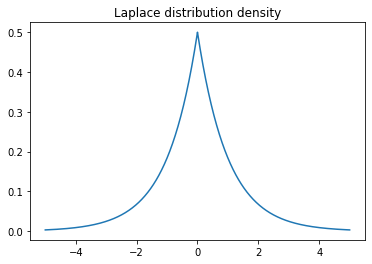

In [ ]:
#@title Plotting Laplace distribution
from scipy.stats import laplace
x = np.linspace(-5, 5, num=1001)
plt.plot(x, laplace.pdf(x))
plt.title("Laplace distribution density")
plt.show()

Let's show an example of the power of the Laplace mechansism. Consider the query - count the number of users in the dataset. Assume that there are 300 users in the dataset, and adding one more would make 301. Then by adding laplace random noise to each of these numbers we would have the following distributions.

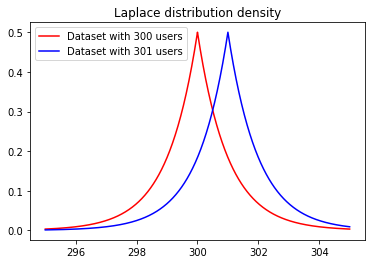

In [ ]:
#@title Plotting distributions after adding noise
from scipy.stats import laplace
eps = 1
x = np.linspace(300-5, 300+5, num=1001)
plt.plot(x, laplace.pdf(x, loc=300, scale=1/eps), c="r")
plt.plot(x, laplace.pdf(x, loc=301, scale=1/eps), c="b")
plt.legend(["Dataset with 300 users", "Dataset with 301 users"])
plt.title("Laplace distribution density")
plt.show()

The laplace mechanism formula: $q(x) + Lap(\frac{\Delta q}{\varepsilon})$, where $q(x)$ is the original query, ${\varepsilon}$ - privacy budget and $\Delta q$ is the sensitivity of $q$, i.e. how much $q$ might change by adding or removing 1 user from the dataset.

##Exercise 0
Write a function that adds laplace noise.

In [ ]:
def add_laplace_noise(x, eps, sensitivity):
   # TODO: write your code here

print(add_laplace_noise(x=50, eps=100, sensitivity=1)) # should print some floating point around 50
print(add_laplace_noise(x=50, eps=1, sensitivity=1)) # should print some floating point likely in range [45, 55]
print(add_laplace_noise(x=50, eps=1, sensitivity=10)) # should print some floating point likely in range [0, 100]

In [ ]:
#@title Solution (click on the arrow button to run, double click to open)
def add_laplace_noise(x, eps, sensitivity):
  scale = sensitivity/eps
  return x + np.random.laplace(scale=scale)

print(add_laplace_noise(x=50, eps=100, sensitivity=1)) # should print some floating point around 50
print(add_laplace_noise(x=50, eps=1, sensitivity=1)) # should print some floating point likely in range [45, 55]
print(add_laplace_noise(x=50, eps=1, sensitivity=10)) # should print some floating point likely in range [0, 100]

Further we assume knowledge of Apache Beam in the scope of the first Colab.

The exercise framework is the same in the [first Colab](https://colab.sandbox.google.com/drive/1yL7VR4eGXBUSMmvLXp1klMyDc-3QfFJ5#). Namely it has function run_pipeline, which executes a user defined pipeline function. The output of the pipeline is stored in a file 'outputs/(pipeline_fn name)'.

Each exercise has a solution.

#Exercises

In all following exercises elements of the input collection are MovieView objects:

In [ ]:
@dataclass
class MovieView:
  user_id: int
  movie_id: int
  rating: int
  date: dt.datetime


##Exercise 1

Compute with the Laplace mechanism the anonimized number of users in the dataset. What is sensitivity of this query?

In [ ]:
def anon_user_count(views, eps=1):
  # TODO: write your code here

run_pipeline(anon_user_count)

print("\nOutput:")
!cat "outputs/anon_user_count"

In [ ]:
#@title Solution
def anon_user_count(views, eps=1):
  user_ids = views | beam.Map(lambda mv: mv.user_id) | beam.Distinct()
  sensitivity = 1 # adding/removing 1 user changes the result by 1.
  return user_ids | combiners.Count.Globally() | beam.Map(lambda c: add_laplace_noise(c, eps, sensitivity))

run_pipeline(anon_user_count)

print("\nOutput:")
!cat "outputs/anon_user_count"

Note, that the result is floating point, not integer, despite we computed counts. That's fine, the user of those statistics can round to integers (which is privacy safe, since post-processing of DP metric doesn't change privacy guarantees). On other hand rounding to integers might cause information loss (for example if a data analysist would like to get distribution for true values).

##Exercise 2 Counting movie views (i.e. rows) in the dataset

The idea is to use the Laplace mechanism for this. This is a little bit more tricky. What's is the sensitivity of this query?

In [ ]:
#@title Answer for sensitivity
# maximum views per user (which is unknown and might be pretty large)

The common approach is to bound maximum number of contributions per user by subsampling (see exercise 5 of the first Colab with example of doing this).

In [ ]:
def anon_views_count(views, max_user_contributions=1, eps=1):
  # TODO: write your code here

run_pipeline(anon_views_count)

print("\nOutput:")
!cat "outputs/anon_views_count"

In [ ]:
#@title Solution
def anon_views_count(views, max_user_contributions=1, eps=1):
  # FixedSizePerKey requires (key, value), the value is not needed let's use None as value. 
  user_ids = views | beam.Map(lambda mv: (mv.user_id, None)) 
  # elements have type: ((key, [values]))
  pcoll = user_ids | combiners.Sample.FixedSizePerKey(max_user_contributions)
  
  # Let's unnest it and leave only values. 
  pcoll = pcoll | "Unnest values" >> beam.FlatMap(lambda kv: kv[1])

  sensitivity = max_user_contributions
  return pcoll | combiners.Count.Globally() | beam.Map(lambda c: add_laplace_noise(c, eps, sensitivity))

run_pipeline(anon_views_count)

print("\nOutput:")
!cat "outputs/anon_views_count"

##Exercise 3 Counting movie views per year

In this exercise the term partition will be used. 

**A partition** is a subset of the data corresponding to a given value of the aggregation criterion. 

In this exercise a partition corresponds to a year.



###Exercise 3a
Let's start with computing the exact (i.e. non-private) number of views per year. It will be pretty instructive to show differences between DP and non-DP metric computation.


In [ ]:
def views_per_year_count(views):
  # TODO: write your code here (note that MovieView has date field)

run_pipeline(views_per_year_count)

print("\nOutput:")
!cat "outputs/views_per_year_count"

In [ ]:
#@title Solution
def views_per_year_count(views):
  return views | beam.Map(lambda mv: mv.date.year) | combiners.Count.PerElement()

run_pipeline(views_per_year_count)

print("\nOutput:")
!cat "outputs/views_per_year_count"

###Exercise 3b Bounding contributions

The same as in Exercise 2, for computing the scale of laplace noise to add we need to bound each user constributions. Here it's slightly more complicated, since each user might contribute to multiple partitions (which are defined by years) and also contribute multiple times per partition.

The goal of this exercise to take PCollleciton of MovieView, bound both maximum number of partitions and maximum contribution per partition per user. And to return PCollection of MovieView.
More precisely, the functions should limit the number of years contributed by a user to max_partitions and the number of views contributed to each year to max_per_partition.



In [ ]:
def bound_contributions(views, max_partitions=2, max_per_partition=2):
  # TODO: add your code here  

run_pipeline(bound_contributions)

print("Number of rows after bounding:")
!wc -l "outputs/bound_contributions"
print("Sample of rows:")
!head -5 "outputs/bound_contributions"

In [ ]:
#@title Solution
def bound_contributions(views, max_partitions=2, max_per_partition=2):
  # ((user_id, year), MovieView)
  pcoll = views | "Rekey">>beam.Map(lambda mv: ((mv.user_id, mv.date.year), mv))
  # ((user_id, year), [MovieView])
  pcoll = pcoll | "Bound per partition" >> combiners.Sample.FixedSizePerKey(max_per_partition)
  # (user_id, [MovieView])
  pcoll = pcoll | "Rekey to key=user_id" >> beam.MapTuple(lambda kv, mv: (kv[0], mv))
  
   # (user_id, [[MovieView]])
  pcoll = pcoll | "Bound buckets" >> combiners.Sample.FixedSizePerKey(max_partitions)

  # [MovieView]
  pcoll = pcoll | "Unnest outer list and drop key" >> beam.ParDo(lambda kv: kv[1])
  return pcoll | "Unnest inner list" >> beam.ParDo(lambda x:x)

run_pipeline(bound_contributions)

print("Number of rows after bounding:")
!wc -l "outputs/bound_contributions"
print("Sample of rows:")
!head -5 "outputs/bound_contributions"

### Exercise 3c Putting it together and adding Laplace noise

Now we have almost everything (one nuance in the next exercise) to compute with DP count of views per year.

One subtlety is how to compute the scale of the Laplace noise. Since each user can contribute to multiple partitions we need to split the budget over partitions.

In [ ]:
def anon_views_per_year_count(views, eps=1, max_partitions=2, max_per_partition=2):
  # TODO: write your code here
  # 1.Bound contributions
  # 2.Compute views per year
  # 3.Add Laplace noise

run_pipeline(anon_views_per_year_count)

print("\nOutput:")
!cat "outputs/anon_views_per_year_count"

In [ ]:
#@title Solution
def add_laplace_noise_to_values(kv_coll, eps, max_partitions, max_per_partition):
  # since one user might contribute to multiple partitions, let's split the budget.
  eps_per_partition = eps/max_partitions

  sensitivity_per_partition = max_per_partition

  return kv_coll | beam.MapTuple(lambda k, v: (k, add_laplace_noise(v, eps_per_partition, sensitivity_per_partition)))
  

def anon_views_per_year_count(views, eps=1, max_partitions=2, max_per_partition=2):
  pcoll = bound_contributions(views, max_partitions, max_per_partition)
  year_count = views_per_year_count(pcoll)
  return add_laplace_noise_to_values(year_count, eps, max_partitions, max_per_partition)

run_pipeline(anon_views_per_year_count)

print("\nOutput:")
!cat "outputs/anon_views_per_year_count"

###Exercise 3d A nuance on the partition selection

We saw that the dataset contains movie views from 2000-2005. Let's imagine that 1 user with a movie view in 2006 is added to the dataset. As a result, the output has one more partition, namely for 2006. And we have this deterministically. This is a DP violation: a single user changed the partitions returned by the query. 

We came to the problem of the partition selection. There are multiple ways how to deal with it. For now, let's do it with so called **public partitions**. Let's consider for example how to do it in our case

Assume that we want to get count of views for years 2001-2006. Then our algorithm will be (in bold new steps in comparison with previous exercise)


1.   **Drop all data rows which correspond to years outside of 2001-2006 (2000 in this case)**
2.  Bound contributions
3.  Compute count per year
4.  **Add 0s for all missing years from 2001-2006**
5.  Add Laplace noise

**Remark**: This method is called "Public partitions", because the existence of these partitions are known based on public knowledge, without looking at private data.


In [ ]:
def anon_views_per_year_count_fixed(views, years_to_output=range(2001, 2007), eps=1, max_partitions=2, max_per_partition=2):
  # todo: write your code

run_pipeline(anon_views_per_year_count_fixed)

print("\nOutput:")
!cat "outputs/anon_views_per_year_count_fixed"

In [ ]:
#@title Solution
def add_laplace_noise_to_values(kv_coll, eps, max_partitions, max_per_partition):
  # since one user might contribute to multiple partitions, let's split the budget.
  eps_per_partition = eps/max_partitions

  sensitivity_per_partition = max_per_partition

  return kv_coll | beam.MapTuple(lambda k, v: (k, add_laplace_noise(v, eps_per_partition, sensitivity_per_partition)))
  

def anon_views_per_year_count_fixed(views, years_to_output=range(2001, 2007), eps=1, max_partitions=2, max_per_partition=2):
  pcoll = views | beam.Filter(lambda mv: mv.date.year in years_to_output)
  pcoll = bound_contributions(pcoll, max_partitions, max_per_partition)
  year_count = views_per_year_count(pcoll)
  pipeline = views.pipeline # a pipeline is required for PCollection creation
  year_zeros = pipeline | beam.Create([(y, 0) for y in years_to_output])

  # Flatten counts with 0th and sum per key. Counts would change, 0 pattition for missing public keys are added.
  year_count_with_zeros = (year_count, year_zeros) | beam.Flatten() | beam.CombinePerKey(sum)

  return add_laplace_noise_to_values(year_count_with_zeros, eps, max_partitions, max_per_partition)

run_pipeline(anon_views_per_year_count_fixed)

print("\nOutput:")
!cat "outputs/anon_views_per_year_count_fixed"

**Question**: what if we change order of steps 1 and 2, i.e. at first bound contributions and then drop all years outside of given ones?

In [ ]:
#@title answer (double click to open)
#The result will be DP, but the data might be unnecessarily dropped for public partitions during contribution bounding